# Agency vs Communion - corellation analysis

In [1]:
# general
import pandas as pd
import numpy as np
import scipy.stats
import codecs
from matplotlib import pyplot as plt
from numpy import linalg as LA

# bolukbasi's
import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding

# mine
import db_functions as db

### Step 1: Load embeddings

We load all the emdeddings using the same methods and applying the same preprocessing in order to have a common start.

In [2]:
# load Gonen's emdebbings
E_g =  WordEmbedding('../embedding/gonen/it_lemma_to_fem', 'g')

*** Reading data from ../embedding/gonen/it_lemma_to_fem
(160597, 300)
160597 words of dimension 300 : </s>, ,, di, ., ..., title="henrik, pass">, title="nils, title="derrick
160597 words of dimension 300 : </s>, ,, di, ., ..., title="henrik, pass">, title="nils, title="derrick


In [2]:
# load FastText's emdeddings
E_ft =  WordEmbedding('../embedding/fast-text/cc.it.300.reduced.vec', 'ft')

*** Reading data from ../embedding/fast-text/cc.it.300.reduced.vec
(485, 300)
485 words of dimension 300 : questo, sua, suo, prima, ..., supportivo, calzolaia, supportiva, agrotecnica
485 words of dimension 300 : questo, sua, suo, prima, ..., supportivo, calzolaia, supportiva, agrotecnica


### Step 2: working whit FastText's embeddings

### Step 2.1: vector difference

In [3]:
# gender direction
g_diff = E_ft.diff('lui', 'lei')

#### Step 2.2: PCA

In [4]:
# list of pairs to define gender
gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [5]:
# PCA
pca = we.doPCA(gender_pairs, E_ft)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [6]:
print("Singular values:")
print(sv)

Singular values:
[9.5309240e-01 5.3566736e-01 3.7772956e-01 3.4538972e-01 2.9901835e-01
 2.4023318e-01 5.8411594e-08 4.6098762e-08 4.3273410e-08 4.1712632e-08]


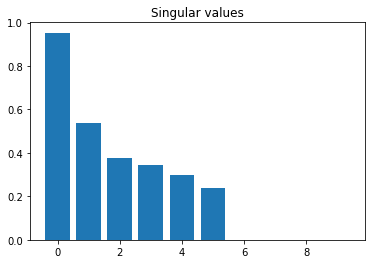

In [7]:
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()

In [8]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])
g_pca_01 = (sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1])/LA.norm((sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1]))

#### Step 2.3: pseudo-LDA

In [9]:
S_word = [['lui','lei'],
          ['uomo','donna'], 
          ['padre','madre'],
          ['marito','moglie'],
          ['fratello','sorella'],
          ['maschio','femmina']]

G_word = db.read('gram_def_mf.txt', 'mf')

In [10]:
S_m_v = []
for w in S_word:
    S_m_v.append(E_ft.v(w[1]))
    
S_f_v = []
for w in S_word:
    S_f_v.append(E_ft.v(w[0]))
    
G_m_v = []
for w in G_word:
    G_m_v.append(E_ft.v(w[0]))
    
G_f_v = []
for w in G_word:
    G_f_v.append(E_ft.v(w[1]))

S_m = np.array(S_m_v).T
S_f = np.array(S_f_v).T
G_m = np.array(G_m_v).T
G_f = np.array(G_f_v).T

In [11]:
# delta semantic
Delta_S = np.dot(np.subtract(S_m, S_f), np.subtract(S_m, S_f).T)

# delta grammatical
Delta_G = np.dot(np.subtract(G_m, G_f), np.subtract(G_m, G_f).T)

# A
A = np.dot(np.linalg.inv(Delta_G), Delta_S)

In [12]:
# eigenvalues and eigenvectors
w, v = np.linalg.eig(A)

# gender direction: pick the eigenvector associated to the largest eigenvalue
g_e = v[:,np.argmax(w)] # already normalized

#### Step 2.5: Compute projections

##### All words

In [13]:
# words
ag_com = db.read('ag_com_mf_ita.txt', 'ag-com-mf')

In [14]:
# compute projections
# all words male
proj_ag_com_m_g_diff =  db.prof_proj(E_ft, ag_com, g_diff, 'ag-com-m')
proj_ag_com_m_g_pca_0 =  db.prof_proj(E_ft, ag_com, g_pca_0, 'ag-com-m')
proj_ag_com_m_g_pca_01 =  db.prof_proj(E_ft, ag_com, g_pca_01, 'ag-com-m')
proj_ag_com_m_g_e =  db.prof_proj(E_ft, ag_com, g_e, 'ag-com-m')

# all words female
proj_ag_com_f_g_diff =  db.prof_proj(E_ft, ag_com, g_diff, 'ag-com-f')
proj_ag_com_f_g_pca_0 =  db.prof_proj(E_ft, ag_com, g_pca_0, 'ag-com-f')
proj_ag_com_f_g_pca_01 =  db.prof_proj(E_ft, ag_com, g_pca_01, 'ag-com-f')
proj_ag_com_f_g_e =  db.prof_proj(E_ft, ag_com, g_e, 'ag-com-f')

In [15]:
# print ag_com_m results
ag_com_m_col0 = [] # pandas columns
ag_com_m_col1 = []
ag_com_m_col2 = []
ag_com_m_col3 = []
ag_com_m_col4 = []
ag_com_m_col5 = []
ag_com_m_col6 = []

for i in range(len(proj_ag_com_m_g_diff)):
    ag_com_m_col0.append(proj_ag_com_m_g_diff[i][0]) # word
    ag_com_m_col1.append(proj_ag_com_m_g_diff[i][1]) # projection on g_diff
    ag_com_m_col2.append(proj_ag_com_m_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_m_col3.append(proj_ag_com_m_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_m_col4.append(np.real(proj_ag_com_m_g_e[i][1])) # projection on g_e
    ag_com_m_col5.append(proj_ag_com_m_g_diff[i][2])
    ag_com_m_col6.append(proj_ag_com_m_g_diff[i][3])

ag_com_m_data = {'Word':ag_com_m_col0, 
               'Proj g_diff':ag_com_m_col1,
               'Proj g_pca_0':ag_com_m_col2, 
               'Proj g_pca_01':ag_com_m_col3,
               'Proj g_e':ag_com_m_col4,
               'Agency':ag_com_m_col5,
               'Communion':ag_com_m_col6}

ag_com_m_table = pd.DataFrame(ag_com_m_data)
ag_com_m_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0           abile     0.080335      0.102190       0.122643 -0.104315    2.32   
1          attivo     0.133193      0.196107       0.180168 -0.056429    2.35   
2      affettuoso     0.059949      0.173368       0.126707  0.007737   -0.85   
3       altruista    -0.014515      0.007354       0.004393 -0.039926   -1.18   
4       ambizioso     0.152494      0.288911       0.251100 -0.012472    2.79   
5          deciso     0.033273      0.090033       0.046084 -0.009320    2.88   
6        vanitoso     0.105291      0.191813       0.171161 -0.027970    1.29   
7          capace     0.059239      0.016343       0.053817 -0.042131    2.45   
8   confusionario     0.069705      0.196830       0.142547 -0.005169   -1.89   
9    comunicativo     0.085256      0.186069       0.156890  0.062600    1.50   
10     competente     0.001019      0.001375      -0.003906 -0.059758    2.21   
11    competitivo     0.072216      0.153743       0.123873  0.033614    2.71   
12    presuntuoso     0.112785      0.230236       0.198067 -0.019344    1.53   
13   coscienzioso     0.080623      0.233943       0.178483  0.031092    0.58   
14     rispettoso     0.003357      0.081186       0.073712 -0.005914   -0.35   
15       coerente     0.008640      0.028646       0.026779 -0.006384    0.74   
16       creativo     0.049542      0.171296       0.115495  0.069760    1.63   
17     distaccato     0.066982      0.107033       0.088526 -0.030023    1.61   
18    determinato     0.085489      0.161167       0.132144 -0.062205    2.73   
19         rigido     0.022966      0.143632       0.088457 -0.030998    0.38   
20      dominante    -0.003824     -0.026552      -0.022917 -0.003409    2.76   
21        egoista     0.019207      0.068976       0.061825  0.015381    1.53   
22        emotivo     0.002176      0.138984       0.072085  0.063686   -1.47   
23       energico     0.107926      0.225499       0.184724  0.010552    2.42   
24         giusto     0.019891      0.138324       0.074450 -0.059111   -0.50   
25     amichevole     0.105541     -0.011900       0.071073  0.026077    0.15   
26      credulone     0.125345      0.171865       0.159805 -0.006169   -2.26   
27           duro     0.089801      0.173903       0.130718 -0.043526    1.95   
28    disponibile    -0.029067     -0.036633      -0.032159 -0.094269   -0.42   
29         onesto     0.158445      0.283500       0.267362 -0.022697   -0.71   
..            ...          ...           ...            ...       ...     ...   
31    industrioso     0.159034      0.236315       0.231860 -0.033190    2.33   
32       insicuro     0.120952      0.157534       0.152214  0.026473   -2.35   
33   intelligente     0.018959      0.021584       0.036714 -0.082862    2.21   
34          pigro     0.132930      0.251297       0.207737 -0.074621   -2.45   
35          leale     0.036705      0.071928       0.078136 -0.029000   -0.88   
36         morale     0.020409     -0.001598       0.012607  0.013637   -0.78   
37       ostinato     0.148413      0.220851       0.209971 -0.021557    2.43   
38         aperto     0.050825      0.112805       0.113153 -0.058259    0.45   
39     estroverso     0.114540      0.196991       0.183171  0.046713    1.11   
40  perfezionista     0.033121      0.033435       0.003049 -0.010791    2.15   
41    persistente    -0.013694     -0.032687      -0.041319 -0.016172    1.78   
42        educato     0.108748      0.212897       0.197991 -0.043156    0.13   
43      razionale     0.050378      0.088966       0.098017 -0.051103    1.73   
44     affidabile     0.041913      0.043473       0.042771  0.015663    0.45   
45      riservato     0.047410      0.050367       0.059830 -0.049909    0.11   
46    autocritico     0.066012      0.141519       0.136552  0.018264    0.25   
47       autonomo     0.075318      0.092021       0.104539 -0.029861    2.76   
48      sensibile    -0.042295     -0.013248

In [16]:
# ag_com_m pearson correlation
# agency correlation
r_ag_com_m_g_diff = scipy.stats.pearsonr(ag_com_m_col5, ag_com_m_col1)[0]
r_ag_com_m_g_pca_0 = scipy.stats.pearsonr(ag_com_m_col5, ag_com_m_col2)[0]
r_ag_com_m_g_pca_01 = scipy.stats.pearsonr(ag_com_m_col5, ag_com_m_col3)[0]
r_ag_com_m_g_e = scipy.stats.pearsonr(ag_com_m_col5, ag_com_m_col4)[0]
p_ag_com_m_g_diff = scipy.stats.pearsonr(ag_com_m_col5, ag_com_m_col1)[1]
p_ag_com_m_g_pca_0 = scipy.stats.pearsonr(ag_com_m_col5, ag_com_m_col2)[1]
p_ag_com_m_g_pca_01 = scipy.stats.pearsonr(ag_com_m_col5, ag_com_m_col3)[1]
p_ag_com_m_g_e = scipy.stats.pearsonr(ag_com_m_col5, ag_com_m_col4)[1]

In [17]:
pearson_data = {'g_diff':[r_ag_com_m_g_diff,p_ag_com_m_g_diff],
                'g_pca_0':[r_ag_com_m_g_pca_0,p_ag_com_m_g_pca_0],
                'g_pca_01':[r_ag_com_m_g_pca_01,p_ag_com_m_g_pca_01],
                'g_e':[r_ag_com_m_g_e,p_ag_com_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency male correlation")
pearson_table

Agency male correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.203419  0.006002  0.069686  0.001936
p  0.115864  0.963385  0.593581  0.988188

In [18]:
# communion correlation
r_ag_com_m_g_diff = scipy.stats.pearsonr(ag_com_m_col6, ag_com_m_col1)[0]
r_ag_com_m_g_pca_0 = scipy.stats.pearsonr(ag_com_m_col6, ag_com_m_col2)[0]
r_ag_com_m_g_pca_01 = scipy.stats.pearsonr(ag_com_m_col6, ag_com_m_col3)[0]
r_ag_com_m_g_e = scipy.stats.pearsonr(ag_com_m_col6, ag_com_m_col4)[0]
p_ag_com_m_g_diff = scipy.stats.pearsonr(ag_com_m_col6, ag_com_m_col1)[1]
p_ag_com_m_g_pca_0 = scipy.stats.pearsonr(ag_com_m_col6, ag_com_m_col2)[1]
p_ag_com_m_g_pca_01 = scipy.stats.pearsonr(ag_com_m_col6, ag_com_m_col3)[1]
p_ag_com_m_g_e = scipy.stats.pearsonr(ag_com_m_col6, ag_com_m_col4)[1]

In [19]:
pearson_data = {'g_diff':[r_ag_com_m_g_diff,p_ag_com_m_g_diff],
                'g_pca_0':[r_ag_com_m_g_pca_0,p_ag_com_m_g_pca_0],
                'g_pca_01':[r_ag_com_m_g_pca_01,p_ag_com_m_g_pca_01],
                'g_e':[r_ag_com_m_g_e,p_ag_com_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion male correlation")
pearson_table

Communion male correlation


g_diff   g_pca_0  g_pca_01       g_e
r -0.247770 -0.191931 -0.171864  0.003647
p  0.054198  0.138385  0.185367  0.977747

In [20]:
# agency-communion correlation
r_ag_com_m_g_diff = scipy.stats.pearsonr(np.array(ag_com_m_col5)-np.array(ag_com_m_col6), ag_com_m_col1)[0]
r_ag_com_m_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_m_col5)-np.array(ag_com_m_col6), ag_com_m_col2)[0]
r_ag_com_m_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_m_col5)-np.array(ag_com_m_col6), ag_com_m_col3)[0]
r_ag_com_m_g_e = scipy.stats.pearsonr(np.array(ag_com_m_col5)-np.array(ag_com_m_col6), ag_com_m_col4)[0]
p_ag_com_m_g_diff = scipy.stats.pearsonr(np.array(ag_com_m_col5)-np.array(ag_com_m_col6), ag_com_m_col1)[1]
p_ag_com_m_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_m_col5)-np.array(ag_com_m_col6), ag_com_m_col2)[1]
p_ag_com_m_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_m_col5)-np.array(ag_com_m_col6), ag_com_m_col3)[1]
p_ag_com_m_g_e = scipy.stats.pearsonr(np.array(ag_com_m_col5)-np.array(ag_com_m_col6), ag_com_m_col4)[1]

In [21]:
pearson_data = {'g_diff':[r_ag_com_m_g_diff,p_ag_com_m_g_diff],
                'g_pca_0':[r_ag_com_m_g_pca_0,p_ag_com_m_g_pca_0],
                'g_pca_01':[r_ag_com_m_g_pca_01,p_ag_com_m_g_pca_01],
                'g_e':[r_ag_com_m_g_e,p_ag_com_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion male correlation")
pearson_table

Agency-Communion male correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.276526  0.113466  0.144346 -0.000794
p  0.030981  0.383930  0.267051  0.995156

In [22]:
# print ag_com_f results
ag_com_f_col0 = [] # pandas columns
ag_com_f_col1 = []
ag_com_f_col2 = []
ag_com_f_col3 = []
ag_com_f_col4 = []
ag_com_f_col5 = []
ag_com_f_col6 = []

for i in range(len(proj_ag_com_f_g_diff)):
    ag_com_f_col0.append(proj_ag_com_f_g_diff[i][0]) # word
    ag_com_f_col1.append(proj_ag_com_f_g_diff[i][1]) # projection on g_diff
    ag_com_f_col2.append(proj_ag_com_f_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_f_col3.append(proj_ag_com_f_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_f_col4.append(np.real(proj_ag_com_f_g_e[i][1])) # projection on g_e
    ag_com_f_col5.append(proj_ag_com_f_g_diff[i][2])
    ag_com_f_col6.append(proj_ag_com_f_g_diff[i][3])

ag_com_f_data = {'Word':ag_com_f_col0, 
               'Proj g_diff':ag_com_f_col1,
               'Proj g_pca_0':ag_com_f_col2, 
               'Proj g_pca_01':ag_com_f_col3,
               'Proj g_e':ag_com_f_col4,
               'Agency':ag_com_f_col5,
               'Communion':ag_com_f_col6}

ag_com_f_table = pd.DataFrame(ag_com_f_data)
ag_com_f_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0           abile     0.080335      0.102190       0.122643 -0.104315    2.32   
1          attiva    -0.064096     -0.168159      -0.144804 -0.067533    2.35   
2      affettuosa    -0.090580     -0.210513      -0.164882  0.021044   -0.85   
3       altruista    -0.014515      0.007354       0.004393 -0.039926   -1.18   
4       ambiziosa    -0.092678     -0.189249      -0.159715 -0.005288    2.79   
5          decisa    -0.067846     -0.143159      -0.145939 -0.013854    2.88   
6        vanitosa    -0.198017     -0.249589      -0.267793 -0.073265    1.29   
7          capace     0.059239      0.016343       0.053817 -0.042131    2.45   
8   confusionaria    -0.055924     -0.151937      -0.139887 -0.011241   -1.89   
9    comunicativa    -0.036487     -0.132258      -0.091725  0.047612    1.50   
10     competente     0.001019      0.001375      -0.003906 -0.059758    2.21   
11    competitiva    -0.047236     -0.134371      -0.120322  0.011940    2.71   
12    presuntuosa    -0.155129     -0.225394      -0.213209 -0.021986    1.53   
13   coscienziosa    -0.143502     -0.191816      -0.193955 -0.012083    0.58   
14     rispettosa    -0.134849     -0.164942      -0.158365 -0.046200   -0.35   
15       coerente     0.008640      0.028646       0.026779 -0.006384    0.74   
16       creativa    -0.091441     -0.177857      -0.161179  0.046455    1.63   
17     distaccata    -0.091450     -0.167649      -0.154857 -0.036183    1.61   
18    determinata    -0.125456     -0.214665      -0.196158 -0.065687    2.73   
19         rigida    -0.062169     -0.164229      -0.147526 -0.019134    0.38   
20      dominante    -0.003824     -0.026552      -0.022917 -0.003409    2.76   
21        egoista     0.019207      0.068976       0.061825  0.015381    1.53   
22        emotiva    -0.061101     -0.149022      -0.111107  0.017567   -1.47   
23       energica    -0.131609     -0.223658      -0.198947  0.025520    2.42   
24         giusta     0.061748     -0.100659      -0.034911 -0.059111   -0.50   
25     amichevole     0.105541     -0.011900       0.071073  0.026077    0.15   
26      credulona    -0.205024     -0.276244      -0.276607 -0.003974   -2.26   
27           dura     0.003049     -0.119388      -0.085342 -0.043526    1.95   
28    disponibile    -0.029067     -0.036633      -0.032159 -0.094269   -0.42   
29         onesta    -0.095098     -0.199431      -0.145683 -0.023121   -0.71   
..            ...          ...           ...            ...       ...     ...   
31    industriosa    -0.024405     -0.160201      -0.086158 -0.016591    2.33   
32       insicura    -0.173446     -0.207040      -0.223097  0.013077   -2.35   
33   intelligente     0.018959      0.021584       0.036714 -0.082862    2.21   
34          pigra    -0.199196     -0.265479      -0.286964 -0.087222   -2.45   
35          leale     0.036705      0.071928       0.078136 -0.029000   -0.88   
36         morale     0.020409     -0.001598       0.012607  0.013637   -0.78   
37       ostinata    -0.113738     -0.193593      -0.155859 -0.001751    2.43   
38         aperta     0.004460     -0.134219      -0.075228  0.007150    0.45   
39     estroversa    -0.163531     -0.192500      -0.209803  0.041504    1.11   
40  perfezionista     0.033121      0.033435       0.003049 -0.010791    2.15   
41    persistente    -0.013694     -0.032687      -0.041319 -0.016172    1.78   
42        educata    -0.221699     -0.202325      -0.236916 -0.014527    0.13   
43      razionale     0.050378      0.088966       0.098017 -0.051103    1.73   
44     affidabile     0.041913      0.043473       0.042771  0.015663    0.45   
45      riservata    -0.035033     -0.143213      -0.101787 -0.073600    0.11   
46    autocritica     0.005914     -0.072324      -0.018932  0.030559    0.25   
47       autonoma    -0.035046     -0.159707      -0.110293 -0.033185    2.76   
48      sensibile    -0.042295     -0.013248

In [23]:
# ag_com_f pearson correlation
# agency correlation
r_ag_com_f_g_diff = scipy.stats.pearsonr(ag_com_f_col5, ag_com_f_col1)[0]
r_ag_com_f_g_pca_0 = scipy.stats.pearsonr(ag_com_f_col5, ag_com_f_col2)[0]
r_ag_com_f_g_pca_01 = scipy.stats.pearsonr(ag_com_f_col5, ag_com_f_col3)[0]
r_ag_com_f_g_e = scipy.stats.pearsonr(ag_com_f_col5, ag_com_f_col4)[0]
p_ag_com_f_g_diff = scipy.stats.pearsonr(ag_com_f_col5, ag_com_f_col1)[1]
p_ag_com_f_g_pca_0 = scipy.stats.pearsonr(ag_com_f_col5, ag_com_f_col2)[1]
p_ag_com_f_g_pca_01 = scipy.stats.pearsonr(ag_com_f_col5, ag_com_f_col3)[1]
p_ag_com_f_g_e = scipy.stats.pearsonr(ag_com_f_col5, ag_com_f_col4)[1]

In [24]:
pearson_data = {'g_diff':[r_ag_com_f_g_diff,p_ag_com_f_g_diff],
                'g_pca_0':[r_ag_com_f_g_pca_0,p_ag_com_f_g_pca_0],
                'g_pca_01':[r_ag_com_f_g_pca_01,p_ag_com_f_g_pca_01],
                'g_e':[r_ag_com_f_g_e,p_ag_com_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency female correlation")
pearson_table

Agency female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.234394  0.116392  0.157147  0.042861
p  0.069030  0.371703  0.226471  0.742928

In [25]:
# communion correlation
r_ag_com_f_g_diff = scipy.stats.pearsonr(ag_com_f_col6, ag_com_f_col1)[0]
r_ag_com_f_g_pca_0 = scipy.stats.pearsonr(ag_com_f_col6, ag_com_f_col2)[0]
r_ag_com_f_g_pca_01 = scipy.stats.pearsonr(ag_com_f_col6, ag_com_f_col3)[0]
r_ag_com_f_g_e = scipy.stats.pearsonr(ag_com_f_col6, ag_com_f_col4)[0]
p_ag_com_f_g_diff = scipy.stats.pearsonr(ag_com_f_col6, ag_com_f_col1)[1]
p_ag_com_f_g_pca_0 = scipy.stats.pearsonr(ag_com_f_col6, ag_com_f_col2)[1]
p_ag_com_f_g_pca_01 = scipy.stats.pearsonr(ag_com_f_col6, ag_com_f_col3)[1]
p_ag_com_f_g_e = scipy.stats.pearsonr(ag_com_f_col6, ag_com_f_col4)[1]

In [26]:
pearson_data = {'g_diff':[r_ag_com_f_g_diff,p_ag_com_f_g_diff],
                'g_pca_0':[r_ag_com_f_g_pca_0,p_ag_com_f_g_pca_0],
                'g_pca_01':[r_ag_com_f_g_pca_01,p_ag_com_f_g_pca_01],
                'g_e':[r_ag_com_f_g_e,p_ag_com_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion female correlation")
pearson_table

Communion female correlation


g_diff   g_pca_0  g_pca_01      g_e
r  0.155887  0.232685  0.236638  0.03153
p  0.230265  0.071139  0.066337  0.80938

In [27]:
# agency-communion correlation
r_ag_com_f_g_diff = scipy.stats.pearsonr(np.array(ag_com_f_col5)-np.array(ag_com_f_col6), ag_com_f_col1)[0]
r_ag_com_f_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_f_col5)-np.array(ag_com_f_col6), ag_com_f_col2)[0]
r_ag_com_f_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_f_col5)-np.array(ag_com_f_col6), ag_com_f_col3)[0]
r_ag_com_f_g_e = scipy.stats.pearsonr(np.array(ag_com_f_col5)-np.array(ag_com_f_col6), ag_com_f_col4)[0]
p_ag_com_f_g_diff = scipy.stats.pearsonr(np.array(ag_com_f_col5)-np.array(ag_com_f_col6), ag_com_f_col1)[1]
p_ag_com_f_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_f_col5)-np.array(ag_com_f_col6), ag_com_f_col2)[1]
p_ag_com_f_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_f_col5)-np.array(ag_com_f_col6), ag_com_f_col3)[1]
p_ag_com_f_g_e = scipy.stats.pearsonr(np.array(ag_com_f_col5)-np.array(ag_com_f_col6), ag_com_f_col4)[1]

In [28]:
pearson_data = {'g_diff':[r_ag_com_f_g_diff,p_ag_com_f_g_diff],
                'g_pca_0':[r_ag_com_f_g_pca_0,p_ag_com_f_g_pca_0],
                'g_pca_01':[r_ag_com_f_g_pca_01,p_ag_com_f_g_pca_01],
                'g_e':[r_ag_com_f_g_e,p_ag_com_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion female correlation")
pearson_table

Agency-Communion female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.066869 -0.055364 -0.030532  0.010502
p  0.608629  0.671721  0.815308  0.935977

##### Ungendered words

In [29]:
# words
ag_com_ung = db.read('ag_com_ung_ita.txt', 'ag-com-mf')

In [30]:
# compute projections
# all words ungendered
proj_ag_com_ung_g_diff =  db.prof_proj(E_ft, ag_com_ung, g_diff, 'ag-com-m')
proj_ag_com_ung_g_pca_0 =  db.prof_proj(E_ft, ag_com_ung, g_pca_0, 'ag-com-m')
proj_ag_com_ung_g_pca_01 =  db.prof_proj(E_ft, ag_com_ung, g_pca_01, 'ag-com-m')
proj_ag_com_ung_g_e =  db.prof_proj(E_ft, ag_com_ung, g_e, 'ag-com-m')

In [31]:
# print ag_com_ung results
ag_com_ung_col0 = [] # pandas columns
ag_com_ung_col1 = []
ag_com_ung_col2 = []
ag_com_ung_col3 = []
ag_com_ung_col4 = []
ag_com_ung_col5 = []
ag_com_ung_col6 = []

for i in range(len(proj_ag_com_ung_g_diff)):
    ag_com_ung_col0.append(proj_ag_com_ung_g_diff[i][0]) # word
    ag_com_ung_col1.append(proj_ag_com_ung_g_diff[i][1]) # projection on g_diff
    ag_com_ung_col2.append(proj_ag_com_ung_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_ung_col3.append(proj_ag_com_ung_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_ung_col4.append(np.real(proj_ag_com_ung_g_e[i][1])) # projection on g_e
    ag_com_ung_col5.append(proj_ag_com_ung_g_diff[i][2])
    ag_com_ung_col6.append(proj_ag_com_ung_g_diff[i][3])

ag_com_ung_data = {'Word':ag_com_ung_col0, 
               'Proj g_diff':ag_com_ung_col1,
               'Proj g_pca_0':ag_com_ung_col2, 
               'Proj g_pca_01':ag_com_ung_col3,
               'Proj g_e':ag_com_ung_col4,
               'Agency':ag_com_ung_col5,
               'Communion':ag_com_ung_col6}

ag_com_ung_table = pd.DataFrame(ag_com_ung_data)
ag_com_ung_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0           abile     0.080335      0.102190       0.122643 -0.104315    2.32   
1       altruista    -0.014515      0.007354       0.004393 -0.039926   -1.18   
2          capace     0.059239      0.016343       0.053817 -0.042131    2.45   
3      competente     0.001019      0.001375      -0.003906 -0.059758    2.21   
4        coerente     0.008640      0.028646       0.026779 -0.006384    0.74   
5       dominante    -0.003824     -0.026552      -0.022917 -0.003409    2.76   
6      amichevole     0.105541     -0.011900       0.071073  0.026077    0.15   
7     disponibile    -0.029067     -0.036633      -0.032159 -0.094269   -0.42   
8         egoista     0.019207      0.068976       0.061825  0.015381    1.53   
9    indipendente     0.030305     -0.033587      -0.010550  0.002886    2.65   
10   intelligente     0.018959      0.021584       0.036714 -0.082862    2.21   
11          leale     0.036705      0.071928       0.078136 -0.029000   -0.88   
12         morale     0.020409     -0.001598       0.012607  0.013637   -0.78   
13  perfezionista     0.033121      0.033435       0.003049 -0.010791    2.15   
14    persistente    -0.013694     -0.032687      -0.041319 -0.016172    1.78   
15      razionale     0.050378      0.088966       0.098017 -0.051103    1.73   
16     affidabile     0.041913      0.043473       0.042771  0.015663    0.45   
17      sensibile    -0.042295     -0.013248      -0.028098 -0.103465   -1.03   
18      socievole    -0.003064      0.009935       0.004534 -0.031136    0.66   
19     tollerante    -0.013130      0.030258       0.006962 -0.025656   -0.34   
20    vulnerabile    -0.056750     -0.053787      -0.066607 -0.070118   -2.29   

    Communion  
0        0.66  
1        2.50  
2        1.08  
3        0.61  
4        1.68  
5       -1.89  
6        2.23  
7        2.76  
8       -2.50  
9       -0.83  
10       1.16  
11       2.28  
12       1.58  
13       0.05  
14       0.23  
15       0.53  
16       2.21  
17       1.70  
18       2.71  
19       2.63  
20      -0.16

In [32]:
# ag_com_ung pearson correlation
# agency correlation
r_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col1)[0]
r_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col2)[0]
r_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col3)[0]
r_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col4)[0]
p_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col1)[1]
p_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col2)[1]
p_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col3)[1]
p_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col4)[1]

In [33]:
pearson_data = {'g_diff':[r_ag_com_ung_g_diff,p_ag_com_ung_g_diff],
                'g_pca_0':[r_ag_com_ung_g_pca_0,p_ag_com_ung_g_pca_0],
                'g_pca_01':[r_ag_com_ung_g_pca_01,p_ag_com_ung_g_pca_01],
                'g_e':[r_ag_com_ung_g_e,p_ag_com_ung_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency ungendered correlation")
pearson_table

Agency ungendered correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.452508  0.233299  0.286403  0.116970
p  0.039427  0.308784  0.208151  0.613601

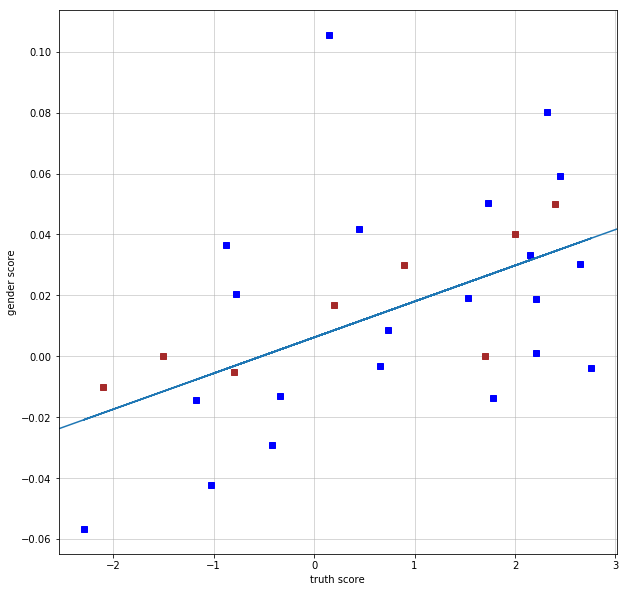

In [37]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)

my_x = [-2.1, -1.5, -0.8, 0.2, 0.9, 1.7, 2, 2.4]
my_y = [-0.01, 0, -0.005, 0.017, 0.03, 0, 0.04, 0.05]
ax.plot(my_x, my_y, linewidth=0, marker='s', color='brown')

ax.plot(ag_com_ung_col5, ag_com_ung_col1, linewidth=0, marker='s', color='blue')
#ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
xlims = plt.xlim()
x = [i for i in ag_com_ung_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_xlabel('truth score')
ax.set_ylabel('gender score')
'''
for i, label in enumerate(ag_com_ung_col0):
    if label=='vulnerabile':
        plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue

    if label=='dominante':
        plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
'''                 
plt.show()
fig.savefig('k.pdf', bbox_inches='tight', format='pdf')

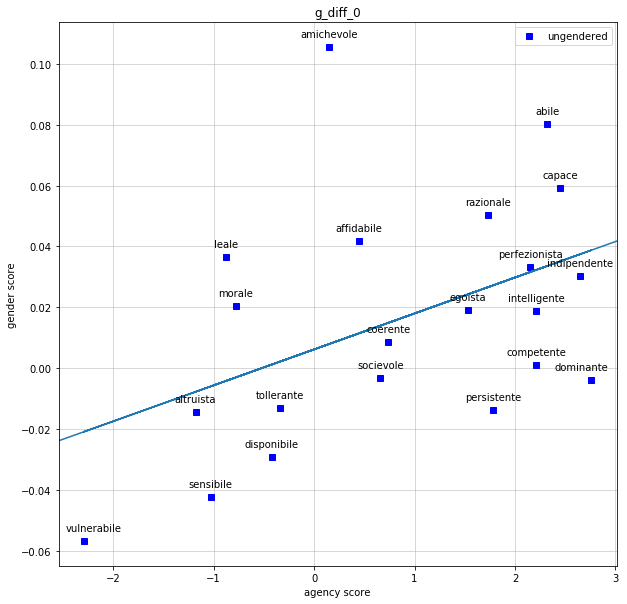

In [34]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(ag_com_ung_col5, ag_com_ung_col1, linewidth=0, marker='s', color='blue', label='ungendered')
#ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
xlims = plt.xlim()
x = [i for i in ag_com_ung_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_xlabel('agency score')
ax.set_ylabel('gender score')
ax.set_title("g_diff_0")
ax.legend()

for i, label in enumerate(ag_com_ung_col0):
    if label=='vulnerabile':
        plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue

    if label=='dominante':
        plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/ag/ft_g_diff.pdf', bbox_inches='tight', format='pdf')

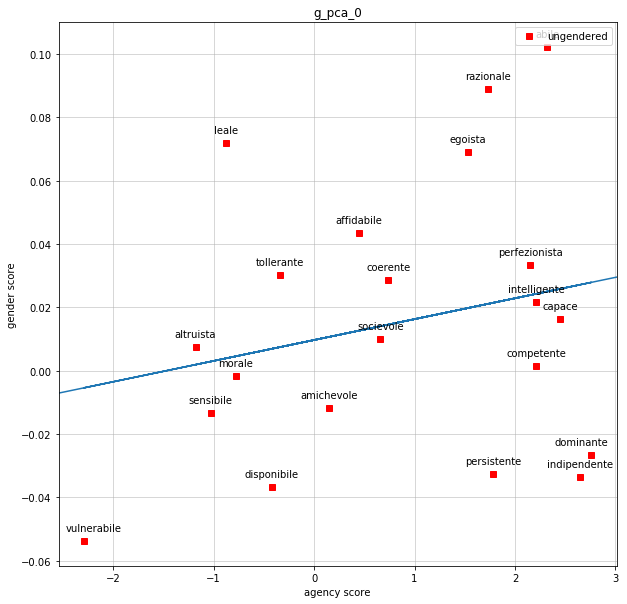

In [35]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col2)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(ag_com_ung_col5, ag_com_ung_col2, linewidth=0, marker='s', color='red', label='ungendered')
#ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
xlims = plt.xlim()
x = [i for i in ag_com_ung_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_xlabel('agency score')
ax.set_ylabel('gender score')
ax.set_title("g_pca_0")
ax.legend()

for i, label in enumerate(ag_com_ung_col0):
    if label=='vulnerabile':
        plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='dominante':
        plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue       
        
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/ag/ft_g_pca_0.pdf', bbox_inches='tight', format='pdf')

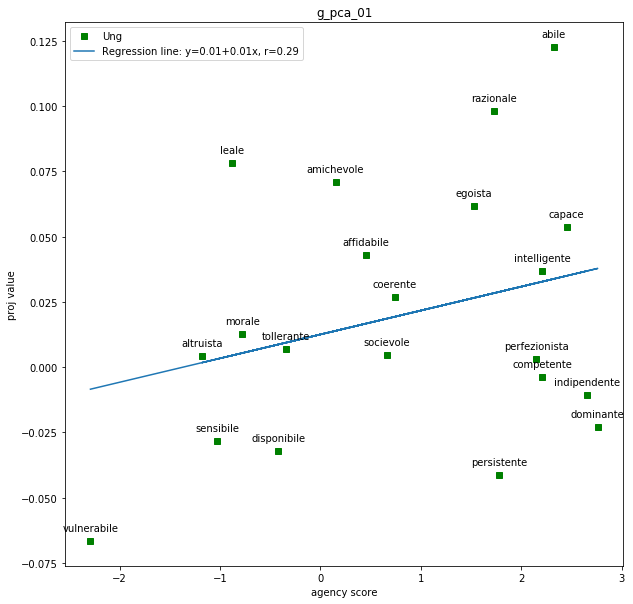

In [41]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col5, ag_com_ung_col3, linewidth=0, marker='s', color='green', label='Ung')
ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/ag/ft_g_pca_01')

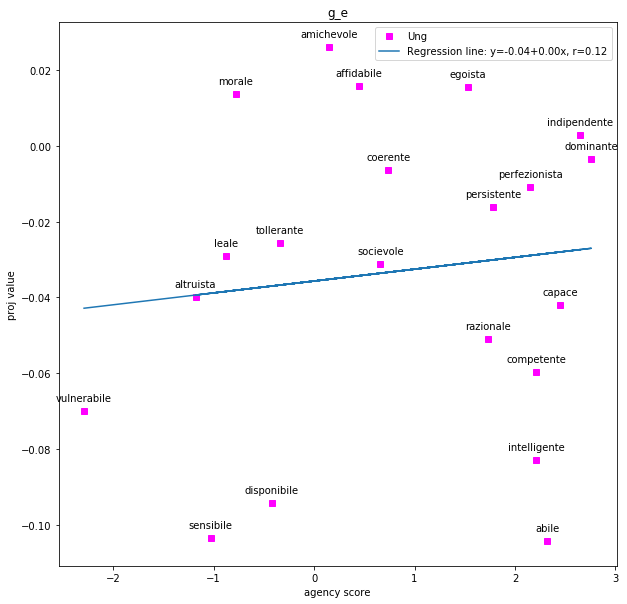

In [42]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col5, ag_com_ung_col4, linewidth=0, marker='s', color='magenta', label='Ung')
ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/ag/ft_g_e')

In [43]:
# communion correlation
r_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col1)[0]
r_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col2)[0]
r_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col3)[0]
r_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col4)[0]
p_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col1)[1]
p_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col2)[1]
p_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col3)[1]
p_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col4)[1]

In [44]:
pearson_data = {'g_diff':[r_ag_com_ung_g_diff,p_ag_com_ung_g_diff],
                'g_pca_0':[r_ag_com_ung_g_pca_0,p_ag_com_ung_g_pca_0],
                'g_pca_01':[r_ag_com_ung_g_pca_01,p_ag_com_ung_g_pca_01],
                'g_e':[r_ag_com_ung_g_e,p_ag_com_ung_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion ungendered correlation")
pearson_table

Communion ungendered correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.001922  0.022898  0.075703 -0.205316
p  0.993402  0.921519  0.744319  0.371949

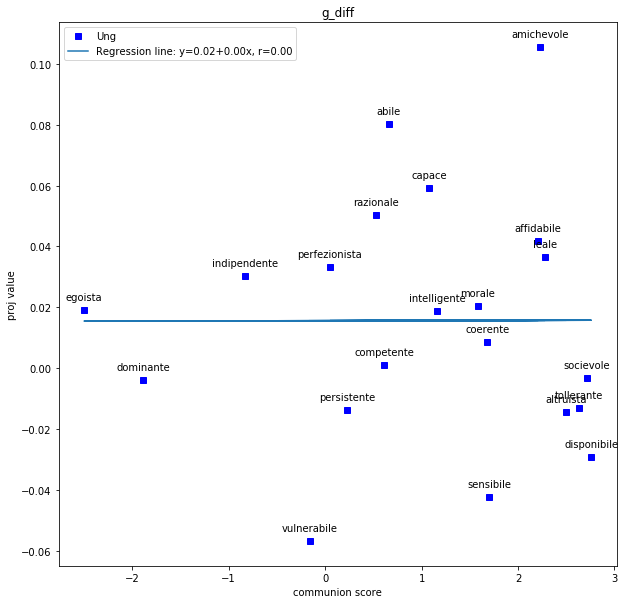

In [45]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col1, linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/com/ft_g_diff')

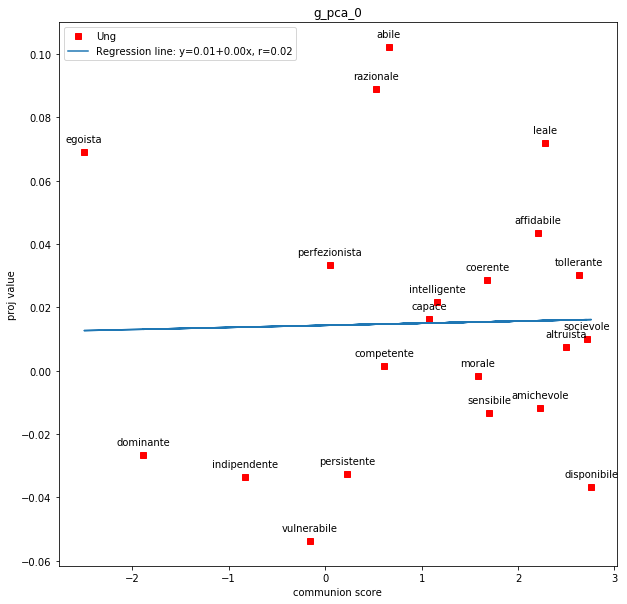

In [46]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col2, linewidth=0, marker='s', color='red', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/com/ft_g_pca_0')

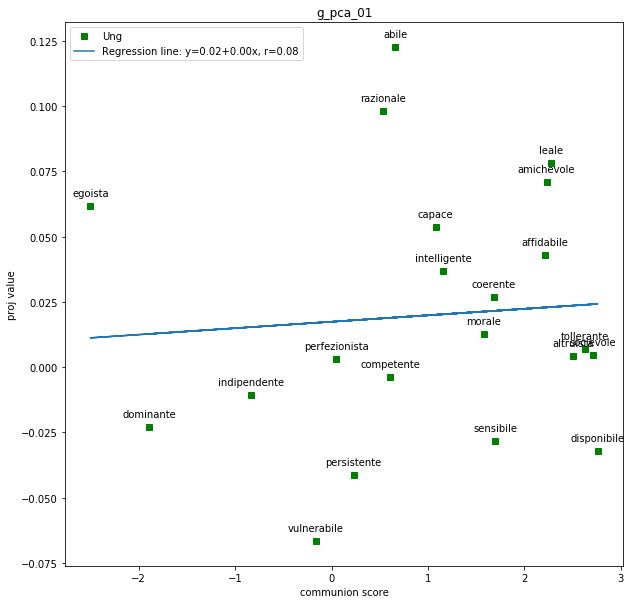

In [47]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col3, linewidth=0, marker='s', color='green', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/com/ft_g_pca_01')

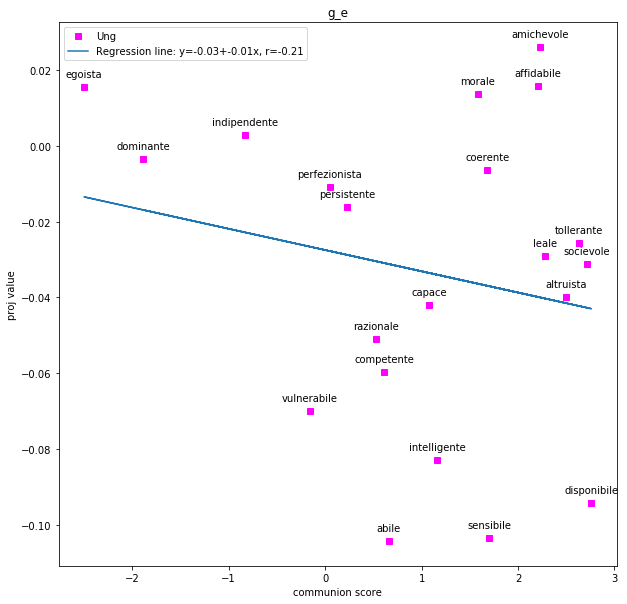

In [48]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col4, linewidth=0, marker='s', color='magenta', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/com/ft_g_e')

In [49]:
# agency-communion correlation
r_ag_com_ung_g_diff = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col1)[0]
r_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col2)[0]
r_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col3)[0]
r_ag_com_ung_g_e = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col4)[0]
p_ag_com_ung_g_diff = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col1)[1]
p_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col2)[1]
p_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col3)[1]
p_ag_com_ung_g_e = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col4)[1]

In [50]:
pearson_data = {'g_diff':[r_ag_com_ung_g_diff,p_ag_com_ung_g_diff],
                'g_pca_0':[r_ag_com_ung_g_pca_0,p_ag_com_ung_g_pca_0],
                'g_pca_01':[r_ag_com_ung_g_pca_01,p_ag_com_ung_g_pca_01],
                'g_e':[r_ag_com_ung_g_e,p_ag_com_ung_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion ungendered correlation")
pearson_table

Agency-Communion ungendered correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.259873  0.121599  0.122375  0.183515
p  0.255267  0.599535  0.597189  0.425874

##### Gendered words

In [36]:
# words
ag_com_gen = db.read('ag_com_gen_ita.txt', 'ag-com-mf')

In [37]:
# compute projections
# male
proj_ag_com_gen_m_g_diff =  db.prof_proj(E_ft, ag_com_gen, g_diff, 'ag-com-m')
proj_ag_com_gen_m_g_pca_0 =  db.prof_proj(E_ft, ag_com_gen, g_pca_0, 'ag-com-m')
proj_ag_com_gen_m_g_pca_01 =  db.prof_proj(E_ft, ag_com_gen, g_pca_01, 'ag-com-m')
proj_ag_com_gen_m_g_e =  db.prof_proj(E_ft, ag_com_gen, g_e, 'ag-com-m')

# female
proj_ag_com_gen_f_g_diff =  db.prof_proj(E_ft, ag_com_gen, g_diff, 'ag-com-f')
proj_ag_com_gen_f_g_pca_0 =  db.prof_proj(E_ft, ag_com_gen, g_pca_0, 'ag-com-f')
proj_ag_com_gen_f_g_pca_01 =  db.prof_proj(E_ft, ag_com_gen, g_pca_01, 'ag-com-f')
proj_ag_com_gen_f_g_e =  db.prof_proj(E_ft, ag_com_gen, g_e, 'ag-com-f')

In [38]:
# print ag_com_gen_m results
ag_com_gen_m_col0 = [] # pandas columns
ag_com_gen_m_col1 = []
ag_com_gen_m_col2 = []
ag_com_gen_m_col3 = []
ag_com_gen_m_col4 = []
ag_com_gen_m_col5 = []
ag_com_gen_m_col6 = []

for i in range(len(proj_ag_com_gen_m_g_diff)):
    ag_com_gen_m_col0.append(proj_ag_com_gen_m_g_diff[i][0]) # word
    ag_com_gen_m_col1.append(proj_ag_com_gen_m_g_diff[i][1]) # projection on g_diff
    ag_com_gen_m_col2.append(proj_ag_com_gen_m_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_gen_m_col3.append(proj_ag_com_gen_m_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_gen_m_col4.append(np.real(proj_ag_com_gen_m_g_e[i][1])) # projection on g_e
    ag_com_gen_m_col5.append(proj_ag_com_gen_m_g_diff[i][2])
    ag_com_gen_m_col6.append(proj_ag_com_gen_m_g_diff[i][3])

ag_com_gen_m_data = {'Word':ag_com_gen_m_col0, 
               'Proj g_diff':ag_com_gen_m_col1,
               'Proj g_pca_0':ag_com_gen_m_col2, 
               'Proj g_pca_01':ag_com_gen_m_col3,
               'Proj g_e':ag_com_gen_m_col4,
               'Agency':ag_com_gen_m_col5,
               'Communion':ag_com_gen_m_col6}

ag_com_gen_m_table = pd.DataFrame(ag_com_gen_m_data)
ag_com_gen_m_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0          attivo     0.133193      0.196107       0.180168 -0.056429    2.35   
1      affettuoso     0.059949      0.173368       0.126707  0.007737   -0.85   
2       ambizioso     0.152494      0.288911       0.251100 -0.012472    2.79   
3          deciso     0.033273      0.090033       0.046084 -0.009320    2.88   
4        vanitoso     0.105291      0.191813       0.171161 -0.027970    1.29   
5   confusionario     0.069705      0.196830       0.142547 -0.005169   -1.89   
6    comunicativo     0.085256      0.186069       0.156890  0.062600    1.50   
7     competitivo     0.072216      0.153743       0.123873  0.033614    2.71   
8     presuntuoso     0.112785      0.230236       0.198067 -0.019344    1.53   
9    coscienzioso     0.080623      0.233943       0.178483  0.031092    0.58   
10     rispettoso     0.003357      0.081186       0.073712 -0.005914   -0.35   
11       creativo     0.049542      0.171296       0.115495  0.069760    1.63   
12     distaccato     0.066982      0.107033       0.088526 -0.030023    1.61   
13    determinato     0.085489      0.161167       0.132144 -0.062205    2.73   
14         rigido     0.022966      0.143632       0.088457 -0.030998    0.38   
15        emotivo     0.002176      0.138984       0.072085  0.063686   -1.47   
16       energico     0.107926      0.225499       0.184724  0.010552    2.42   
17         giusto     0.019891      0.138324       0.074450 -0.059111   -0.50   
18      credulone     0.125345      0.171865       0.159805 -0.006169   -2.26   
19           duro     0.089801      0.173903       0.130718 -0.043526    1.95   
20         onesto     0.158445      0.283500       0.267362 -0.022697   -0.71   
21    industrioso     0.159034      0.236315       0.231860 -0.033190    2.33   
22       insicuro     0.120952      0.157534       0.152214  0.026473   -2.35   
23          pigro     0.132930      0.251297       0.207737 -0.074621   -2.45   
24       ostinato     0.148413      0.220851       0.209971 -0.021557    2.43   
25         aperto     0.050825      0.112805       0.113153 -0.058259    0.45   
26     estroverso     0.114540      0.196991       0.183171  0.046713    1.11   
27        educato     0.108748      0.212897       0.197991 -0.043156    0.13   
28      riservato     0.047410      0.050367       0.059830 -0.049909    0.11   
29    autocritico     0.066012      0.141519       0.136552  0.018264    0.25   
30       autonomo     0.075318      0.092021       0.104539 -0.029861    2.76   
31         timido     0.105173      0.243081       0.183726 -0.015340   -2.25   
32     combattivo     0.149672      0.195963       0.177682 -0.009558    2.55   
33       risoluto     0.098670      0.160693       0.130915  0.020413    2.48   
34     supportivo     0.000310      0.116058       0.051335  0.033857   -0.27   
35       empatico     0.015001      0.130771       0.090663  0.034731   -0.53   
36      fiducioso     0.143908      0.165501       0.183603  0.026379    0.23   
37    comprensivo     0.027580      0.111946       0.092656 -0.032888   -0.37   
38       vigoroso     0.099405      0.143381       0.128336 -0.002935    1.55   
39          caldo     0.017102      0.102418       0.047114 -0.028555    0.18   

    Communion  
0        1.55  
1        1.58  
2       -0.97  
3        0.43  
4       -1.18  
5       -0.95  
6        2.00  
7       -1.39  
8       -1.50  
9        1.32  
10       1.55  
11       0.79  
12      -2.03  
13       0.53  
14      -0.36  
15       1.37  
16       0.79  
17       1.95  
18      -0.26  
19      -1.15  
20       2.34  
21       0.28  
22       0.23  
23      -1.03  
24      -0.78  
25       2.05  
26       1.39  
27       1.92  
28      -1.00  
29       0.53  
30      -0.47  
31      -0.58  
32       0.35  
33       0.03  
34       1.87  
35       2.21  
36       2.15  
37       2.45  
38       0.10  
39       1.20

In [39]:
# ag_com_gen_m pearson correlation
# agency correlation
r_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col1)[0]
r_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col2)[0]
r_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col3)[0]
r_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col4)[0]
p_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col1)[1]
p_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col2)[1]
p_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col3)[1]
p_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col4)[1]

In [40]:
pearson_data = {'g_diff':[r_ag_com_gen_m_g_diff,p_ag_com_gen_m_g_diff],
                'g_pca_0':[r_ag_com_gen_m_g_pca_0,p_ag_com_gen_m_g_pca_0],
                'g_pca_01':[r_ag_com_gen_m_g_pca_01,p_ag_com_gen_m_g_pca_01],
                'g_e':[r_ag_com_gen_m_g_e,p_ag_com_gen_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency male correlation")
pearson_table

Agency male correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.213864  0.011161  0.091556 -0.037118
p  0.185140  0.945503  0.574203  0.820121

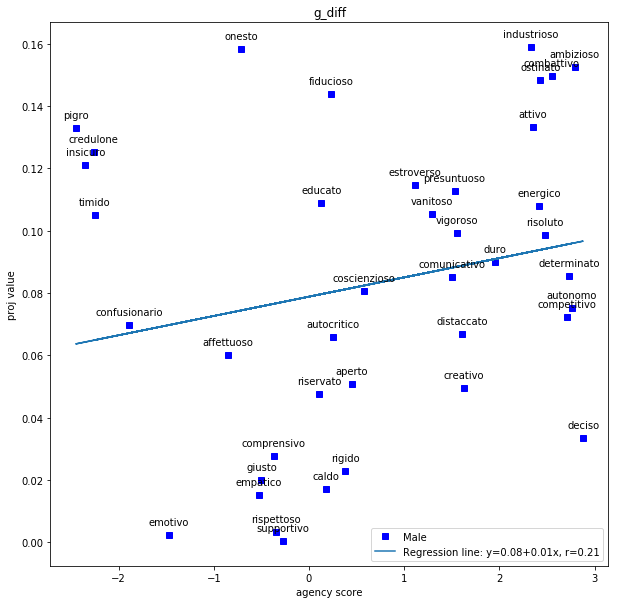

In [56]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/ag/ft_g_diff')

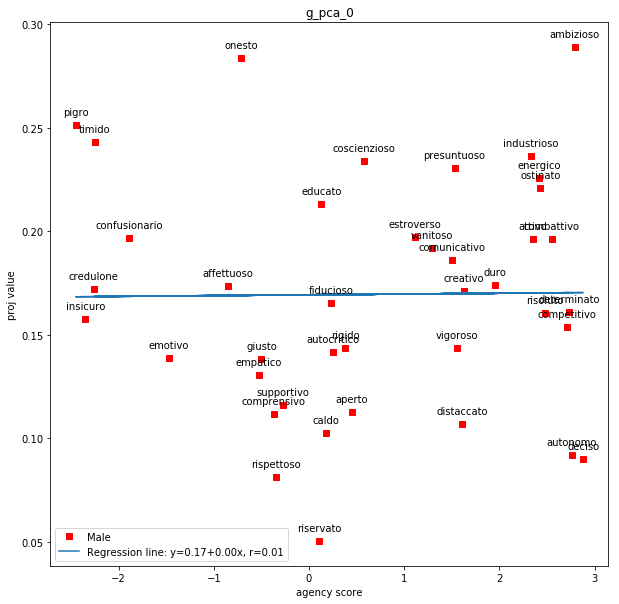

In [57]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col2, linewidth=0, marker='s', color='red', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/ag/ft_g_pca_0')

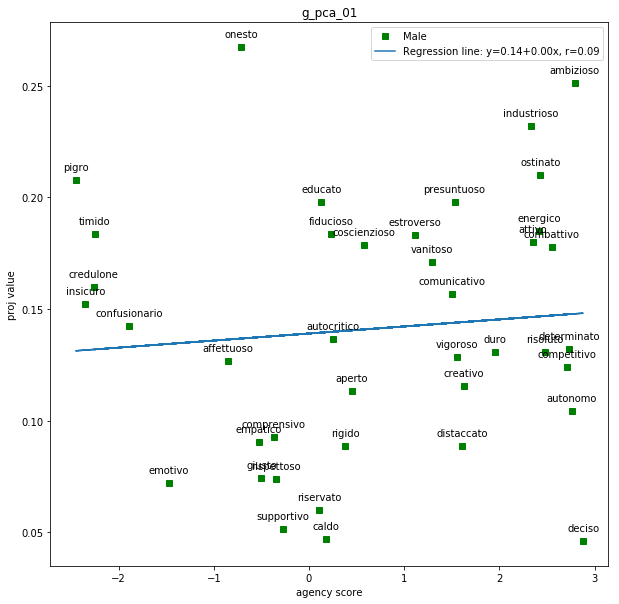

In [58]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col3, linewidth=0, marker='s', color='green', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/ag/ft_g_pca_01')

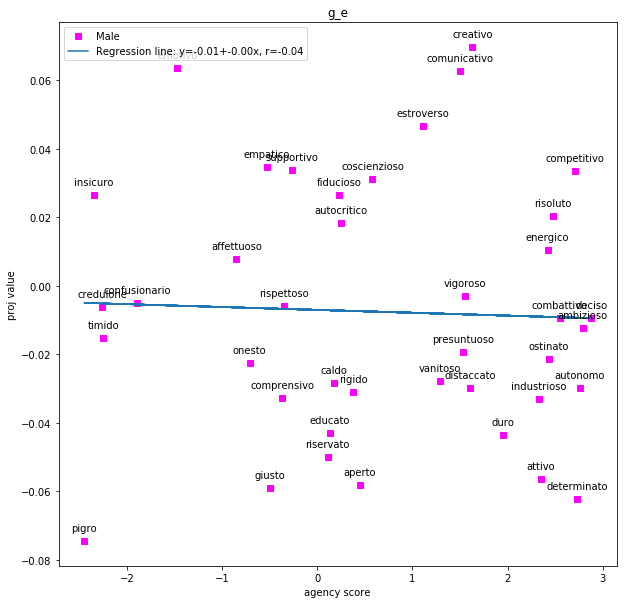

In [61]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col4, linewidth=0, marker='s', color='magenta', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/ag/ft_g_e')

In [62]:
# communion correlation
r_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col1)[0]
r_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col2)[0]
r_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col3)[0]
r_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col4)[0]
p_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col1)[1]
p_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col2)[1]
p_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col3)[1]
p_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col4)[1]

In [63]:
pearson_data = {'g_diff':[r_ag_com_gen_m_g_diff,p_ag_com_gen_m_g_diff],
                'g_pca_0':[r_ag_com_gen_m_g_pca_0,p_ag_com_gen_m_g_pca_0],
                'g_pca_01':[r_ag_com_gen_m_g_pca_01,p_ag_com_gen_m_g_pca_01],
                'g_e':[r_ag_com_gen_m_g_e,p_ag_com_gen_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion male correlation")
pearson_table

Communion male correlation


g_diff   g_pca_0  g_pca_01       g_e
r -0.265658 -0.115576 -0.120245  0.240533
p  0.097557  0.477598  0.459864  0.134895

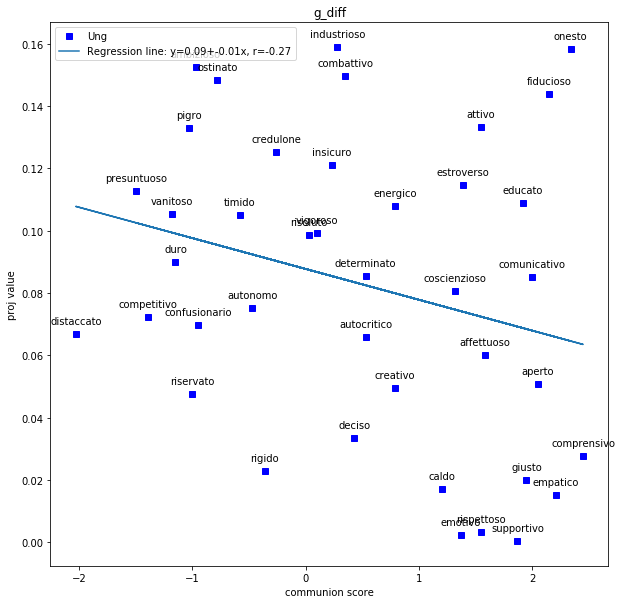

In [64]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/com/ft_g_diff')

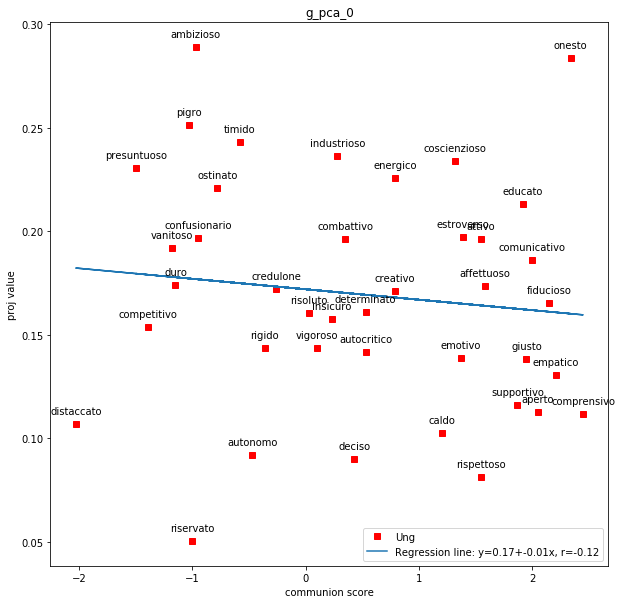

In [65]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col2, linewidth=0, marker='s', color='red', label='Ung')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/com/ft_g_pca_0')

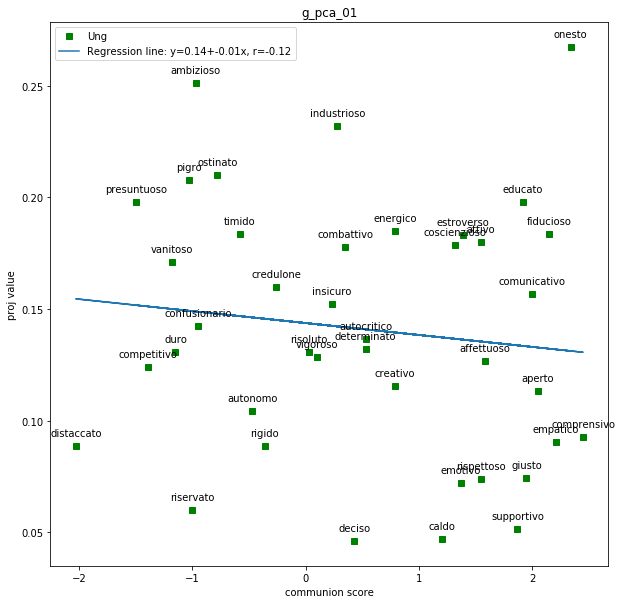

In [66]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col3, linewidth=0, marker='s', color='green', label='Ung')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/com/ft_g_pca_01')

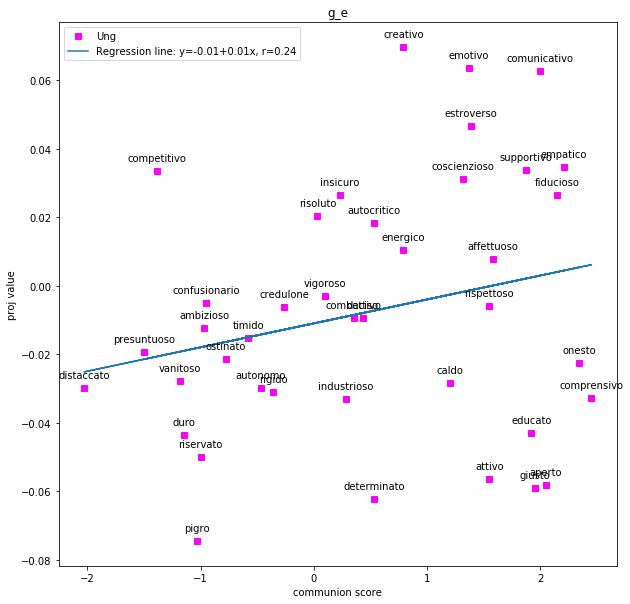

In [67]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col4, linewidth=0, marker='s', color='magenta', label='Ung')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/com/ft_g_e')

In [68]:
# agency-communion correlation
r_ag_com_gen_m_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col1)[0]
r_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col2)[0]
r_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col3)[0]
r_ag_com_gen_m_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col4)[0]
p_ag_com_gen_m_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col1)[1]
p_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col2)[1]
p_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col3)[1]
p_ag_com_gen_m_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col4)[1]

In [69]:
pearson_data = {'g_diff':[r_ag_com_gen_m_g_diff,p_ag_com_gen_m_g_diff],
                'g_pca_0':[r_ag_com_gen_m_g_pca_0,p_ag_com_gen_m_g_pca_0],
                'g_pca_01':[r_ag_com_gen_m_g_pca_01,p_ag_com_gen_m_g_pca_01],
                'g_e':[r_ag_com_gen_m_g_e,p_ag_com_gen_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion male correlation")
pearson_table

Agency-Communion male correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.302937  0.072786  0.133339 -0.161490
p  0.057419  0.655356  0.412079  0.319485

In [41]:
# print ag_com_gen_f results
ag_com_gen_f_col0 = [] # pandas columns
ag_com_gen_f_col1 = []
ag_com_gen_f_col2 = []
ag_com_gen_f_col3 = []
ag_com_gen_f_col4 = []
ag_com_gen_f_col5 = []
ag_com_gen_f_col6 = []

for i in range(len(proj_ag_com_gen_f_g_diff)):
    ag_com_gen_f_col0.append(proj_ag_com_gen_f_g_diff[i][0]) # word
    ag_com_gen_f_col1.append(proj_ag_com_gen_f_g_diff[i][1]) # projection on g_diff
    ag_com_gen_f_col2.append(proj_ag_com_gen_f_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_gen_f_col3.append(proj_ag_com_gen_f_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_gen_f_col4.append(np.real(proj_ag_com_gen_f_g_e[i][1])) # projection on g_e
    ag_com_gen_f_col5.append(proj_ag_com_gen_f_g_diff[i][2])
    ag_com_gen_f_col6.append(proj_ag_com_gen_f_g_diff[i][3])

ag_com_gen_f_data = {'Word':ag_com_gen_f_col0, 
               'Proj g_diff':ag_com_gen_f_col1,
               'Proj g_pca_0':ag_com_gen_f_col2, 
               'Proj g_pca_01':ag_com_gen_f_col3,
               'Proj g_e':ag_com_gen_f_col4,
               'Agency':ag_com_gen_f_col5,
               'Communion':ag_com_gen_f_col6}

ag_com_gen_f_table = pd.DataFrame(ag_com_gen_f_data)
ag_com_gen_f_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0          attiva    -0.064096     -0.168159      -0.144804 -0.067533    2.35   
1      affettuosa    -0.090580     -0.210513      -0.164882  0.021044   -0.85   
2       ambiziosa    -0.092678     -0.189249      -0.159715 -0.005288    2.79   
3          decisa    -0.067846     -0.143159      -0.145939 -0.013854    2.88   
4        vanitosa    -0.198017     -0.249589      -0.267793 -0.073265    1.29   
5   confusionaria    -0.055924     -0.151937      -0.139887 -0.011241   -1.89   
6    comunicativa    -0.036487     -0.132258      -0.091725  0.047612    1.50   
7     competitiva    -0.047236     -0.134371      -0.120322  0.011940    2.71   
8     presuntuosa    -0.155129     -0.225394      -0.213209 -0.021986    1.53   
9    coscienziosa    -0.143502     -0.191816      -0.193955 -0.012083    0.58   
10     rispettosa    -0.134849     -0.164942      -0.158365 -0.046200   -0.35   
11       creativa    -0.091441     -0.177857      -0.161179  0.046455    1.63   
12     distaccata    -0.091450     -0.167649      -0.154857 -0.036183    1.61   
13    determinata    -0.125456     -0.214665      -0.196158 -0.065687    2.73   
14         rigida    -0.062169     -0.164229      -0.147526 -0.019134    0.38   
15        emotiva    -0.061101     -0.149022      -0.111107  0.017567   -1.47   
16       energica    -0.131609     -0.223658      -0.198947  0.025520    2.42   
17         giusta     0.061748     -0.100659      -0.034911 -0.059111   -0.50   
18      credulona    -0.205024     -0.276244      -0.276607 -0.003974   -2.26   
19           dura     0.003049     -0.119388      -0.085342 -0.043526    1.95   
20         onesta    -0.095098     -0.199431      -0.145683 -0.023121   -0.71   
21    industriosa    -0.024405     -0.160201      -0.086158 -0.016591    2.33   
22       insicura    -0.173446     -0.207040      -0.223097  0.013077   -2.35   
23          pigra    -0.199196     -0.265479      -0.286964 -0.087222   -2.45   
24       ostinata    -0.113738     -0.193593      -0.155859 -0.001751    2.43   
25         aperta     0.004460     -0.134219      -0.075228  0.007150    0.45   
26     estroversa    -0.163531     -0.192500      -0.209803  0.041504    1.11   
27        educata    -0.221699     -0.202325      -0.236916 -0.014527    0.13   
28      riservata    -0.035033     -0.143213      -0.101787 -0.073600    0.11   
29    autocritica     0.005914     -0.072324      -0.018932  0.030559    0.25   
30       autonoma    -0.035046     -0.159707      -0.110293 -0.033185    2.76   
31         timida    -0.207141     -0.286209      -0.276456 -0.000365   -2.25   
32     combattiva    -0.178293     -0.275298      -0.272439  0.004155    2.55   
33       risoluta    -0.152763     -0.222964      -0.232113  0.017709    2.48   
34     supportiva    -0.088468     -0.149245      -0.148336  0.050885   -0.27   
35       empatica    -0.101236     -0.168265      -0.147678  0.011193   -0.53   
36      fiduciosa    -0.178774     -0.183009      -0.206977  0.024811    0.23   
37    comprensiva    -0.128827     -0.139335      -0.153598 -0.062515   -0.37   
38       vigorosa    -0.005079     -0.185500      -0.105629 -0.010991    1.55   
39          calda    -0.069053     -0.216232      -0.151595 -0.028555    0.18   

    Communion  
0        1.55  
1        1.58  
2       -0.97  
3        0.43  
4       -1.18  
5       -0.95  
6        2.00  
7       -1.39  
8       -1.50  
9        1.32  
10       1.55  
11       0.79  
12      -2.03  
13       0.53  
14      -0.36  
15       1.37  
16       0.79  
17       1.95  
18      -0.26  
19      -1.15  
20       2.34  
21       0.28  
22       0.23  
23      -1.03  
24      -0.78  
25       2.05  
26       1.39  
27       1.92  
28      -1.00  
29       0.53  
30      -0.47  
31      -0.58  
32       0.35  
33       0.03  
34       1.87  
35       2.21  
36       2.15  
37       2.45  
38       0.10  
39       1.20

In [42]:
# ag_com_gen_f pearson correlation
# agency correlation
r_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col1)[0]
r_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col2)[0]
r_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col3)[0]
r_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col4)[0]
p_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col1)[1]
p_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col2)[1]
p_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col3)[1]
p_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col4)[1]

In [43]:
pearson_data = {'g_diff':[r_ag_com_gen_f_g_diff,p_ag_com_gen_f_g_diff],
                'g_pca_0':[r_ag_com_gen_f_g_pca_0,p_ag_com_gen_f_g_pca_0],
                'g_pca_01':[r_ag_com_gen_f_g_pca_01,p_ag_com_gen_f_g_pca_01],
                'g_e':[r_ag_com_gen_f_g_e,p_ag_com_gen_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency female correlation")
pearson_table

Agency female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.239631  0.160357  0.196285  0.024084
p  0.136409  0.322936  0.224786  0.882728

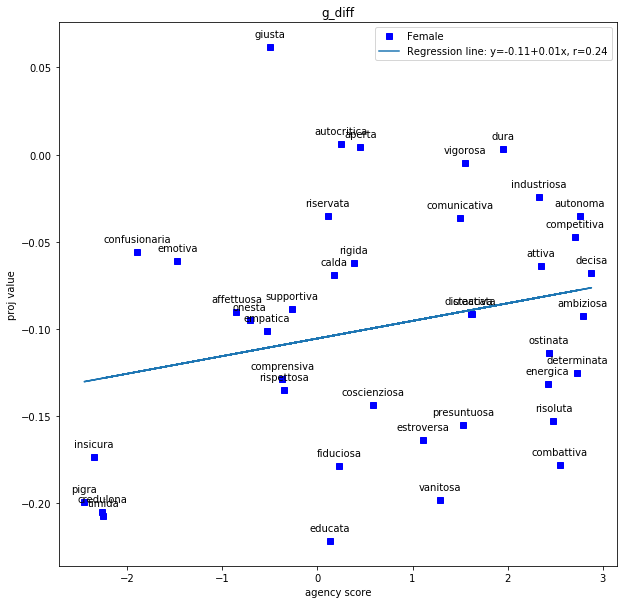

In [73]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col1, linewidth=0, marker='s', color='blue', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/ag/ft_g_diff')

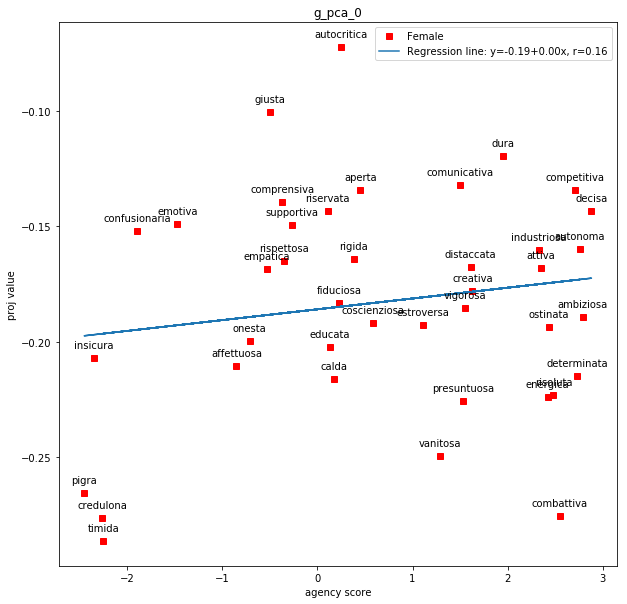

In [74]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col2, linewidth=0, marker='s', color='red', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/ag/ft_g_pca_0')

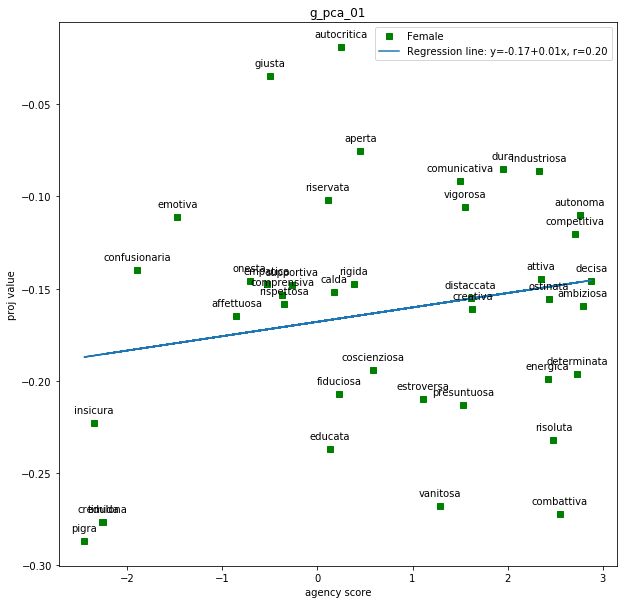

In [75]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col3, linewidth=0, marker='s', color='green', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/ag/ft_g_pca_01')

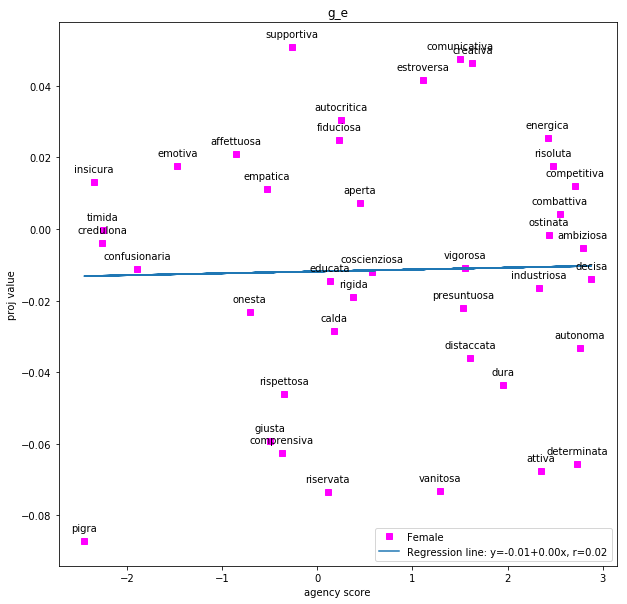

In [76]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col4, linewidth=0, marker='s', color='magenta', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/ag/ft_g_e')

In [77]:
# communion correlation
r_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col1)[0]
r_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col2)[0]
r_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col3)[0]
r_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col4)[0]
p_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col1)[1]
p_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col2)[1]
p_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col3)[1]
p_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col4)[1]

In [78]:
pearson_data = {'g_diff':[r_ag_com_gen_f_g_diff,p_ag_com_gen_f_g_diff],
                'g_pca_0':[r_ag_com_gen_f_g_pca_0,p_ag_com_gen_f_g_pca_0],
                'g_pca_01':[r_ag_com_gen_f_g_pca_01,p_ag_com_gen_f_g_pca_01],
                'g_e':[r_ag_com_gen_f_g_e,p_ag_com_gen_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion female correlation")
pearson_table

Communion female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.059850  0.225373  0.188814  0.278812
p  0.713729  0.162039  0.243280  0.081477

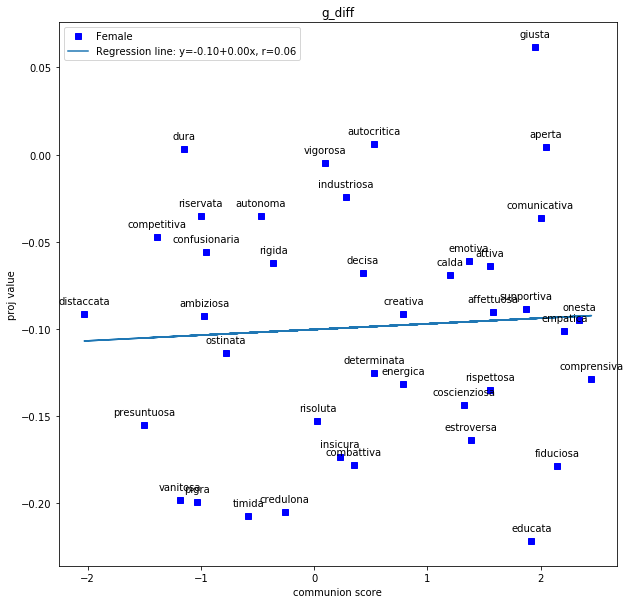

In [79]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col1, linewidth=0, marker='s', color='blue', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/com/ft_g_diff')

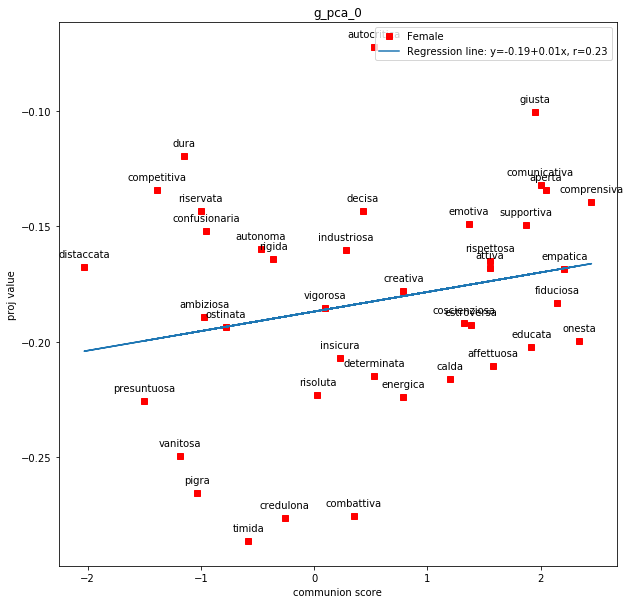

In [80]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col2, linewidth=0, marker='s', color='red', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/com/ft_g_pca_0')

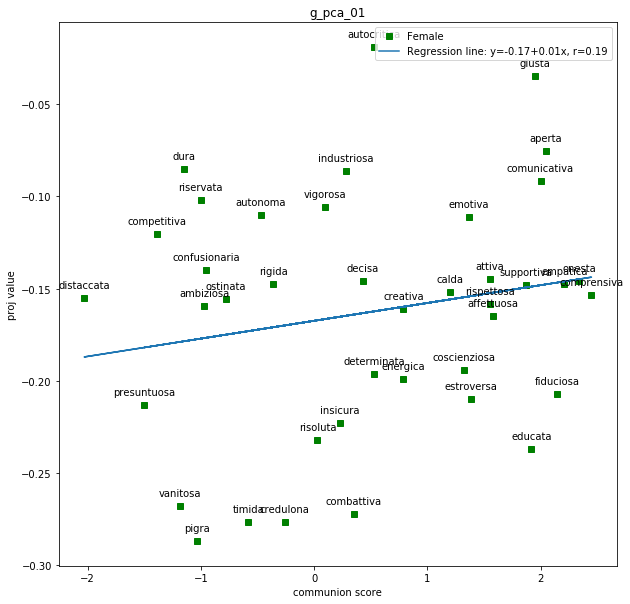

In [81]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col3, linewidth=0, marker='s', color='green', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/com/ft_g_pca_01')

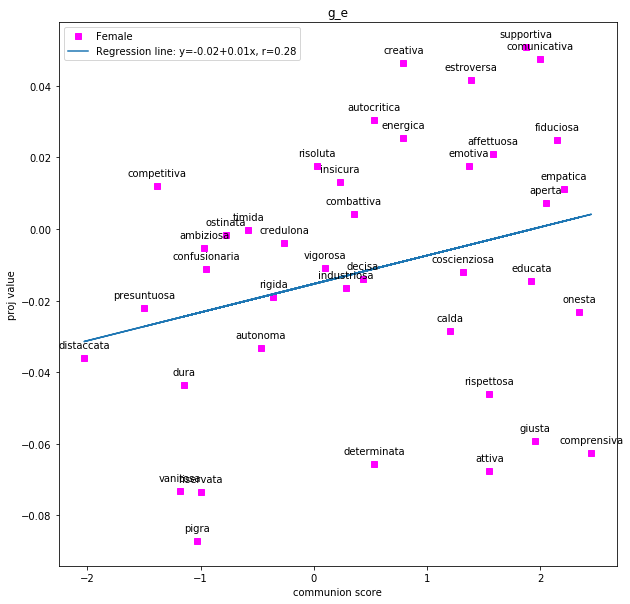

In [82]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col4, linewidth=0, marker='s', color='magenta', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/com/ft_g_e')

In [83]:
# agency-communion correlation
r_ag_com_gen_f_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col1)[0]
r_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col2)[0]
r_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col3)[0]
r_ag_com_gen_f_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col4)[0]
p_ag_com_gen_f_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col1)[1]
p_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col2)[1]
p_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col3)[1]
p_ag_com_gen_f_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col4)[1]

In [84]:
pearson_data = {'g_diff':[r_ag_com_gen_f_g_diff,p_ag_com_gen_f_g_diff],
                'g_pca_0':[r_ag_com_gen_f_g_pca_0,p_ag_com_gen_f_g_pca_0],
                'g_pca_01':[r_ag_com_gen_f_g_pca_01,p_ag_com_gen_f_g_pca_01],
                'g_e':[r_ag_com_gen_f_g_e,p_ag_com_gen_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion female correlation")
pearson_table

Agency-Communion female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.139166 -0.010685  0.035686 -0.138826
p  0.391759  0.947826  0.826953  0.392927

In [85]:
# both male and female agency plot

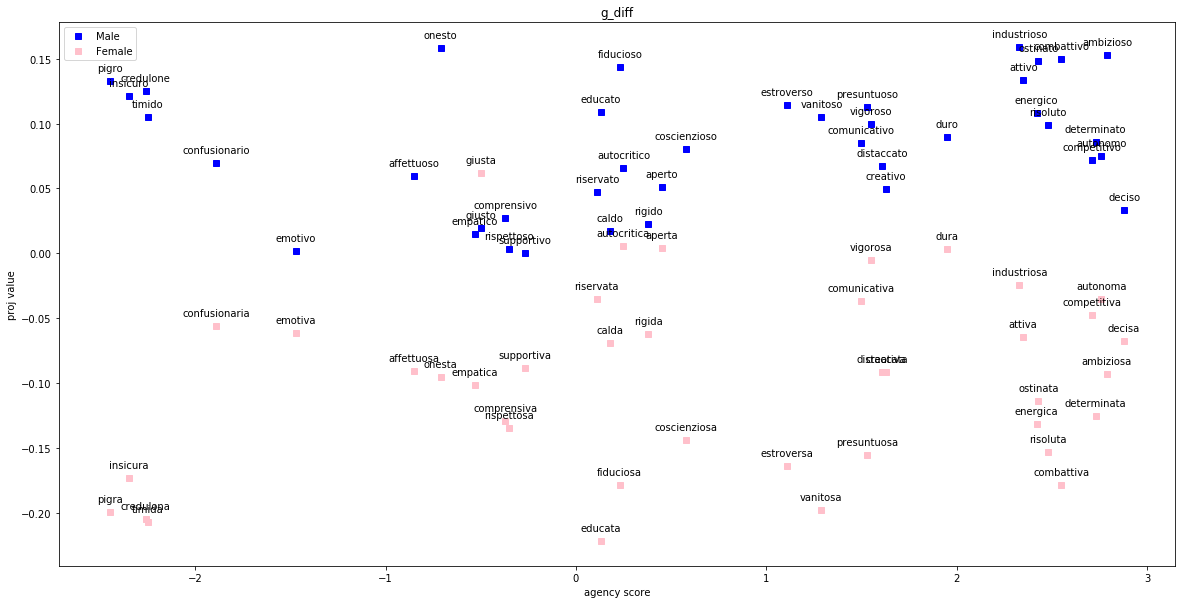

In [86]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col1, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/ag/ft_g_diff')

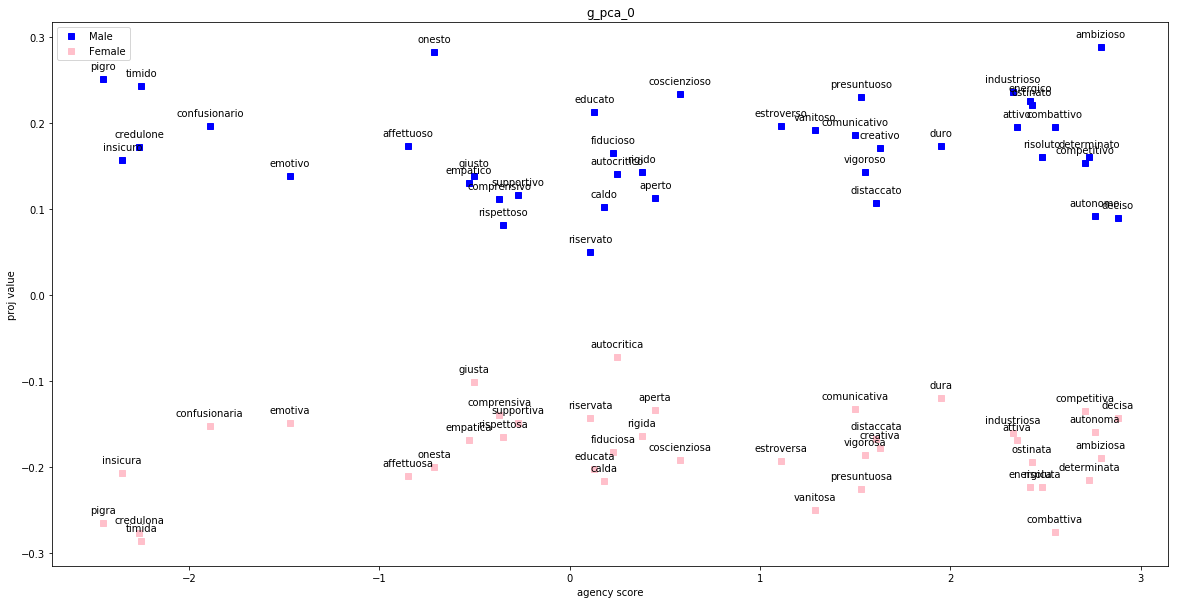

In [87]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col2, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col2, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/ag/ft_g_pca_0')

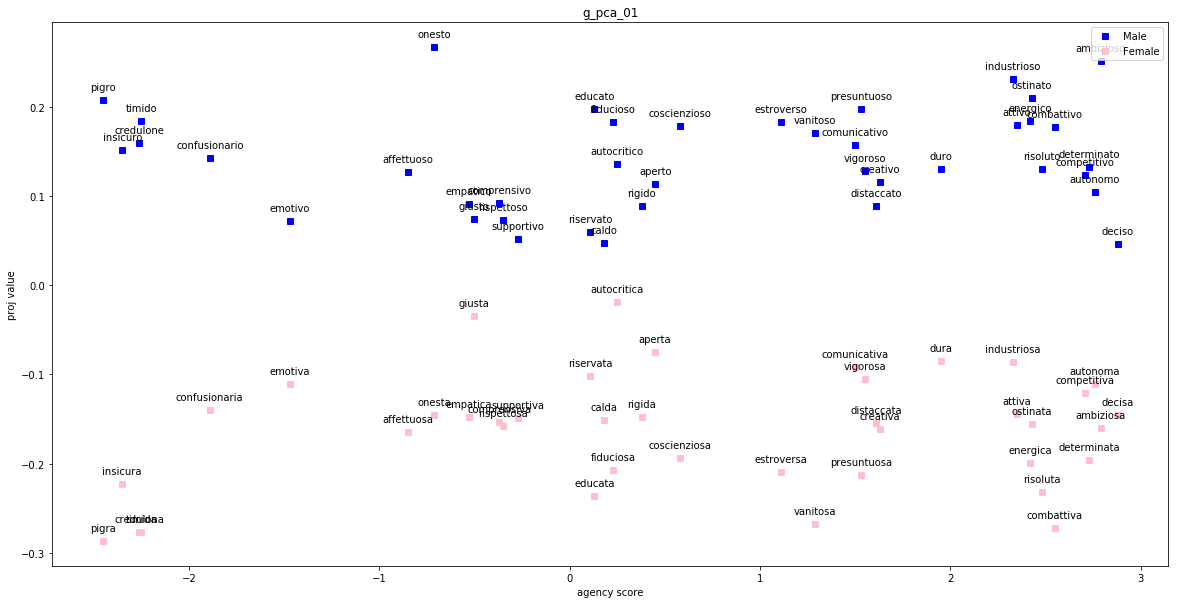

In [88]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col3, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col3, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/ag/ft_g_pca_01')

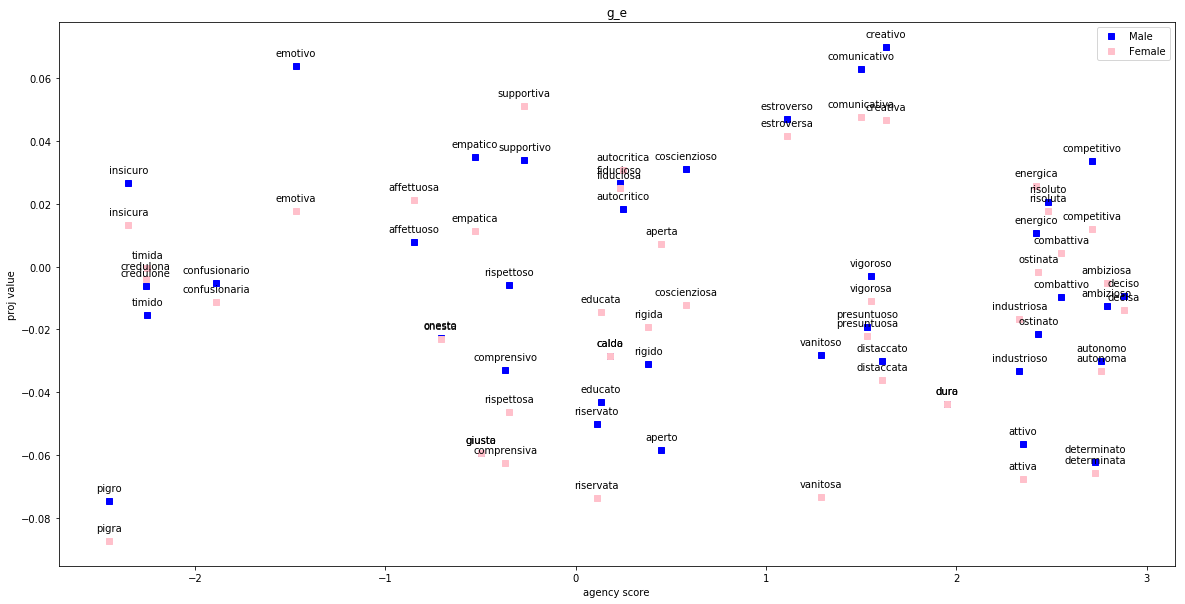

In [89]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col4, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col4, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/ag/ft_g_e')

In [90]:
# both male and female communion plot

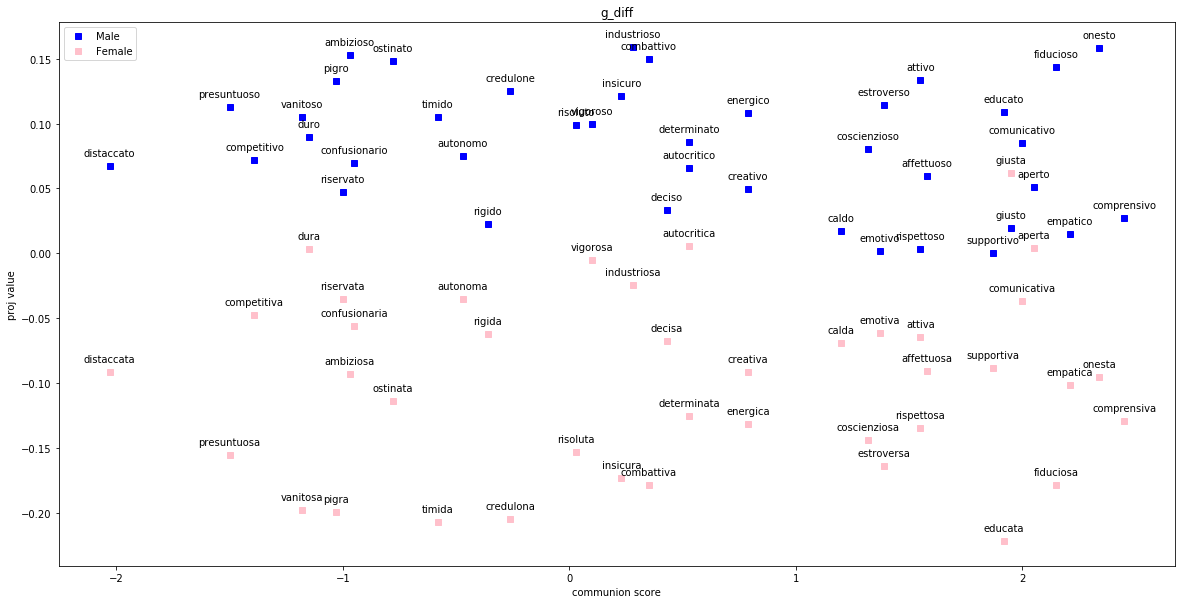

In [91]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col1, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/com/ft_g_diff')

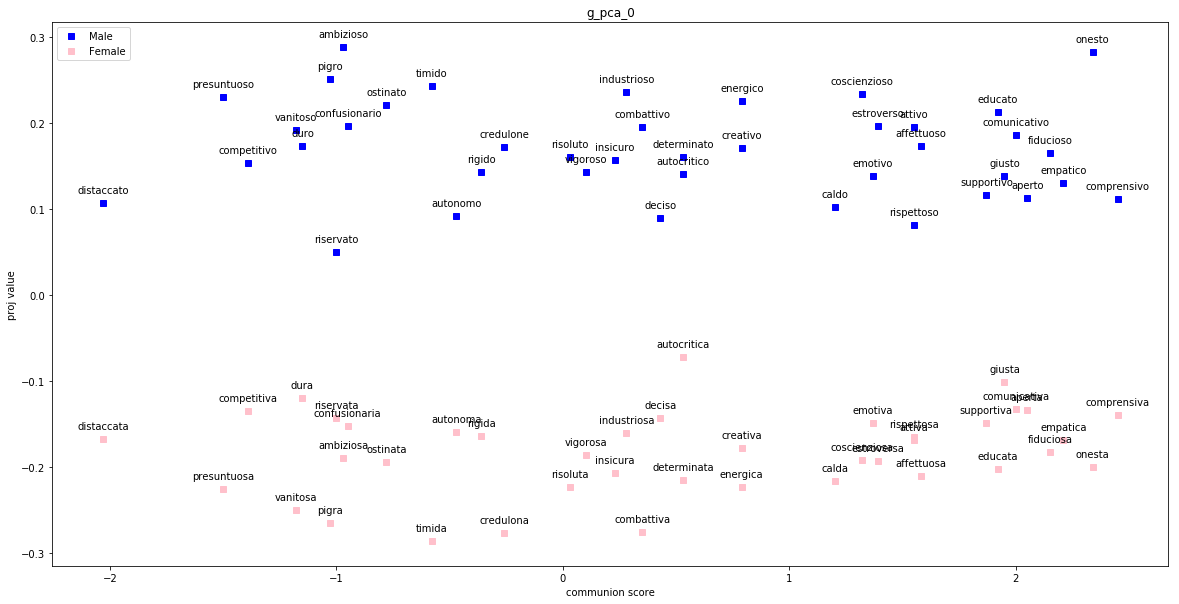

In [92]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col2, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col2, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/com/ft_g_pca_0')

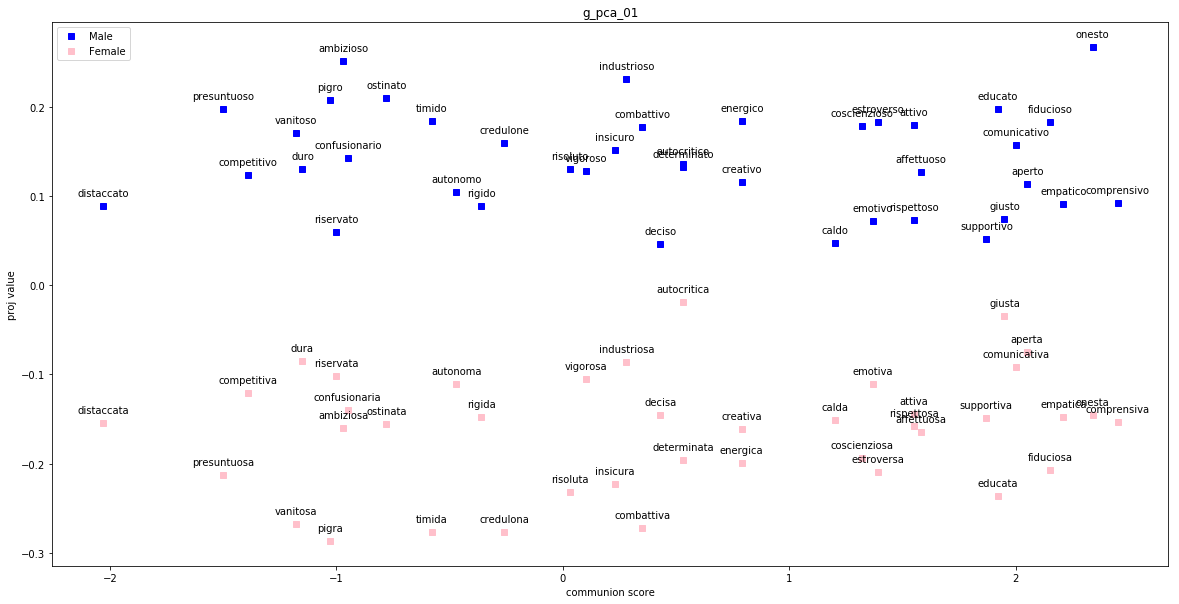

In [93]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col3, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col3, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/com/ft_g_pca_01')

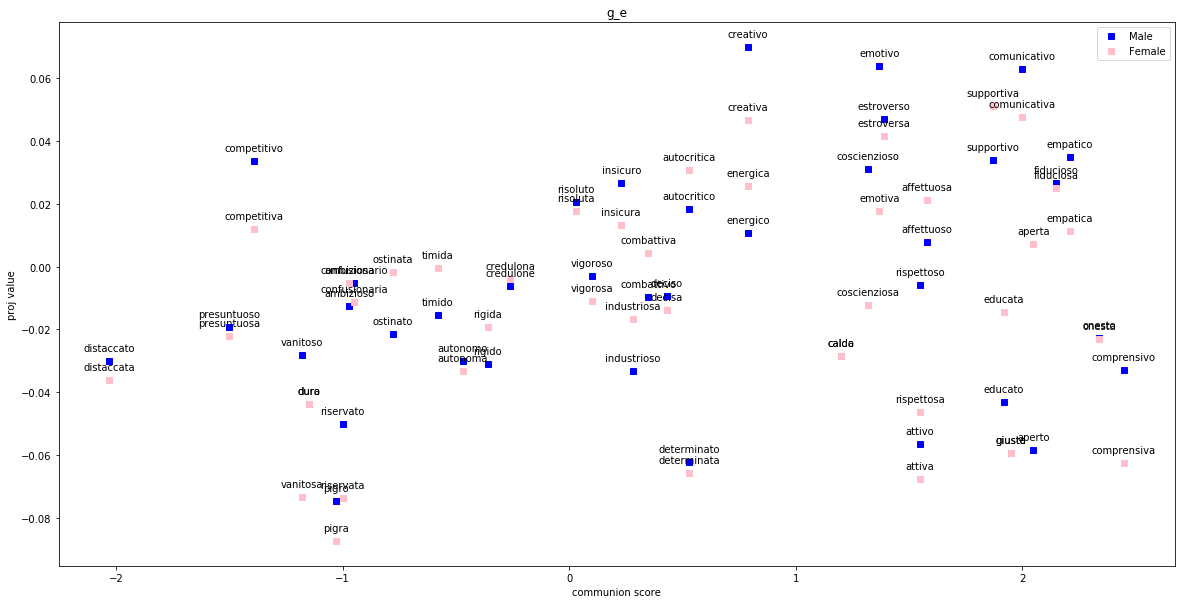

In [94]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col4, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col4, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/com/ft_g_e')

##### Ungendered + mean gendered words

In [44]:
# print ag_com_mean results
ag_com_mean_col0 = [] # pandas columns
ag_com_mean_col1 = []
ag_com_mean_col2 = []
ag_com_mean_col3 = []
ag_com_mean_col4 = []
ag_com_mean_col5 = []
ag_com_mean_col6 = []

for i in range(len(proj_ag_com_ung_g_diff)):
    ag_com_mean_col0.append(proj_ag_com_ung_g_diff[i][0]) # word
    ag_com_mean_col1.append(proj_ag_com_ung_g_diff[i][1]) # projection on g_diff
    ag_com_mean_col2.append(proj_ag_com_ung_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_mean_col3.append(proj_ag_com_ung_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_mean_col4.append(np.real(proj_ag_com_ung_g_e[i][1])) # projection on g_e
    ag_com_mean_col5.append(proj_ag_com_ung_g_diff[i][2])
    ag_com_mean_col6.append(proj_ag_com_ung_g_diff[i][3])
    
for i in range(len(proj_ag_com_gen_m_g_diff)):
    ag_com_mean_col0.append(proj_ag_com_gen_m_g_diff[i][0]) # word
    ag_com_mean_col1.append((proj_ag_com_gen_m_g_diff[i][1]+proj_ag_com_gen_f_g_diff[i][1])/2) # projection on g_diff
    ag_com_mean_col2.append((proj_ag_com_gen_m_g_pca_0[i][1]+proj_ag_com_gen_f_g_pca_0[i][1])/2) # projection on g_pca_0
    ag_com_mean_col3.append((proj_ag_com_gen_m_g_pca_01[i][1]+proj_ag_com_gen_f_g_pca_01[i][1])/2) # projection on g_pca_01
    ag_com_mean_col4.append((np.real(proj_ag_com_gen_m_g_e[i][1])+np.real(proj_ag_com_gen_f_g_e[i][1]))/2) # projection on g_e
    ag_com_mean_col5.append(proj_ag_com_gen_m_g_diff[i][2])
    ag_com_mean_col6.append(proj_ag_com_gen_m_g_diff[i][3])   

ag_com_mean_data = {'Word':ag_com_mean_col0, 
               'Proj g_diff':ag_com_mean_col1,
               'Proj g_pca_0':ag_com_mean_col2, 
               'Proj g_pca_01':ag_com_mean_col3,
               'Proj g_e':ag_com_mean_col4,
               'Agency':ag_com_mean_col5,
               'Communion':ag_com_mean_col6}

ag_com_mean_table = pd.DataFrame(ag_com_mean_data)
ag_com_mean_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0           abile     0.080335      0.102190       0.122643 -0.104315    2.32   
1       altruista    -0.014515      0.007354       0.004393 -0.039926   -1.18   
2          capace     0.059239      0.016343       0.053817 -0.042131    2.45   
3      competente     0.001019      0.001375      -0.003906 -0.059758    2.21   
4        coerente     0.008640      0.028646       0.026779 -0.006384    0.74   
5       dominante    -0.003824     -0.026552      -0.022917 -0.003409    2.76   
6      amichevole     0.105541     -0.011900       0.071073  0.026077    0.15   
7     disponibile    -0.029067     -0.036633      -0.032159 -0.094269   -0.42   
8         egoista     0.019207      0.068976       0.061825  0.015381    1.53   
9    indipendente     0.030305     -0.033587      -0.010550  0.002886    2.65   
10   intelligente     0.018959      0.021584       0.036714 -0.082862    2.21   
11          leale     0.036705      0.071928       0.078136 -0.029000   -0.88   
12         morale     0.020409     -0.001598       0.012607  0.013637   -0.78   
13  perfezionista     0.033121      0.033435       0.003049 -0.010791    2.15   
14    persistente    -0.013694     -0.032687      -0.041319 -0.016172    1.78   
15      razionale     0.050378      0.088966       0.098017 -0.051103    1.73   
16     affidabile     0.041913      0.043473       0.042771  0.015663    0.45   
17      sensibile    -0.042295     -0.013248      -0.028098 -0.103465   -1.03   
18      socievole    -0.003064      0.009935       0.004534 -0.031136    0.66   
19     tollerante    -0.013130      0.030258       0.006962 -0.025656   -0.34   
20    vulnerabile    -0.056750     -0.053787      -0.066607 -0.070118   -2.29   
21         attivo     0.034549      0.013974       0.017682 -0.061981    2.35   
22     affettuoso    -0.015315     -0.018572      -0.019087  0.014390   -0.85   
23      ambizioso     0.029908      0.049831       0.045692 -0.008880    2.79   
24         deciso    -0.017287     -0.026563      -0.049928 -0.011587    2.88   
25       vanitoso    -0.046363     -0.028888      -0.048316 -0.050617    1.29   
26  confusionario     0.006891      0.022446       0.001330 -0.008205   -1.89   
27   comunicativo     0.024384      0.026905       0.032582  0.055106    1.50   
28    competitivo     0.012490      0.009686       0.001775  0.022777    2.71   
29    presuntuoso    -0.021172      0.002421      -0.007571 -0.020665    1.53   
..            ...          ...           ...            ...       ...     ...   
31     rispettoso    -0.065746     -0.041878      -0.042326 -0.026057   -0.35   
32       creativo    -0.020949     -0.003280      -0.022842  0.058107    1.63   
33     distaccato    -0.012234     -0.030308      -0.033165 -0.033103    1.61   
34    determinato    -0.019983     -0.026749      -0.032007 -0.063946    2.73   
35         rigido    -0.019602     -0.010299      -0.029534 -0.025066    0.38   
36        emotivo    -0.029462     -0.005019      -0.019511  0.040627   -1.47   
37       energico    -0.011841      0.000920      -0.007111  0.018036    2.42   
38         giusto     0.040819      0.018832       0.019769 -0.059111   -0.50   
39      credulone    -0.039840     -0.052189      -0.058401 -0.005071   -2.26   
40           duro     0.046425      0.027257       0.022688 -0.043526    1.95   
41         onesto     0.031674      0.042034       0.060840 -0.022909   -0.71   
42    industrioso     0.067314      0.038057       0.072851 -0.024891    2.33   
43       insicuro    -0.026247     -0.024753      -0.035441  0.019775   -2.35   
44          pigro    -0.033133     -0.007091      -0.039614 -0.080921   -2.45   
45       ostinato     0.017337      0.013629       0.027056 -0.011654    2.43   
46         aperto     0.027642     -0.010707       0.018963 -0.025554    0.45   
47     estroverso    -0.024495      0.002245      -0.013316  0.044109    1.11   
48        educato    -0.056475      0.005286

In [45]:
# ag_com_mean pearson correlation
# agency correlation
r_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col1)[0]
r_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col2)[0]
r_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col3)[0]
r_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col4)[0]
p_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col1)[1]
p_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col2)[1]
p_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col3)[1]
p_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col4)[1]

In [46]:
pearson_data = {'g_diff':[r_ag_com_mean_g_diff,p_ag_com_mean_g_diff],
                'g_pca_0':[r_ag_com_mean_g_pca_0,p_ag_com_mean_g_pca_0],
                'g_pca_01':[r_ag_com_mean_g_pca_01,p_ag_com_mean_g_pca_01],
                'g_e':[r_ag_com_mean_g_e,p_ag_com_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency mean correlation")
pearson_table

Agency mean correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.408688  0.185535  0.264132  0.022708
p  0.001076  0.152269  0.039692  0.862098

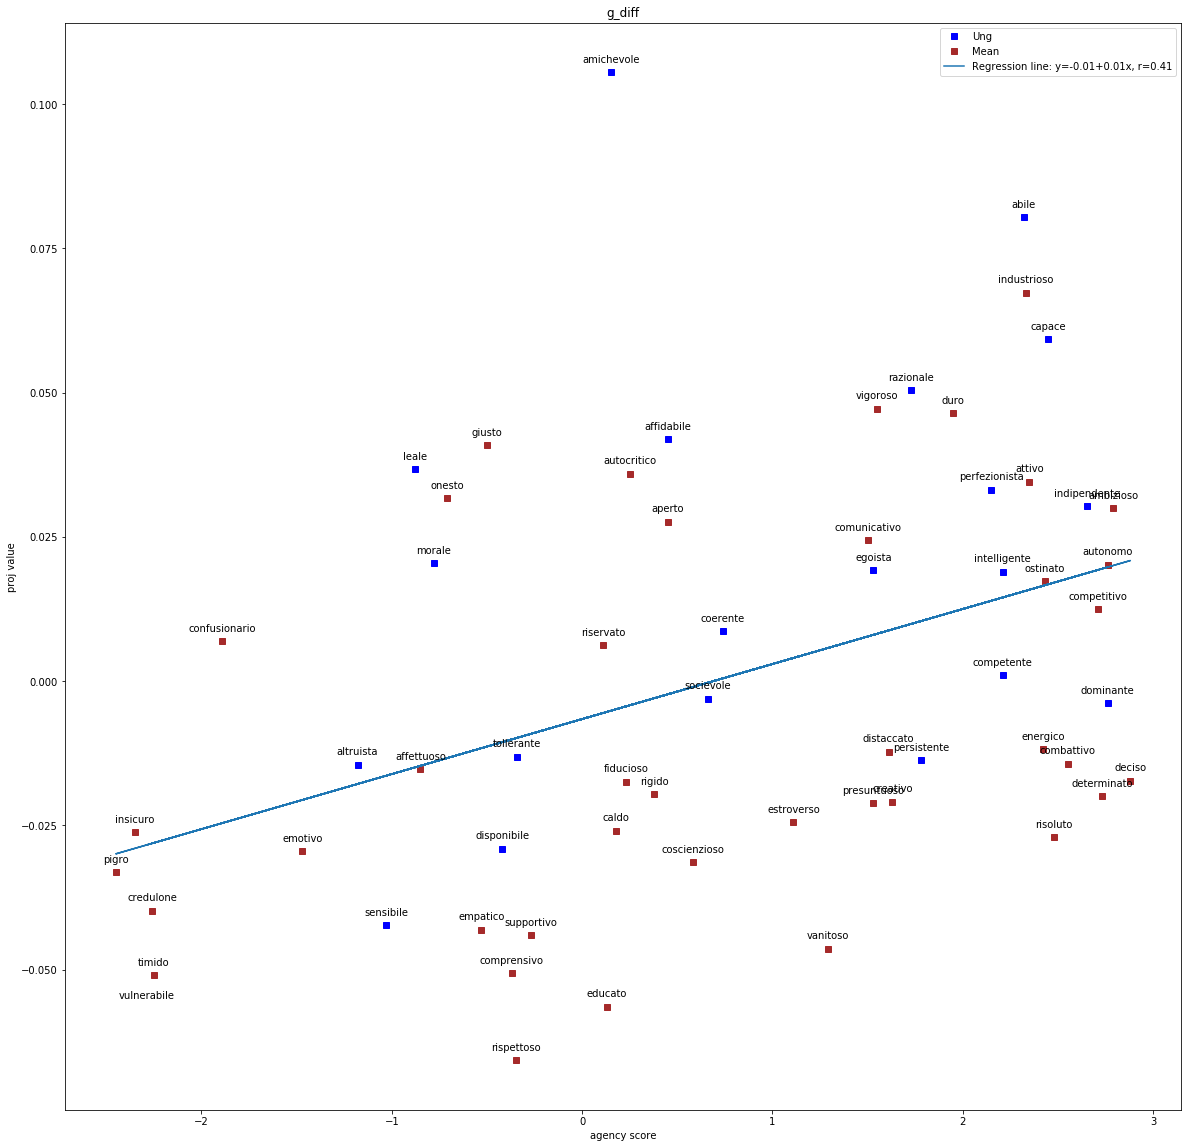

In [99]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col1[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col1[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/ag/ft_g_diff')

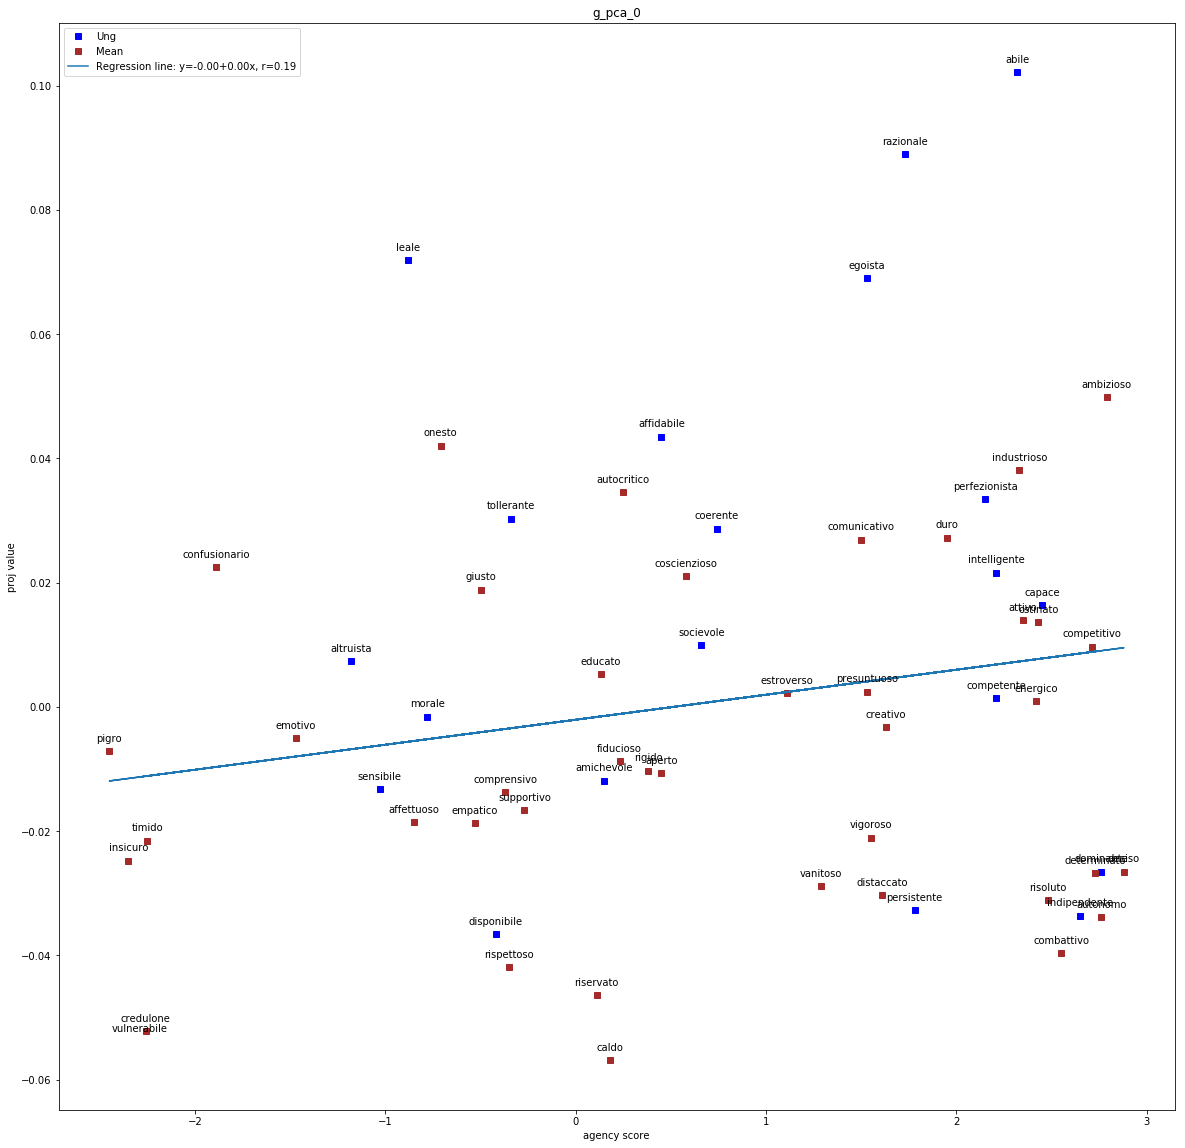

In [100]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col2[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col2[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/ag/ft_g_pca_0')

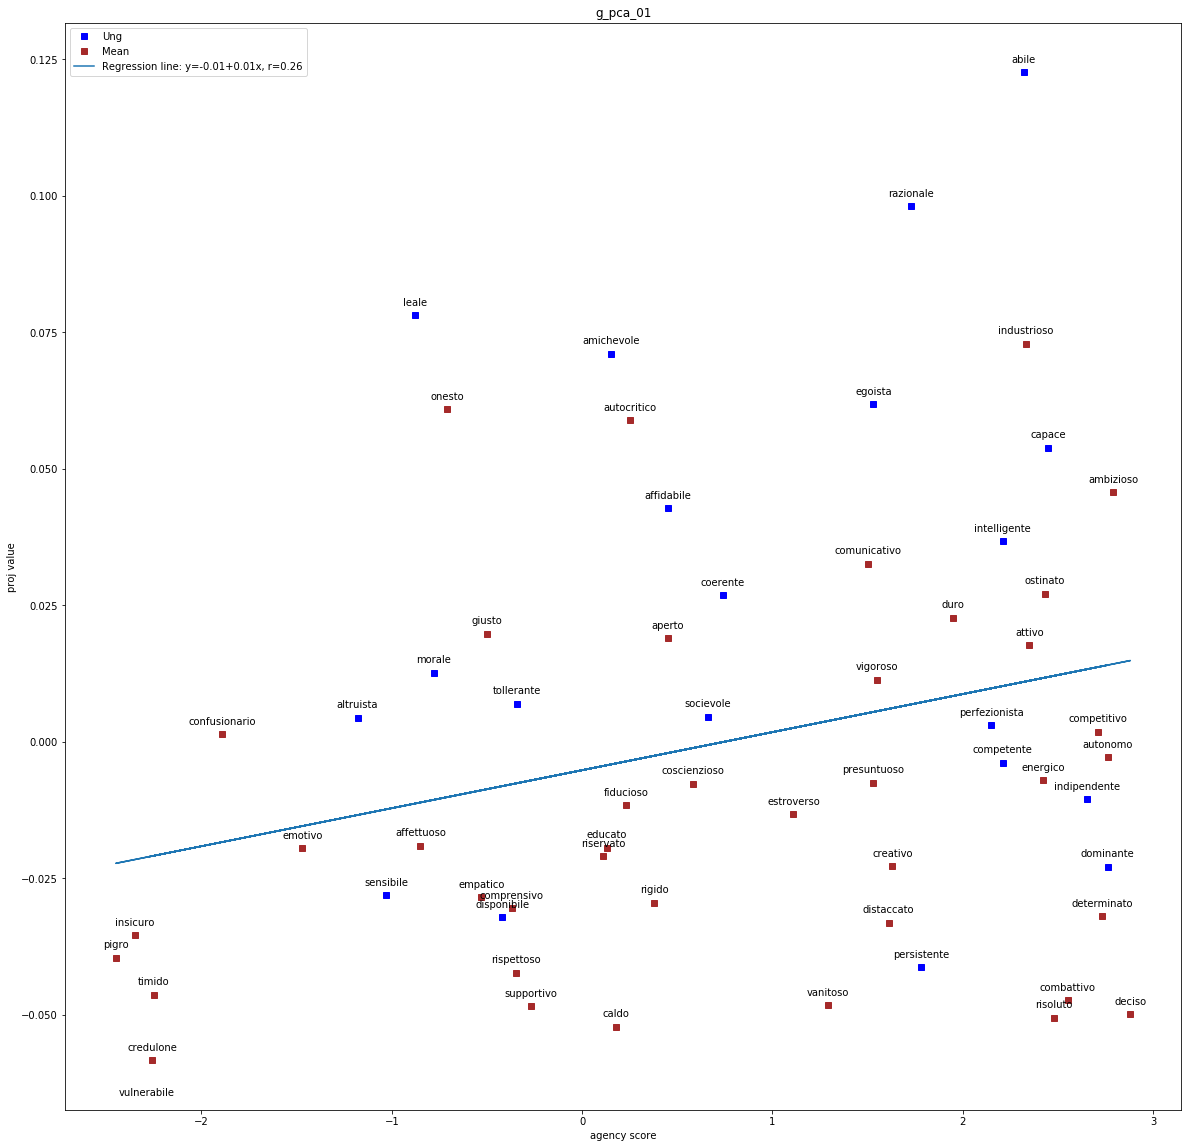

In [101]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col3[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col3[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/ag/ft_g_pca_01')

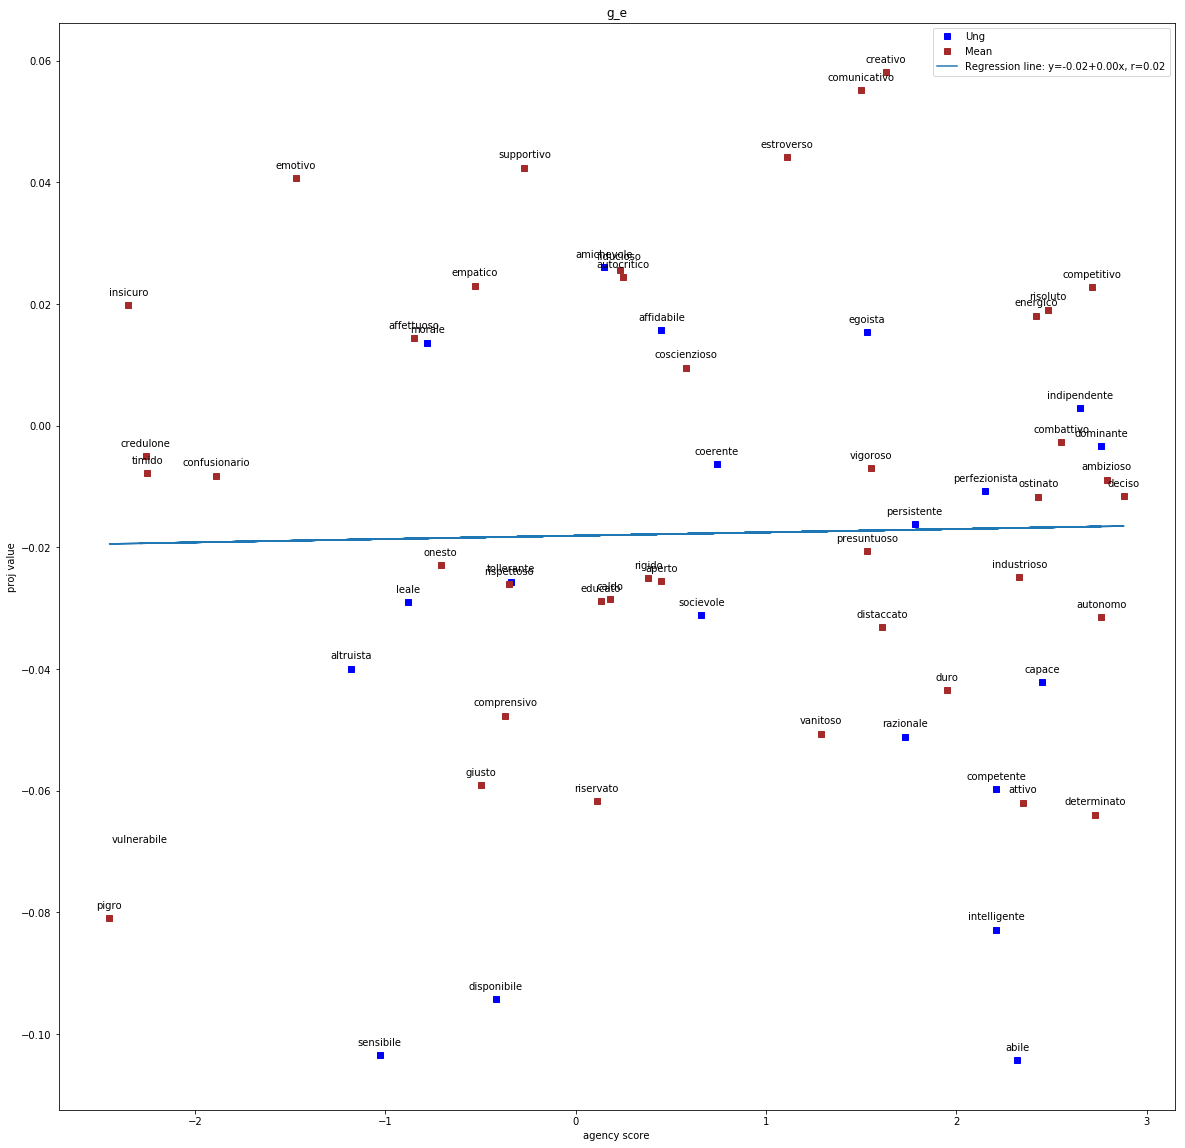

In [102]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col4[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col4[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/ag/ft_g_e')

In [103]:
# communion correlation
r_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col1)[0]
r_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col2)[0]
r_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col3)[0]
r_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col4)[0]
p_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col1)[1]
p_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col2)[1]
p_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col3)[1]
p_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col4)[1]

In [104]:
pearson_data = {'g_diff':[r_ag_com_mean_g_diff,p_ag_com_mean_g_diff],
                'g_pca_0':[r_ag_com_mean_g_pca_0,p_ag_com_mean_g_pca_0],
                'g_pca_01':[r_ag_com_mean_g_pca_01,p_ag_com_mean_g_pca_01],
                'g_e':[r_ag_com_mean_g_e,p_ag_com_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion mean correlation")
pearson_table

Communion mean correlation


g_diff   g_pca_0  g_pca_01       g_e
r -0.012509  0.104536  0.136876  0.017859
p  0.923775  0.422690  0.292854  0.891341

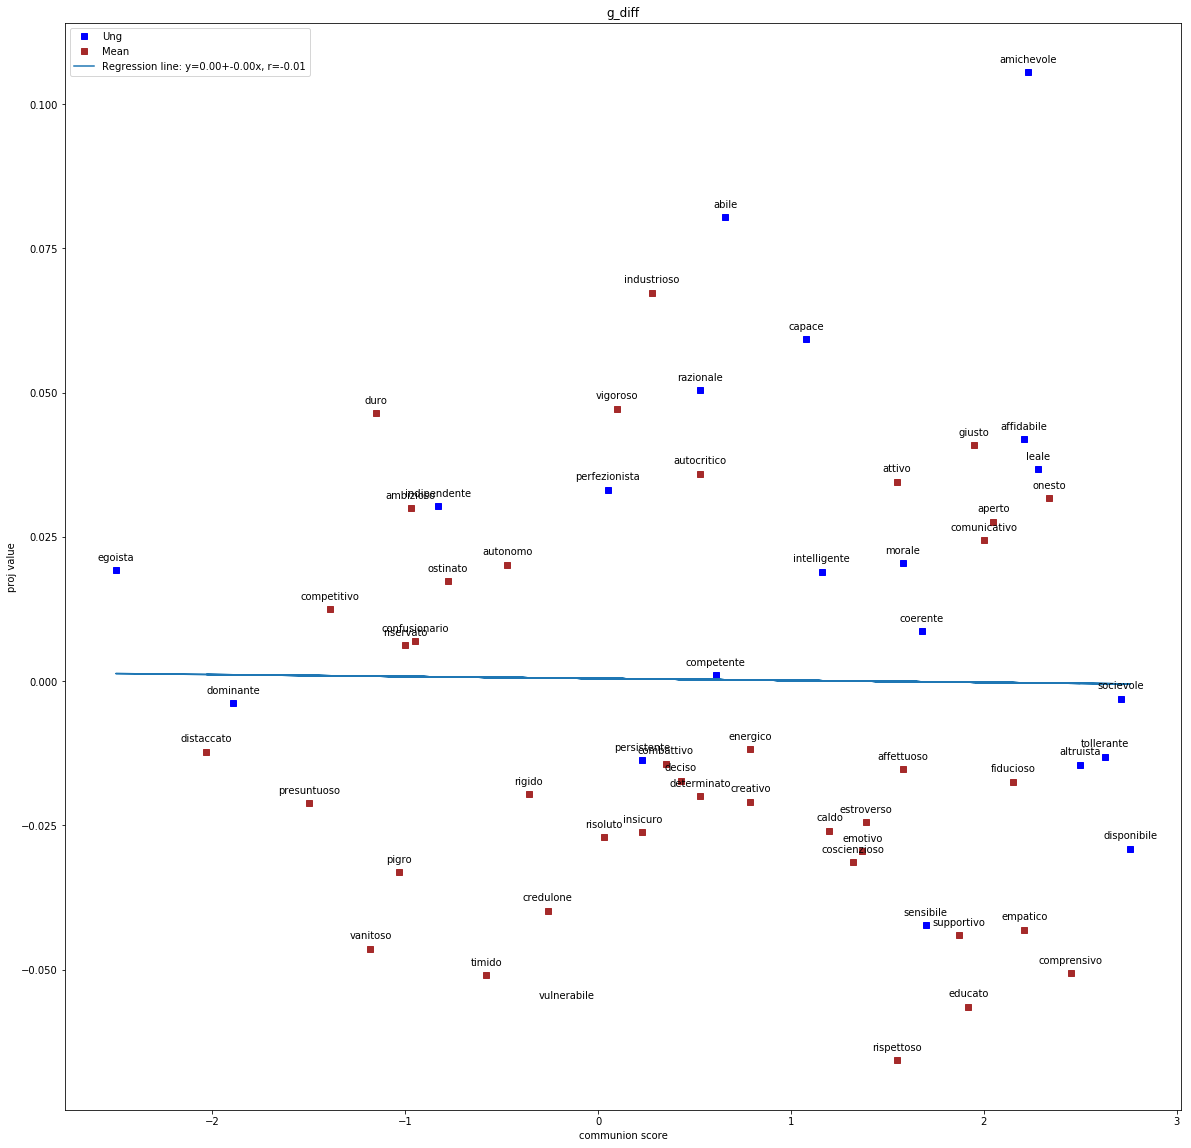

In [105]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col1[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col1[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/com/ft_g_diff')

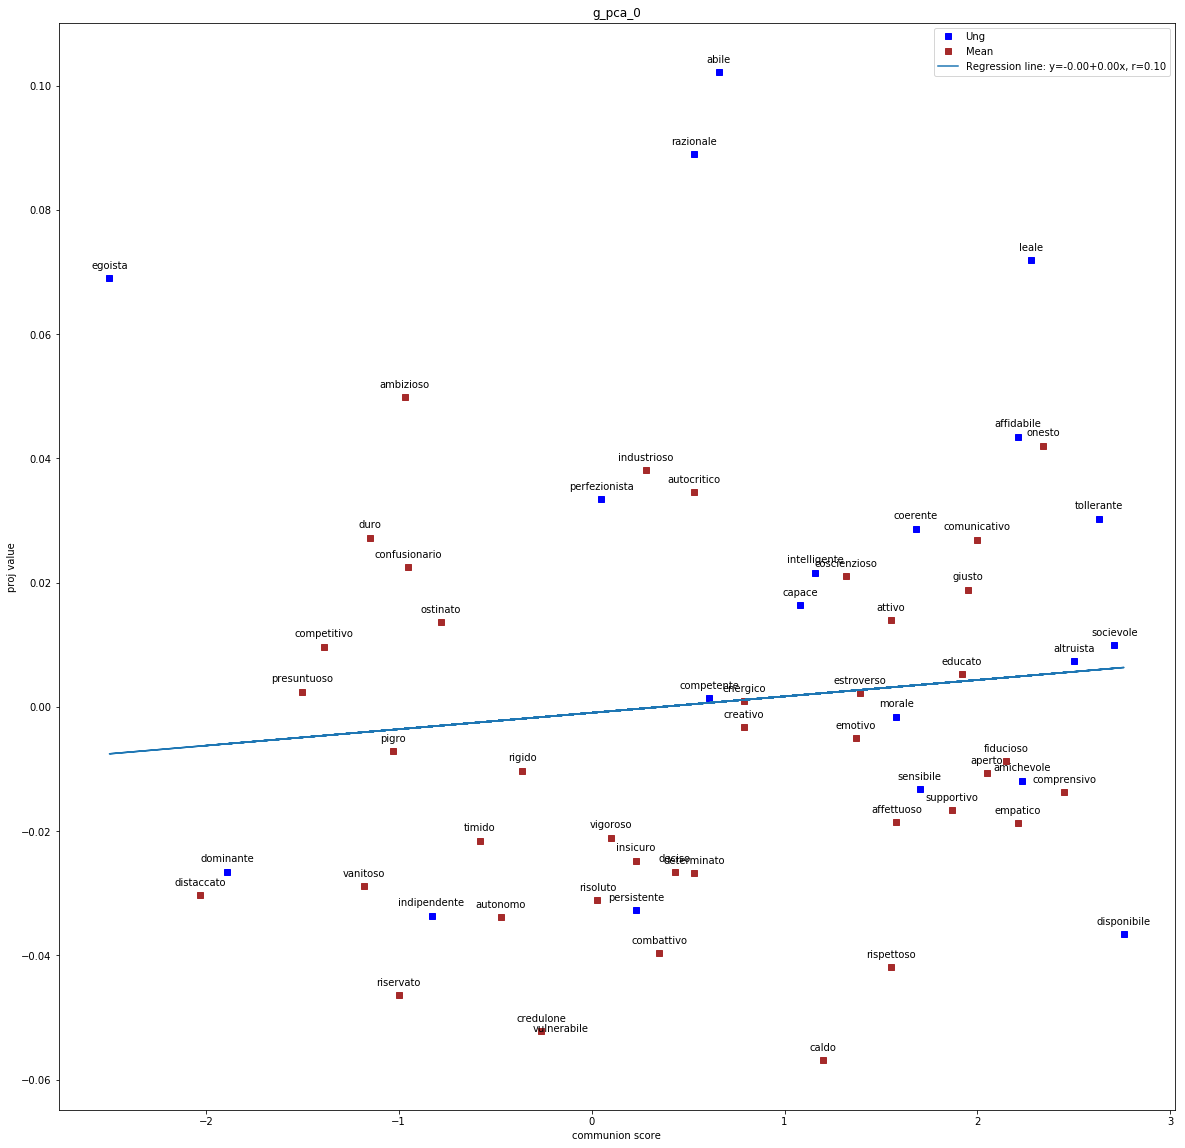

In [106]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col2[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col2[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/com/ft_g_pca_0')

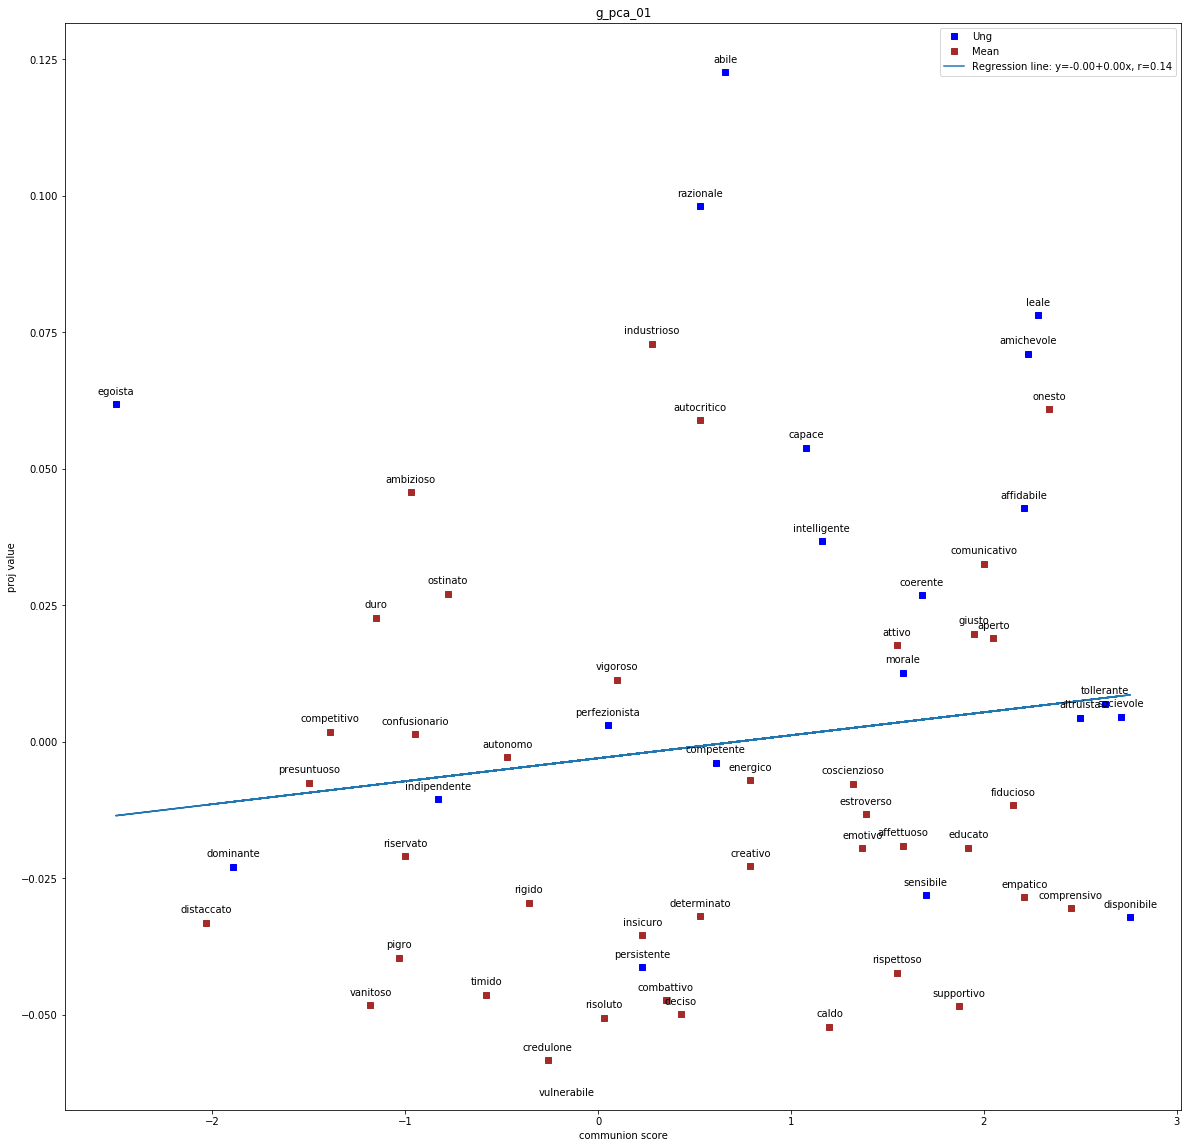

In [107]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col3[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col3[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/com/ft_g_pca_01')

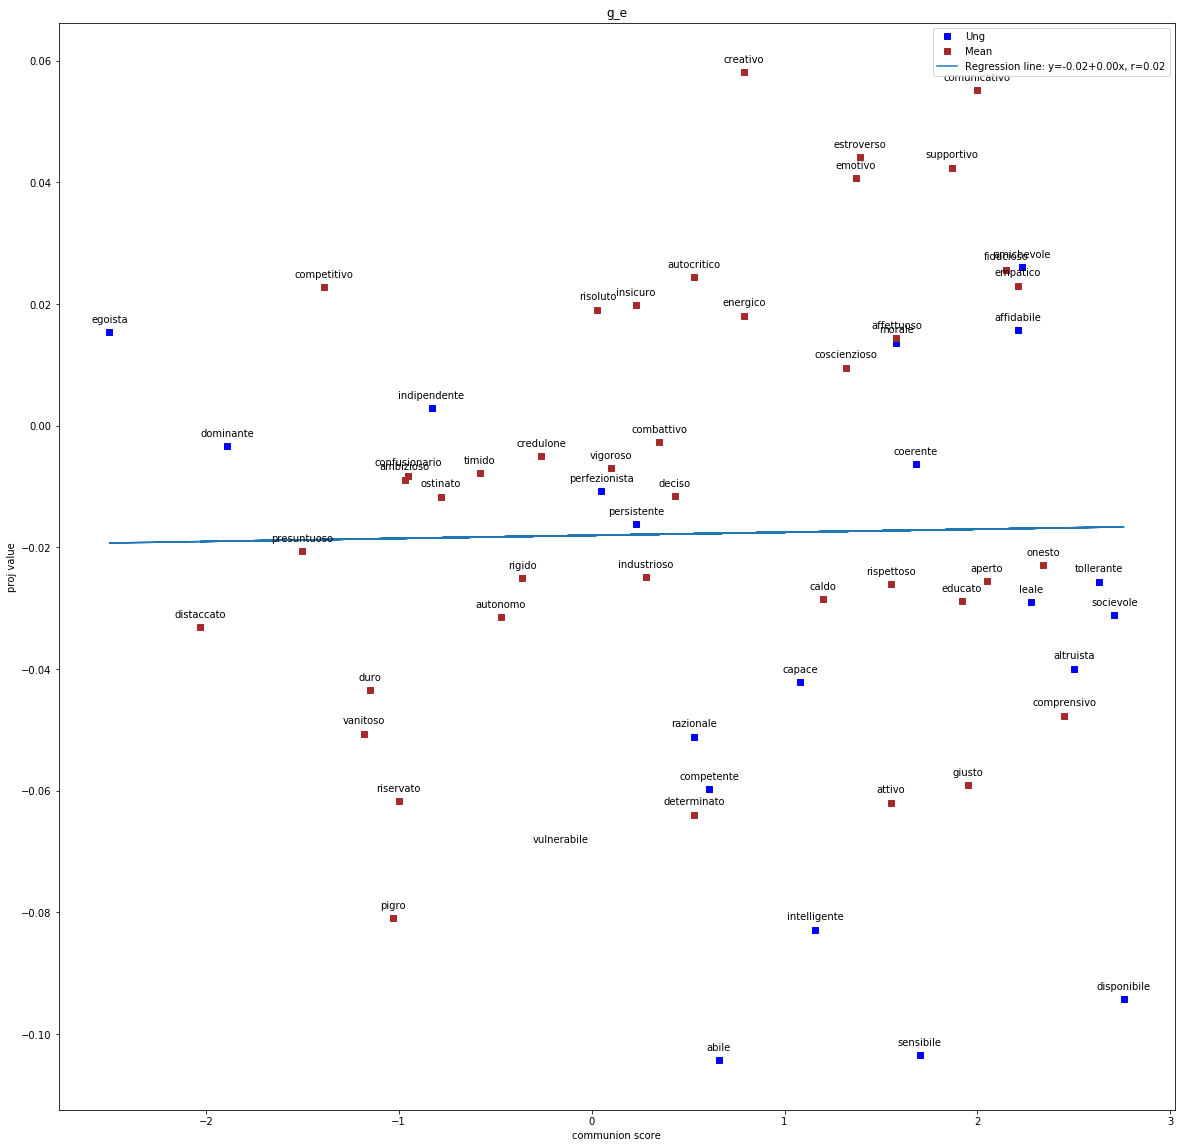

In [108]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col4[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col4[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/com/ft_g_e')

In [109]:
# agency-communion correlation
r_ag_com_mean_g_diff = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col1)[0]
r_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col2)[0]
r_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col3)[0]
r_ag_com_mean_g_e = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col4)[0]
p_ag_com_mean_g_diff = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col1)[1]
p_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col2)[1]
p_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col3)[1]
p_ag_com_mean_g_e = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col4)[1]

In [110]:
pearson_data = {'g_diff':[r_ag_com_mean_g_diff,p_ag_com_mean_g_diff],
                'g_pca_0':[r_ag_com_mean_g_pca_0,p_ag_com_mean_g_pca_0],
                'g_pca_01':[r_ag_com_mean_g_pca_01,p_ag_com_mean_g_pca_01],
                'g_e':[r_ag_com_mean_g_e,p_ag_com_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion mean correlation")
pearson_table

Agency-Communion mean correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.278763  0.063686  0.097477  0.004906
p  0.029593  0.625827  0.454849  0.970069

#### Step 2.6: subtracting grammatical gender to the emdeddings

In [47]:
from debiaswe.debias import debias

In [48]:
debias(E_ft, [], G_word, [])

485 words of dimension 300 : questo, sua, suo, prima, ..., supportivo, calzolaia, supportiva, agrotecnica
set()
485 words of dimension 300 : questo, sua, suo, prima, ..., supportivo, calzolaia, supportiva, agrotecnica


In [49]:
# gender direction
g_diff = E_ft.diff('lui', 'lei')

In [50]:
# list of pairs to define gender
gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [51]:
# PCA
pca = we.doPCA(gender_pairs, E_ft)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [52]:
print("Singular values:")
print(sv)

Singular values:
[6.9684738e-01 5.0248235e-01 3.8360339e-01 3.4403831e-01 3.0402446e-01
 2.4636908e-01 6.0329249e-08 4.8515240e-08 4.6014925e-08 3.9377852e-08]


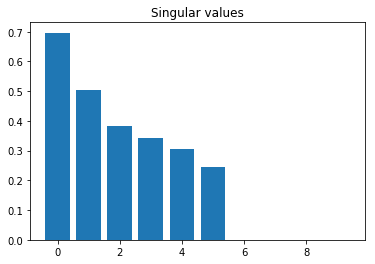

In [53]:
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()

In [54]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])
g_pca_01 = (sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1])/LA.norm((sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1]))

In [55]:
S_word = [['lui','lei'],
          ['uomo','donna'], 
          ['padre','madre'],
          ['marito','moglie'],
          ['fratello','sorella'],
          ['maschio','femmina']]

G_word = db.read('gram_def_mf.txt', 'mf')

In [56]:
S_m_v = []
for w in S_word:
    S_m_v.append(E_ft.v(w[1]))
    
S_f_v = []
for w in S_word:
    S_f_v.append(E_ft.v(w[0]))
    
G_m_v = []
for w in G_word:
    G_m_v.append(E_ft.v(w[0]))
    
G_f_v = []
for w in G_word:
    G_f_v.append(E_ft.v(w[1]))

S_m = np.array(S_m_v).T
S_f = np.array(S_f_v).T
G_m = np.array(G_m_v).T
G_f = np.array(G_f_v).T

In [57]:
# delta semantic
Delta_S = np.dot(np.subtract(S_m, S_f), np.subtract(S_m, S_f).T)

# delta grammatical
Delta_G = np.dot(np.subtract(G_m, G_f), np.subtract(G_m, G_f).T)

# A
A = np.dot(np.linalg.inv(Delta_G), Delta_S)

In [58]:
# eigenvalues and eigenvectors
w, v = np.linalg.eig(A)

# gender direction: pick the eigenvector associated to the largest eigenvalue
g_e = v[:,np.argmax(w)] # already normalized

In [59]:
# words
ag_com_ung = db.read('ag_com_ung_ita.txt', 'ag-com-mf')

In [60]:
# compute projections
# all words ungendered
proj_ag_com_ung_g_diff =  db.prof_proj(E_ft, ag_com_ung, g_diff, 'ag-com-m')
proj_ag_com_ung_g_pca_0 =  db.prof_proj(E_ft, ag_com_ung, g_pca_0, 'ag-com-m')
proj_ag_com_ung_g_pca_01 =  db.prof_proj(E_ft, ag_com_ung, g_pca_01, 'ag-com-m')
proj_ag_com_ung_g_e =  db.prof_proj(E_ft, ag_com_ung, g_e, 'ag-com-m')

In [61]:
# print ag_com_ung results
ag_com_ung_col0 = [] # pandas columns
ag_com_ung_col1 = []
ag_com_ung_col2 = []
ag_com_ung_col3 = []
ag_com_ung_col4 = []
ag_com_ung_col5 = []
ag_com_ung_col6 = []

for i in range(len(proj_ag_com_ung_g_diff)):
    ag_com_ung_col0.append(proj_ag_com_ung_g_diff[i][0]) # word
    ag_com_ung_col1.append(proj_ag_com_ung_g_diff[i][1]) # projection on g_diff
    ag_com_ung_col2.append(proj_ag_com_ung_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_ung_col3.append(proj_ag_com_ung_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_ung_col4.append(np.real(proj_ag_com_ung_g_e[i][1])) # projection on g_e
    ag_com_ung_col5.append(proj_ag_com_ung_g_diff[i][2])
    ag_com_ung_col6.append(proj_ag_com_ung_g_diff[i][3])

ag_com_ung_data = {'Word':ag_com_ung_col0, 
               'Proj g_diff':ag_com_ung_col1,
               'Proj g_pca_0':ag_com_ung_col2, 
               'Proj g_pca_01':ag_com_ung_col3,
               'Proj g_e':ag_com_ung_col4,
               'Agency':ag_com_ung_col5,
               'Communion':ag_com_ung_col6}

ag_com_ung_table = pd.DataFrame(ag_com_ung_data)
ag_com_ung_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0           abile     0.067950      0.095182       0.054223 -0.026474    2.32   
1       altruista    -0.009973      0.014702       0.020507  0.009811   -1.18   
2          capace     0.060599      0.029318      -0.024584 -0.026633    2.45   
3      competente     0.003687     -0.000513       0.007158 -0.049972    2.21   
4        coerente     0.007508      0.024642       0.021850 -0.008620    0.74   
5       dominante     0.011981      0.008073       0.015497  0.084365    2.76   
6      amichevole     0.126366      0.082296      -0.011115  0.083360    0.15   
7     disponibile    -0.034073     -0.068511      -0.080057  0.000437   -0.42   
8         egoista     0.012170      0.052224       0.047923 -0.057813    1.53   
9    indipendente     0.043086     -0.003854      -0.025846  0.077823    2.65   
10   intelligente     0.025574      0.046485       0.028568 -0.030374    2.21   
11          leale     0.028486      0.062726       0.043906  0.082790   -0.88   
12         morale     0.039513      0.059331       0.057283  0.044066   -0.78   
13  perfezionista     0.024179     -0.017358       0.009684 -0.004887    2.15   
14    persistente    -0.004684     -0.024211      -0.004162  0.029215    1.78   
15      razionale     0.050231      0.106848       0.082840  0.022986    1.73   
16     affidabile     0.037939      0.030380       0.020902 -0.024565    0.45   
17      sensibile    -0.041643     -0.034576      -0.019307 -0.016982   -1.03   
18      socievole    -0.003621      0.000814       0.006876 -0.004512    0.66   
19     tollerante    -0.015721      0.013727       0.039538  0.032780   -0.34   
20    vulnerabile    -0.062092     -0.102184      -0.090994  0.011961   -2.29   

    Communion  
0        0.66  
1        2.50  
2        1.08  
3        0.61  
4        1.68  
5       -1.89  
6        2.23  
7        2.76  
8       -2.50  
9       -0.83  
10       1.16  
11       2.28  
12       1.58  
13       0.05  
14       0.23  
15       0.53  
16       2.21  
17       1.70  
18       2.71  
19       2.63  
20      -0.16

In [62]:
# ag_com_ung pearson correlation
# agency correlation
r_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col1)[0]
r_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col2)[0]
r_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col3)[0]
r_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col4)[0]
p_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col1)[1]
p_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col2)[1]
p_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col3)[1]
p_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col4)[1]

In [63]:
pearson_data = {'g_diff':[r_ag_com_ung_g_diff,p_ag_com_ung_g_diff],
                'g_pca_0':[r_ag_com_ung_g_pca_0,p_ag_com_ung_g_pca_0],
                'g_pca_01':[r_ag_com_ung_g_pca_01,p_ag_com_ung_g_pca_01],
                'g_e':[r_ag_com_ung_g_e,p_ag_com_ung_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency ungendered correlation")
pearson_table

Agency ungendered correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.452519  0.326050  0.277537 -0.153815
p  0.039422  0.149183  0.223201  0.505612

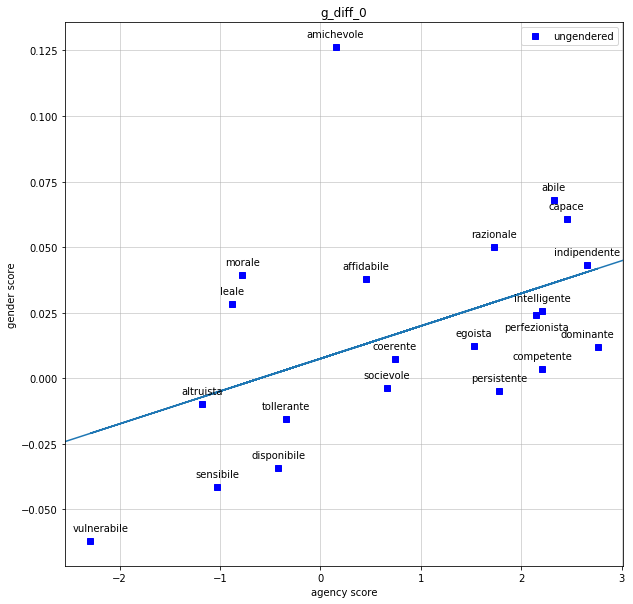

In [64]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(ag_com_ung_col5, ag_com_ung_col1, linewidth=0, marker='s', color='blue', label='ungendered')
#ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
xlims = plt.xlim()
x = [i for i in ag_com_ung_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_xlabel('agency score')
ax.set_ylabel('gender score')
ax.set_title("g_diff_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    if label=='vulnerabile':
        plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue

    if label=='dominante':
        plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='perfezionista':
        plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/ag/ft_deb_g_diff.pdf', bbox_inches='tight', format='pdf')

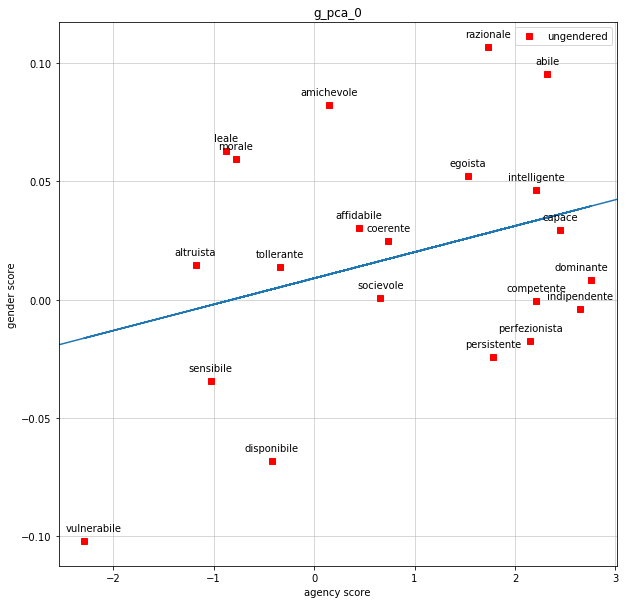

In [65]:
# correlation plot g_pca_0
'''
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col2)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(ag_com_ung_col5, ag_com_ung_col2, linewidth=0, marker='s', color='red', label='ungendered')
#ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
xlims = plt.xlim()
x = [i for i in ag_com_ung_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x), label=line)
plt.xlim(xlims)
ax.set_xlabel('agency score')
ax.set_ylabel('gender score')
ax.set_title("g_pca_0")
ax.legend()

for i, label in enumerate(ag_com_ung_col0):
    if label=='vulnerabile':
        plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='dominante':
        plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue       
        
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
'''
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col2)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(ag_com_ung_col5, ag_com_ung_col2, linewidth=0, marker='s', color='red', label='ungendered')
#ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
xlims = plt.xlim()
x = [i for i in ag_com_ung_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_xlabel('agency score')
ax.set_ylabel('gender score')
ax.set_title("g_pca_0")
ax.legend()

for i, label in enumerate(ag_com_ung_col0):
    if label=='vulnerabile':
        plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='dominante':
        plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue       

    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/ag/ft_deb_g_pca_0.pdf', bbox_inches='tight', format='pdf')

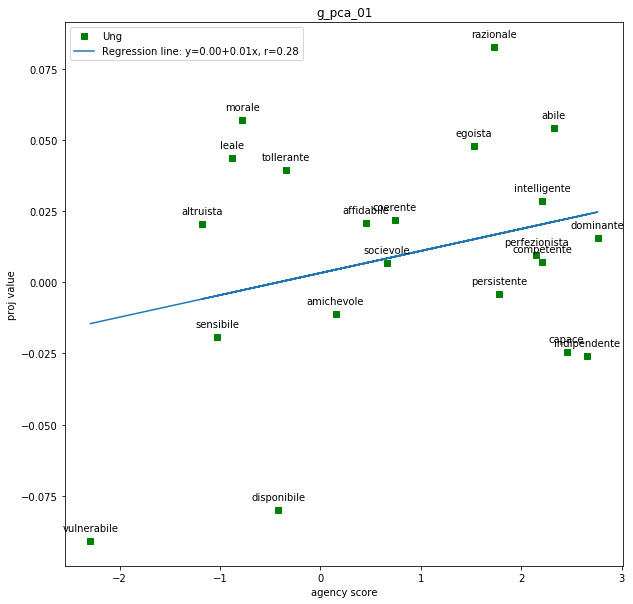

In [130]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col5, ag_com_ung_col3, linewidth=0, marker='s', color='green', label='Ung')
ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/ag/ft_deb_g_pca_01')

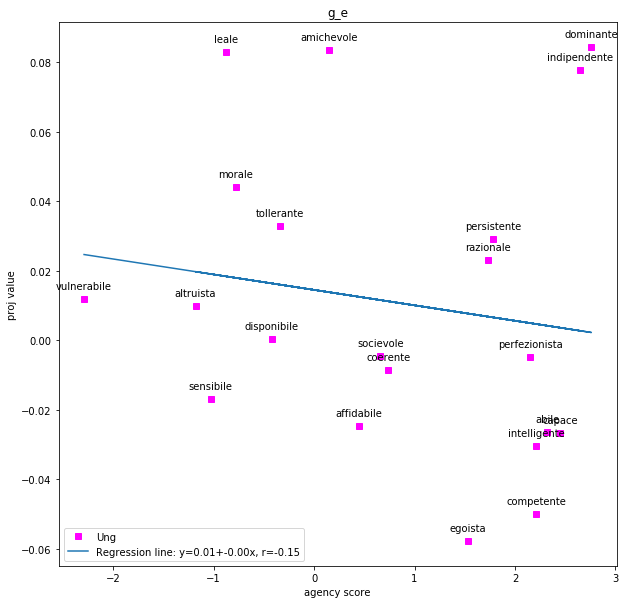

In [131]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col5, ag_com_ung_col4, linewidth=0, marker='s', color='magenta', label='Ung')
ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/ag/ft_deb_g_e')

In [132]:
# communion correlation
r_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col1)[0]
r_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col2)[0]
r_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col3)[0]
r_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col4)[0]
p_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col1)[1]
p_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col2)[1]
p_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col3)[1]
p_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col4)[1]

In [133]:
pearson_data = {'g_diff':[r_ag_com_ung_g_diff,p_ag_com_ung_g_diff],
                'g_pca_0':[r_ag_com_ung_g_pca_0,p_ag_com_ung_g_pca_0],
                'g_pca_01':[r_ag_com_ung_g_pca_01,p_ag_com_ung_g_pca_01],
                'g_e':[r_ag_com_ung_g_e,p_ag_com_ung_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion ungendered correlation")
pearson_table

Communion ungendered correlation


g_diff   g_pca_0  g_pca_01       g_e
r -0.013353  0.031751 -0.045106  0.031127
p  0.954189  0.891326  0.846064  0.893451

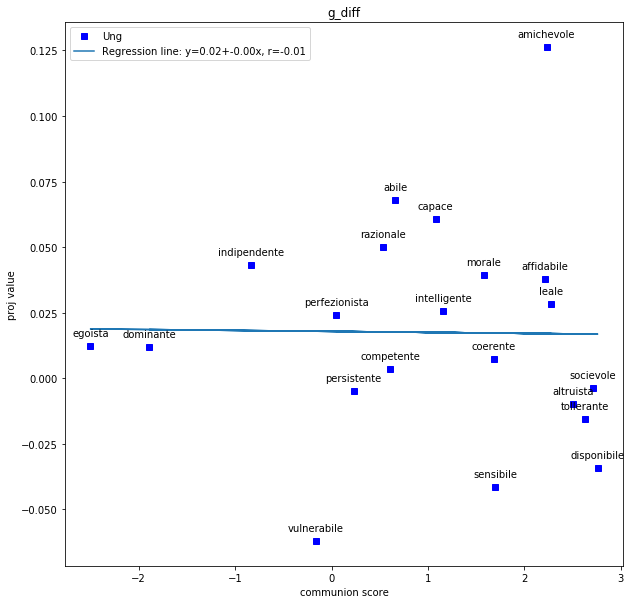

In [134]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col1, linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/com/ft_deb_g_diff')

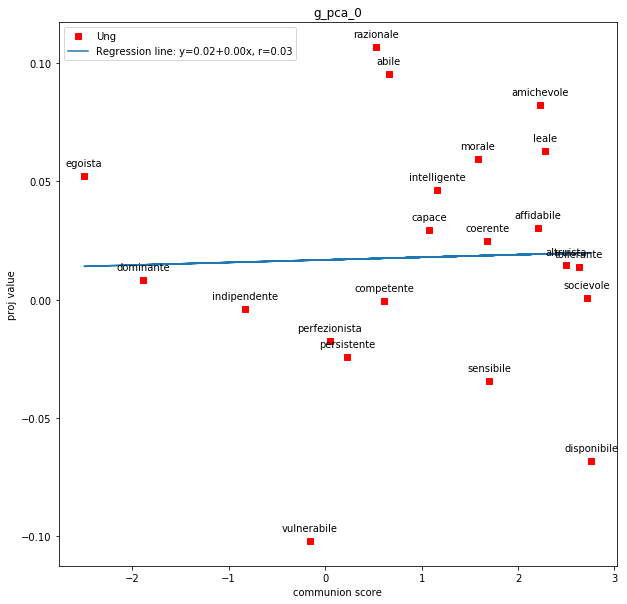

In [135]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col2, linewidth=0, marker='s', color='red', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/com/ft_deb_g_pca_0')

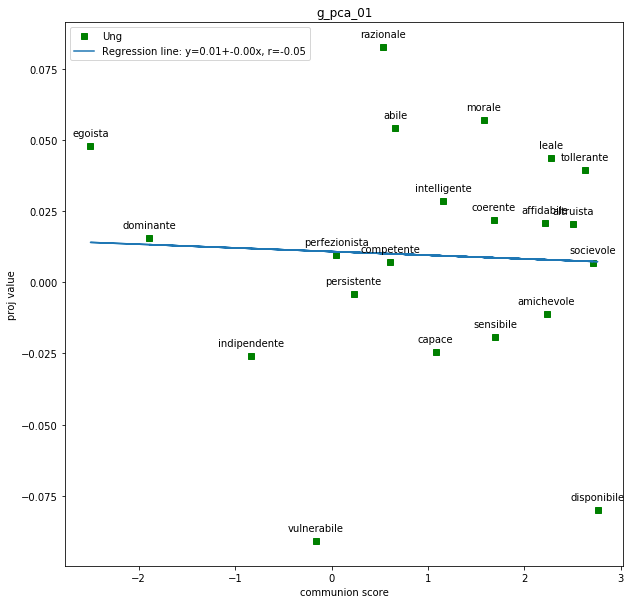

In [136]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col3, linewidth=0, marker='s', color='green', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/com/ft_deb_g_pca_01')

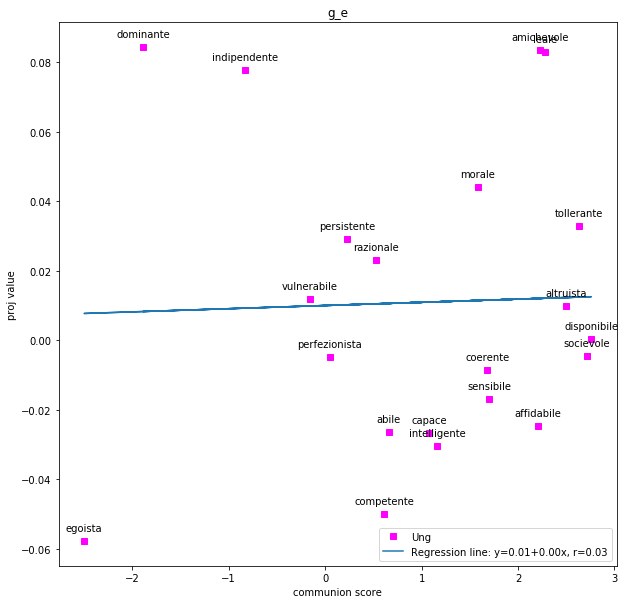

In [137]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col4, linewidth=0, marker='s', color='magenta', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/com/ft_deb_g_e')

In [138]:
# agency-communion correlation
r_ag_com_ung_g_diff = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col1)[0]
r_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col2)[0]
r_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col3)[0]
r_ag_com_ung_g_e = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col4)[0]
p_ag_com_ung_g_diff = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col1)[1]
p_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col2)[1]
p_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col3)[1]
p_ag_com_ung_g_e = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col4)[1]

In [139]:
pearson_data = {'g_diff':[r_ag_com_ung_g_diff,p_ag_com_ung_g_diff],
                'g_pca_0':[r_ag_com_ung_g_pca_0,p_ag_com_ung_g_pca_0],
                'g_pca_01':[r_ag_com_ung_g_pca_01,p_ag_com_ung_g_pca_01],
                'g_e':[r_ag_com_ung_g_e,p_ag_com_ung_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion ungendered correlation")
pearson_table

Agency-Communion ungendered correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.268514  0.170084  0.185551 -0.106299
p  0.239233  0.461066  0.420667  0.646521

##### Gendered words

In [66]:
# words
ag_com_gen = db.read('ag_com_gen_ita.txt', 'ag-com-mf')

In [67]:
# compute projections
# male
proj_ag_com_gen_m_g_diff =  db.prof_proj(E_ft, ag_com_gen, g_diff, 'ag-com-m')
proj_ag_com_gen_m_g_pca_0 =  db.prof_proj(E_ft, ag_com_gen, g_pca_0, 'ag-com-m')
proj_ag_com_gen_m_g_pca_01 =  db.prof_proj(E_ft, ag_com_gen, g_pca_01, 'ag-com-m')
proj_ag_com_gen_m_g_e =  db.prof_proj(E_ft, ag_com_gen, g_e, 'ag-com-m')

# female
proj_ag_com_gen_f_g_diff =  db.prof_proj(E_ft, ag_com_gen, g_diff, 'ag-com-f')
proj_ag_com_gen_f_g_pca_0 =  db.prof_proj(E_ft, ag_com_gen, g_pca_0, 'ag-com-f')
proj_ag_com_gen_f_g_pca_01 =  db.prof_proj(E_ft, ag_com_gen, g_pca_01, 'ag-com-f')
proj_ag_com_gen_f_g_e =  db.prof_proj(E_ft, ag_com_gen, g_e, 'ag-com-f')

In [68]:
# print ag_com_gen_m results
ag_com_gen_m_col0 = [] # pandas columns
ag_com_gen_m_col1 = []
ag_com_gen_m_col2 = []
ag_com_gen_m_col3 = []
ag_com_gen_m_col4 = []
ag_com_gen_m_col5 = []
ag_com_gen_m_col6 = []

for i in range(len(proj_ag_com_gen_m_g_diff)):
    ag_com_gen_m_col0.append(proj_ag_com_gen_m_g_diff[i][0]) # word
    ag_com_gen_m_col1.append(proj_ag_com_gen_m_g_diff[i][1]) # projection on g_diff
    ag_com_gen_m_col2.append(proj_ag_com_gen_m_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_gen_m_col3.append(proj_ag_com_gen_m_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_gen_m_col4.append(np.real(proj_ag_com_gen_m_g_e[i][1])) # projection on g_e
    ag_com_gen_m_col5.append(proj_ag_com_gen_m_g_diff[i][2])
    ag_com_gen_m_col6.append(proj_ag_com_gen_m_g_diff[i][3])

ag_com_gen_m_data = {'Word':ag_com_gen_m_col0, 
               'Proj g_diff':ag_com_gen_m_col1,
               'Proj g_pca_0':ag_com_gen_m_col2, 
               'Proj g_pca_01':ag_com_gen_m_col3,
               'Proj g_e':ag_com_gen_m_col4,
               'Agency':ag_com_gen_m_col5,
               'Communion':ag_com_gen_m_col6}

ag_com_gen_m_table = pd.DataFrame(ag_com_gen_m_data)
ag_com_gen_m_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0          attivo     0.071174      0.019152      -0.033121  0.044490    2.35   
1      affettuoso     0.006202      0.015842       0.021619 -0.008400   -0.85   
2       ambizioso     0.093759      0.149160       0.131320 -0.047719    2.79   
3          deciso     0.003020     -0.019046       0.003876  0.013403    2.88   
4        vanitoso     0.043833      0.022666      -0.015089 -0.113481    1.29   
5   confusionario    -0.003857     -0.021389      -0.026329  0.036327   -1.89   
6    comunicativo     0.015293     -0.015848      -0.054754  0.009934    1.50   
7     competitivo     0.012577     -0.026535      -0.053721  0.111068    2.71   
8     presuntuoso     0.051027      0.065290       0.038252 -0.069500    1.53   
9    coscienzioso     0.020052      0.066722       0.072015  0.014911    0.58   
10     rispettoso    -0.046958     -0.073172      -0.120067 -0.044932   -0.35   
11       creativo    -0.024895     -0.060618      -0.064651 -0.001069    1.63   
12     distaccato     0.017730     -0.047418      -0.075846  0.036774    1.61   
13    determinato     0.034216      0.011077      -0.007362  0.008118    2.73   
14         rigido    -0.047658     -0.082042      -0.084313  0.061839    0.38   
15        emotivo    -0.071619     -0.104412      -0.093630  0.011102   -1.47   
16       energico     0.034150      0.009489      -0.020814 -0.011861    2.42   
17         giusto    -0.049052     -0.088336      -0.073712 -0.027702   -0.50   
18      credulone     0.085390      0.069614       0.040289 -0.045271   -2.26   
19           duro     0.021404     -0.039708      -0.056193 -0.008927    1.95   
20         onesto     0.091898      0.118402       0.057123 -0.018500   -0.71   
21    industrioso     0.109962      0.124559       0.070059  0.081305    2.33   
22       insicuro     0.069246      0.006703      -0.049302 -0.001251   -2.35   
23          pigro     0.068453      0.070587       0.050336 -0.027956   -2.45   
24       ostinato     0.093907      0.078553       0.023322  0.028491    2.43   
25         aperto     0.007087     -0.007199      -0.058947  0.071741    0.45   
26     estroverso     0.063855      0.067419       0.026521  0.006307    1.11   
27        educato     0.062790      0.102799       0.065420  0.033186    0.13   
28      riservato     0.005938     -0.084816      -0.144990  0.028684    0.11   
29    autocritico     0.011653     -0.006089      -0.059614  0.041142    0.25   
30       autonomo     0.033907     -0.025048      -0.089886 -0.032914    2.76   
31         timido     0.042973      0.065111       0.074680  0.044188   -2.25   
32     combattivo     0.090386      0.028347      -0.010633  0.082459    2.55   
33       risoluto     0.050640      0.018514       0.005340  0.055374    2.48   
34     supportivo    -0.068060     -0.106970      -0.084855  0.109945   -0.27   
35       empatico    -0.048779     -0.069272      -0.085318 -0.029848   -0.53   
36      fiducioso     0.107191      0.084011       0.012372  0.033288    0.23   
37    comprensivo    -0.012597     -0.006197      -0.029370  0.075279   -0.37   
38       vigoroso     0.041912     -0.031642      -0.076123  0.013793    1.55   
39          caldo    -0.040377     -0.093850      -0.079298 -0.045624    0.18   

    Communion  
0        1.55  
1        1.58  
2       -0.97  
3        0.43  
4       -1.18  
5       -0.95  
6        2.00  
7       -1.39  
8       -1.50  
9        1.32  
10       1.55  
11       0.79  
12      -2.03  
13       0.53  
14      -0.36  
15       1.37  
16       0.79  
17       1.95  
18      -0.26  
19      -1.15  
20       2.34  
21       0.28  
22       0.23  
23      -1.03  
24      -0.78  
25       2.05  
26       1.39  
27       1.92  
28      -1.00  
29       0.53  
30      -0.47  
31      -0.58  
32       0.35  
33       0.03  
34       1.87  
35       2.21  
36       2.15  
37       2.45  
38       0.10  
39       1.20

In [69]:
# ag_com_gen_m pearson correlation
# agency correlation
r_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col1)[0]
r_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col2)[0]
r_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col3)[0]
r_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col4)[0]
p_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col1)[1]
p_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col2)[1]
p_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col3)[1]
p_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col4)[1]

In [70]:
pearson_data = {'g_diff':[r_ag_com_gen_m_g_diff,p_ag_com_gen_m_g_diff],
                'g_pca_0':[r_ag_com_gen_m_g_pca_0,p_ag_com_gen_m_g_pca_0],
                'g_pca_01':[r_ag_com_gen_m_g_pca_01,p_ag_com_gen_m_g_pca_01],
                'g_e':[r_ag_com_gen_m_g_e,p_ag_com_gen_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency male correlation")
pearson_table

Agency male correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.231901  0.097749  0.027954  0.123265
p  0.149903  0.548469  0.864045  0.448588

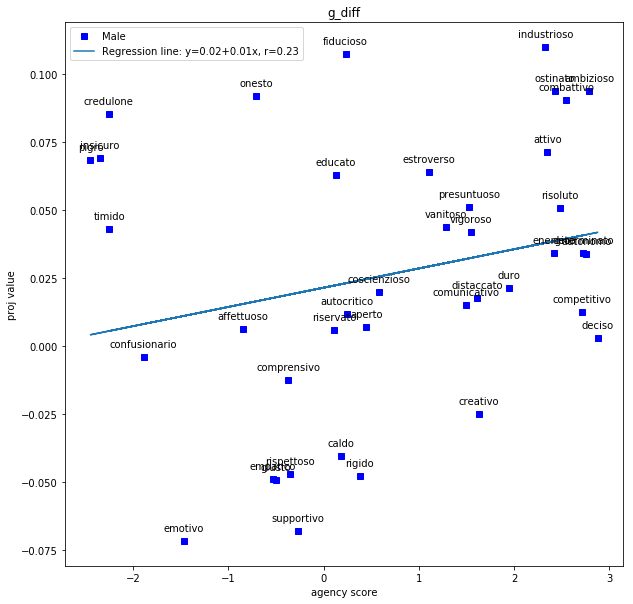

In [146]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/ag/ft_deb_g_diff')

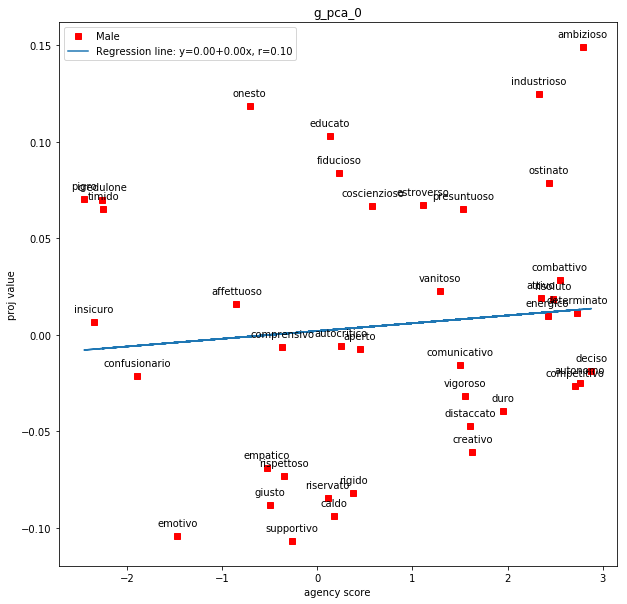

In [147]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col2, linewidth=0, marker='s', color='red', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/ag/ft_deb_g_pca_0')

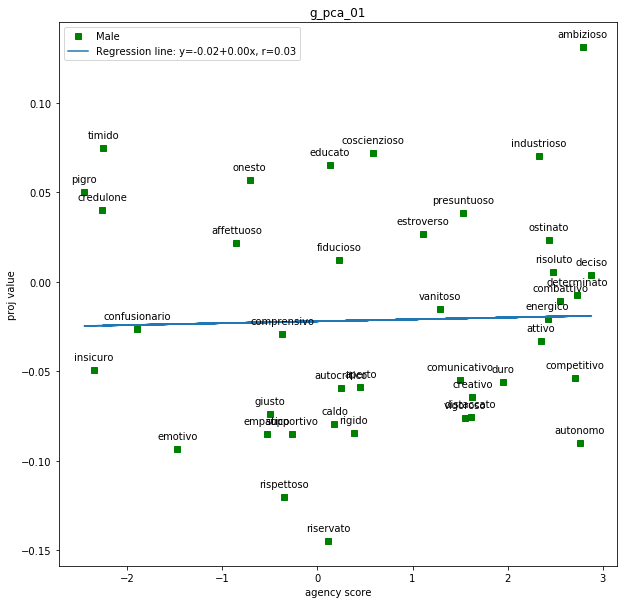

In [148]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col3, linewidth=0, marker='s', color='green', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distaance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/ag/ft_deb_g_pca_01')

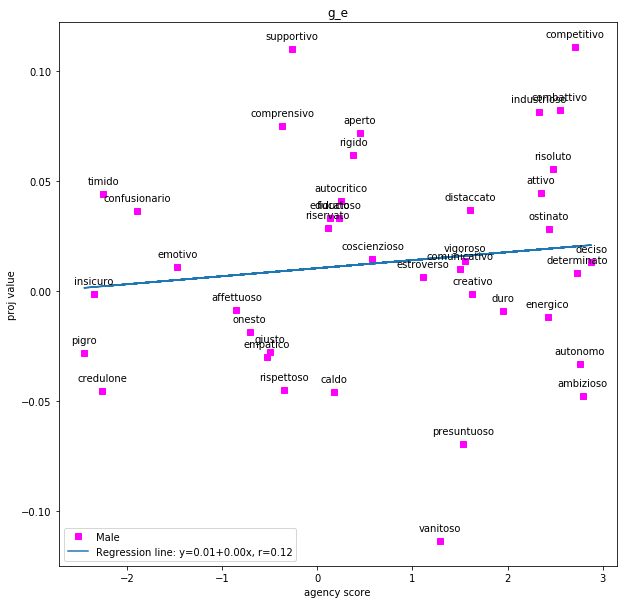

In [149]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col4, linewidth=0, marker='s', color='magenta', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/ag/ft_deb_g_e')

In [150]:
# communion correlation
r_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col1)[0]
r_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col2)[0]
r_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col3)[0]
r_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col4)[0]
p_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col1)[1]
p_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col2)[1]
p_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col3)[1]
p_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col4)[1]

In [151]:
pearson_data = {'g_diff':[r_ag_com_gen_m_g_diff,p_ag_com_gen_m_g_diff],
                'g_pca_0':[r_ag_com_gen_m_g_pca_0,p_ag_com_gen_m_g_pca_0],
                'g_pca_01':[r_ag_com_gen_m_g_pca_01,p_ag_com_gen_m_g_pca_01],
                'g_e':[r_ag_com_gen_m_g_e,p_ag_com_gen_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion male correlation")
pearson_table

Communion male correlation


g_diff   g_pca_0  g_pca_01       g_e
r -0.245564 -0.085891 -0.079579  0.131332
p  0.126680  0.598214  0.625468  0.419214

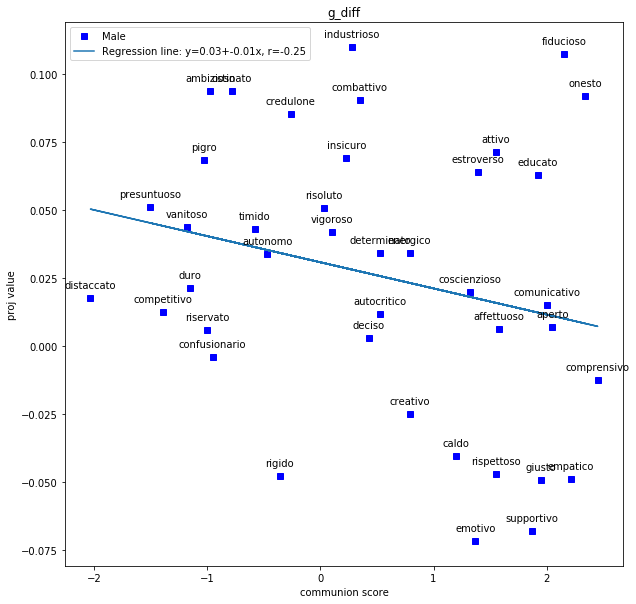

In [152]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/com/ft_deb_g_diff')

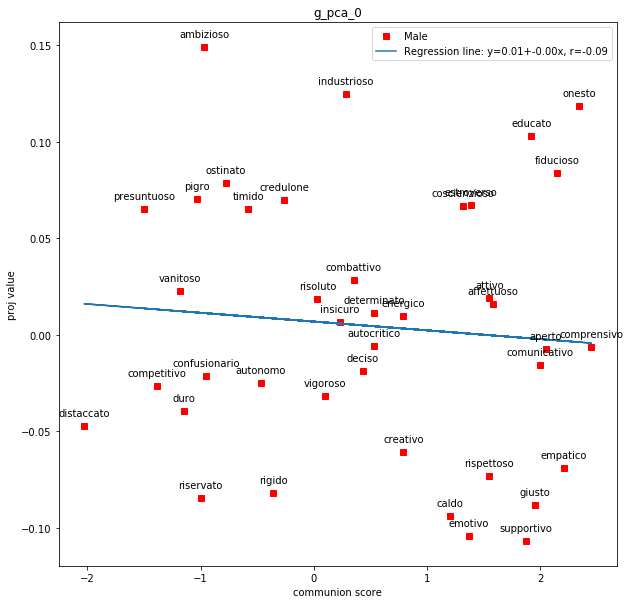

In [153]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col2, linewidth=0, marker='s', color='red', label='Male')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/com/ft_deb_g_pca_0')

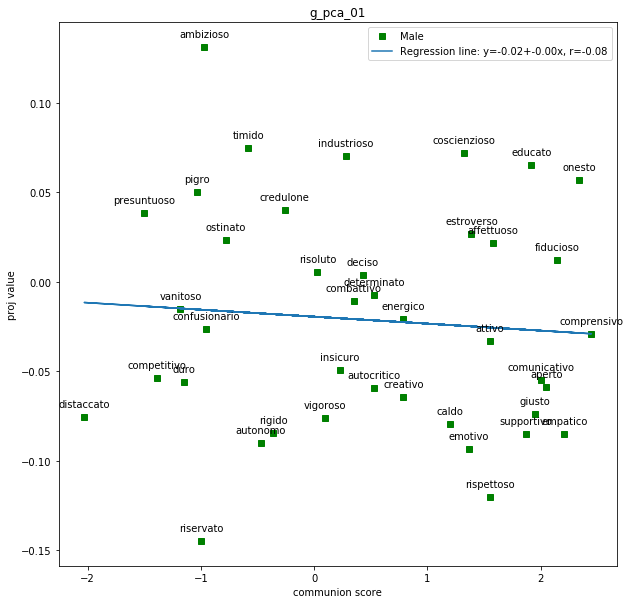

In [154]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col3, linewidth=0, marker='s', color='green', label='Male')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distaance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/com/ft_deb_g_pca_01')

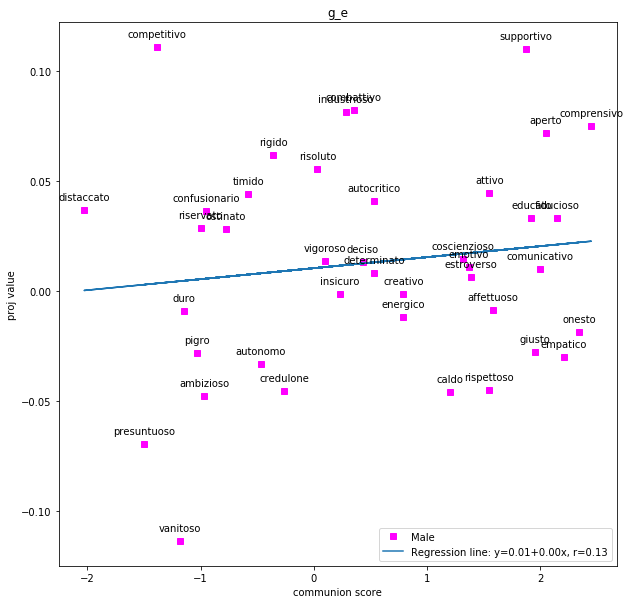

In [155]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col4, linewidth=0, marker='s', color='magenta', label='Male')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/com/ft_deb_g_e')

In [156]:
# agency-communion correlation
r_ag_com_gen_m_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col1)[0]
r_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col2)[0]
r_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col3)[0]
r_ag_com_gen_m_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col4)[0]
p_ag_com_gen_m_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col1)[1]
p_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col2)[1]
p_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col3)[1]
p_ag_com_gen_m_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col4)[1]

In [157]:
pearson_data = {'g_diff':[r_ag_com_gen_m_g_diff,p_ag_com_gen_m_g_diff],
                'g_pca_0':[r_ag_com_gen_m_g_pca_0,p_ag_com_gen_m_g_pca_0],
                'g_pca_01':[r_ag_com_gen_m_g_pca_01,p_ag_com_gen_m_g_pca_01],
                'g_e':[r_ag_com_gen_m_g_e,p_ag_com_gen_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion male correlation")
pearson_table

Agency-Communion male correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.304680  0.118557  0.064724  0.015263
p  0.055929  0.466233  0.691527  0.925524

In [158]:
# print ag_com_gen_f results
ag_com_gen_f_col0 = [] # pandas columns
ag_com_gen_f_col1 = []
ag_com_gen_f_col2 = []
ag_com_gen_f_col3 = []
ag_com_gen_f_col4 = []
ag_com_gen_f_col5 = []
ag_com_gen_f_col6 = []

for i in range(len(proj_ag_com_gen_f_g_diff)):
    ag_com_gen_f_col0.append(proj_ag_com_gen_f_g_diff[i][0]) # word
    ag_com_gen_f_col1.append(proj_ag_com_gen_f_g_diff[i][1]) # projection on g_diff
    ag_com_gen_f_col2.append(proj_ag_com_gen_f_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_gen_f_col3.append(proj_ag_com_gen_f_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_gen_f_col4.append(np.real(proj_ag_com_gen_f_g_e[i][1])) # projection on g_e
    ag_com_gen_f_col5.append(proj_ag_com_gen_f_g_diff[i][2])
    ag_com_gen_f_col6.append(proj_ag_com_gen_f_g_diff[i][3])

ag_com_gen_f_data = {'Word':ag_com_gen_f_col0, 
               'Proj g_diff':ag_com_gen_f_col1,
               'Proj g_pca_0':ag_com_gen_f_col2, 
               'Proj g_pca_01':ag_com_gen_f_col3,
               'Proj g_e':ag_com_gen_f_col4,
               'Agency':ag_com_gen_f_col5,
               'Communion':ag_com_gen_f_col6}

ag_com_gen_f_table = pd.DataFrame(ag_com_gen_f_data)
ag_com_gen_f_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0          attiva     0.002016      0.003485       0.039964  0.057910    2.35   
1      affettuosa    -0.008045      0.019432       0.044750 -0.028446   -0.85   
2       ambiziosa    -0.011621      0.037397       0.085467 -0.008890    2.79   
3          decisa    -0.002498      0.023271       0.096952  0.005985    2.88   
4        vanitosa    -0.144254     -0.147390      -0.055853 -0.057083    1.29   
5   confusionaria     0.005371      0.010171       0.062122  0.036267   -1.89   
6    comunicativa     0.039279      0.093837       0.114020 -0.030641    1.50   
7     competitiva     0.018495      0.041719       0.088326  0.066634    2.71   
8     presuntuosa    -0.083805     -0.040582       0.025473  0.001745    1.53   
9    coscienziosa    -0.078029     -0.028326       0.047376  0.107371    0.58   
10     rispettosa    -0.073129     -0.000390       0.056144 -0.030685   -0.35   
11       creativa    -0.012177      0.039250       0.100957  0.007696    1.63   
12     distaccata    -0.034104     -0.022916       0.021464  0.040191    1.61   
13    determinata    -0.048208     -0.012248       0.047548  0.043758    2.73   
14         rigida     0.011878      0.028956       0.079410  0.126856    0.38   
15        emotiva     0.003986      0.034551       0.048387 -0.004205   -1.47   
16       energica    -0.051695     -0.013159       0.037027 -0.007027    2.42   
17         giusta     0.147595      0.161377       0.153373 -0.027702   -0.50   
18      credulona    -0.146011     -0.155137      -0.084262  0.007532   -2.26   
19           dura     0.053955      0.014434       0.018259 -0.008927    1.95   
20         onesta    -0.015547      0.030586       0.040981  0.024561   -0.71   
21    industriosa     0.053692      0.076072       0.050789  0.046010    2.33   
22       insicura    -0.120143     -0.096701      -0.015097  0.026413   -2.35   
23          pigra    -0.136397     -0.142852      -0.044126  0.019675   -2.45   
24       ostinata    -0.036829      0.026276       0.054567 -0.012732    2.43   
25         aperta     0.070770      0.058310       0.041926  0.118774    0.45   
26     estroversa    -0.107598     -0.064159       0.025866  0.040819    1.11   
27        educata    -0.168192     -0.088247       0.021016  0.074598    0.13   
28      riservata     0.031622      0.046156       0.058428  0.039109    0.11   
29    autocritica     0.049356      0.069445       0.037823  0.084275    0.25   
30       autonoma     0.035459      0.040093       0.041706  0.009108    2.76   
31         timida    -0.138813     -0.126989      -0.056609  0.049699   -2.25   
32     combattiva    -0.110208     -0.122601      -0.042331  0.065521    2.55   
33       risoluta    -0.085204     -0.066417       0.025201  0.056689    2.48   
34     supportiva    -0.017790      0.043504       0.118571  0.078241   -0.27   
35       empatica    -0.039558     -0.006640       0.027711 -0.009804   -0.53   
36      fiduciosa    -0.135823     -0.105947      -0.029164  0.041458    0.23   
37    comprensiva    -0.071792      0.005176       0.084240  0.020301   -0.37   
38       vigorosa     0.086532      0.081136       0.060867  0.026719    1.55   
39          calda     0.011572      0.008455       0.001176 -0.045624    0.18   

    Communion  
0        1.55  
1        1.58  
2       -0.97  
3        0.43  
4       -1.18  
5       -0.95  
6        2.00  
7       -1.39  
8       -1.50  
9        1.32  
10       1.55  
11       0.79  
12      -2.03  
13       0.53  
14      -0.36  
15       1.37  
16       0.79  
17       1.95  
18      -0.26  
19      -1.15  
20       2.34  
21       0.28  
22       0.23  
23      -1.03  
24      -0.78  
25       2.05  
26       1.39  
27       1.92  
28      -1.00  
29       0.53  
30      -0.47  
31      -0.58  
32       0.35  
33       0.03  
34       1.87  
35       2.21  
36       2.15  
37       2.45  
38       0.10  
39       1.20

In [161]:
# ag_com_gen_f pearson correlation
# agency correlation
r_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col1)[0]
r_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col2)[0]
r_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col3)[0]
r_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col4)[0]
p_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col1)[1]
p_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col2)[1]
p_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col3)[1]
p_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col4)[1]

In [162]:
pearson_data = {'g_diff':[r_ag_com_gen_f_g_diff,p_ag_com_gen_f_g_diff],
                'g_pca_0':[r_ag_com_gen_f_g_pca_0,p_ag_com_gen_f_g_pca_0],
                'g_pca_01':[r_ag_com_gen_f_g_pca_01,p_ag_com_gen_f_g_pca_01],
                'g_e':[r_ag_com_gen_f_g_e,p_ag_com_gen_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency female correlation")
pearson_table

Agency female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.263023  0.276001  0.303279  0.019845
p  0.101053  0.084727  0.057124  0.903260

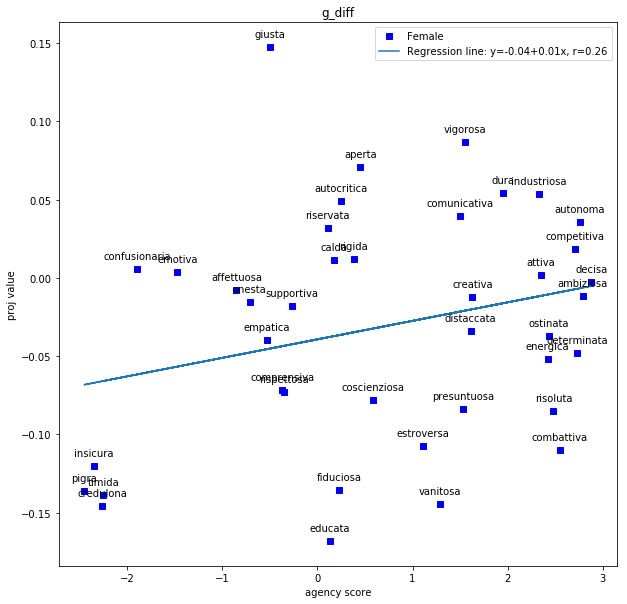

In [163]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col1, linewidth=0, marker='s', color='blue', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/ag/ft_deb_g_diff')

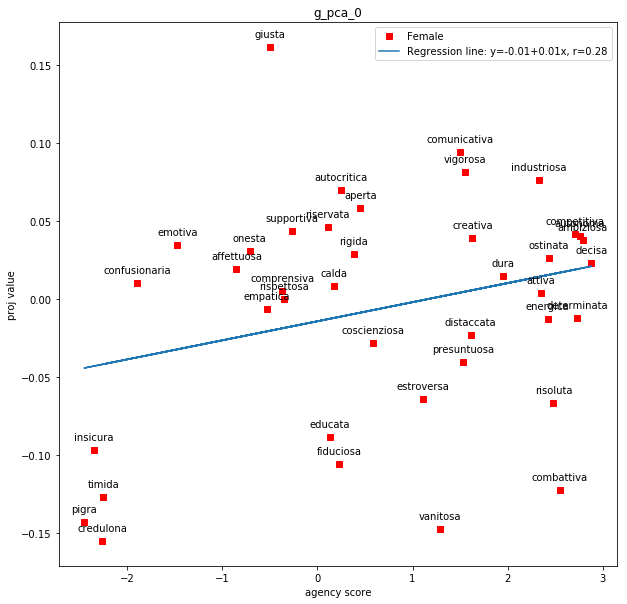

In [164]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col2, linewidth=0, marker='s', color='red', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/ag/ft_deb_g_pca_0')

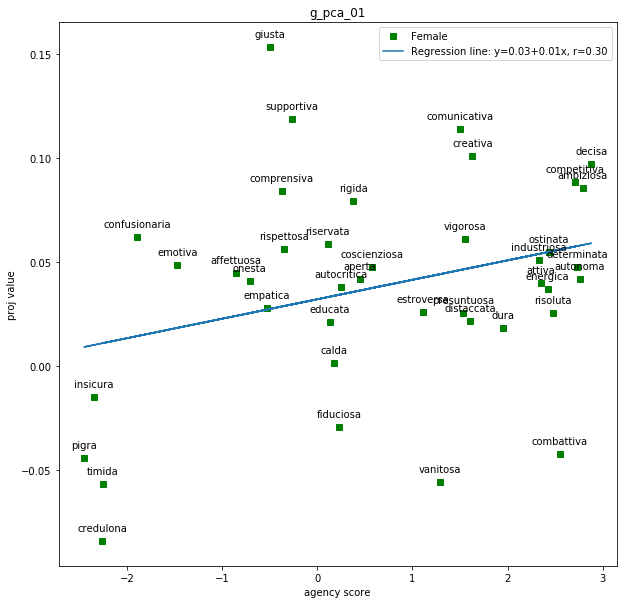

In [165]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col3, linewidth=0, marker='s', color='green', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/ag/ft_deb_g_pca_01')

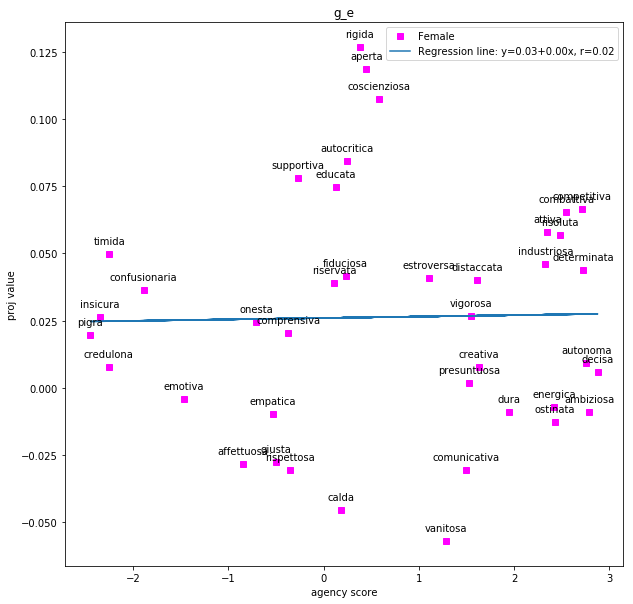

In [166]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col4, linewidth=0, marker='s', color='magenta', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/ag/ft_deb_g_e')

In [167]:
# communion correlation
r_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col1)[0]
r_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col2)[0]
r_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col3)[0]
r_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col4)[0]
p_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col1)[1]
p_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col2)[1]
p_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col3)[1]
p_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col4)[1]

In [168]:
pearson_data = {'g_diff':[r_ag_com_gen_f_g_diff,p_ag_com_gen_f_g_diff],
                'g_pca_0':[r_ag_com_gen_f_g_pca_0,p_ag_com_gen_f_g_pca_0],
                'g_pca_01':[r_ag_com_gen_f_g_pca_01,p_ag_com_gen_f_g_pca_01],
                'g_e':[r_ag_com_gen_f_g_e,p_ag_com_gen_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion female correlation")
pearson_table

Communion female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.064129  0.223395  0.265372  0.037428
p  0.694223  0.165853  0.097932  0.818646

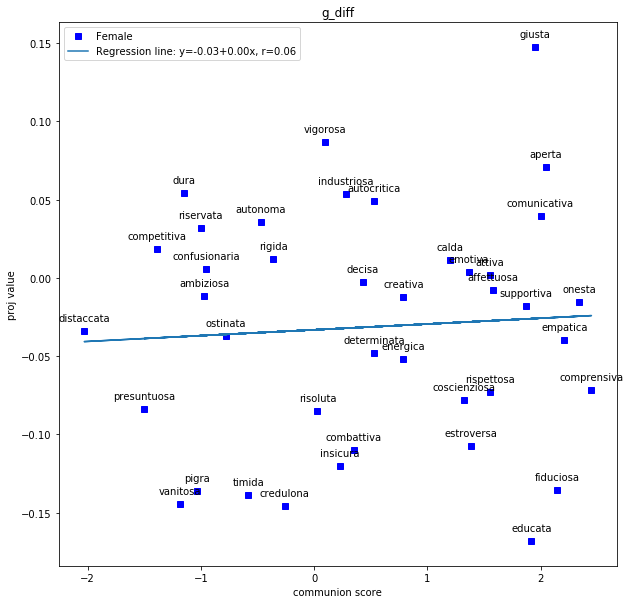

In [169]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col1, linewidth=0, marker='s', color='blue', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/com/ft_deb_g_diff')

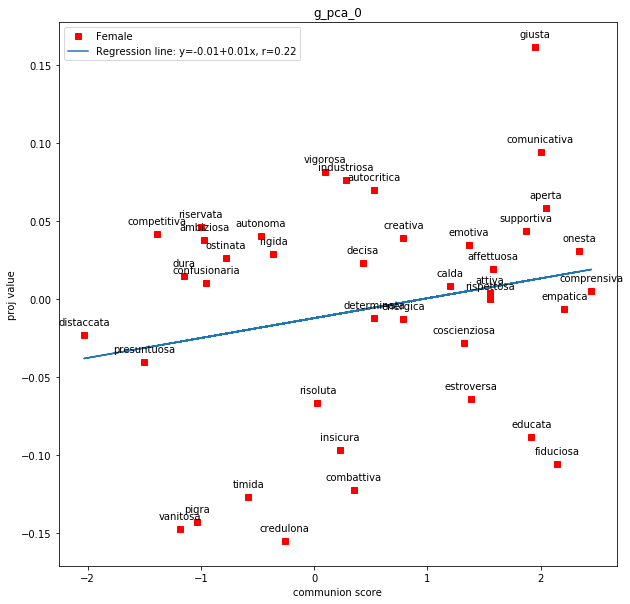

In [170]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col2, linewidth=0, marker='s', color='red', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/com/ft_deb_g_pca_0')

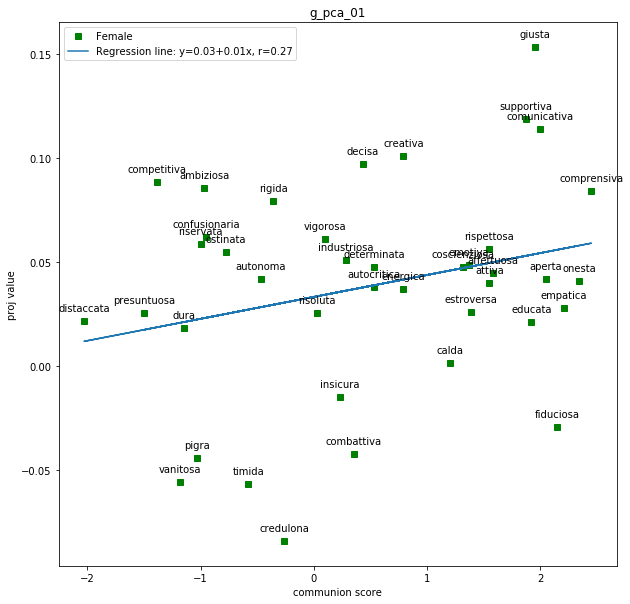

In [171]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col3, linewidth=0, marker='s', color='green', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/com/ft_deb_g_pca_01')

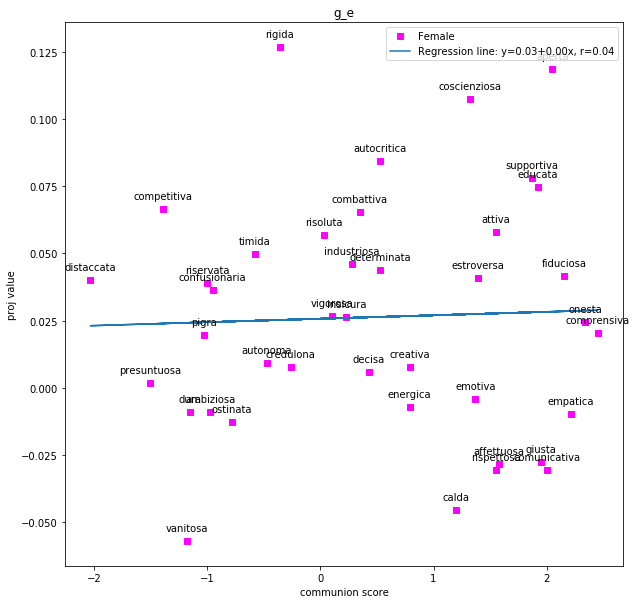

In [172]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col4, linewidth=0, marker='s', color='magenta', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/com/ft_deb_g_e')

In [173]:
# agency-communion correlation
r_ag_com_gen_f_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col1)[0]
r_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col2)[0]
r_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col3)[0]
r_ag_com_gen_f_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col4)[0]
p_ag_com_gen_f_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col1)[1]
p_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col2)[1]
p_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col3)[1]
p_ag_com_gen_f_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col4)[1]

In [174]:
pearson_data = {'g_diff':[r_ag_com_gen_f_g_diff,p_ag_com_gen_f_g_diff],
                'g_pca_0':[r_ag_com_gen_f_g_pca_0,p_ag_com_gen_f_g_pca_0],
                'g_pca_01':[r_ag_com_gen_f_g_pca_01,p_ag_com_gen_f_g_pca_01],
                'g_e':[r_ag_com_gen_f_g_e,p_ag_com_gen_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion female correlation")
pearson_table

Agency-Communion female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.153626  0.073763  0.069907 -0.006664
p  0.343922  0.651022  0.668189  0.967445

In [175]:
# both male and female agency plot

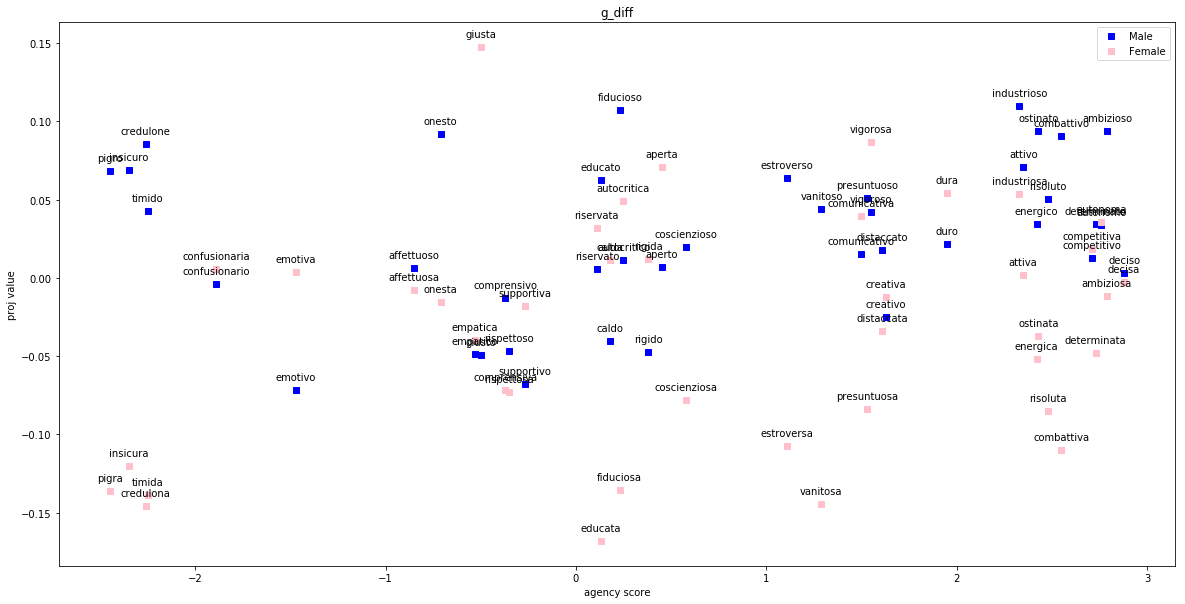

In [176]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col1, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/ag/ft_deb_g_diff')

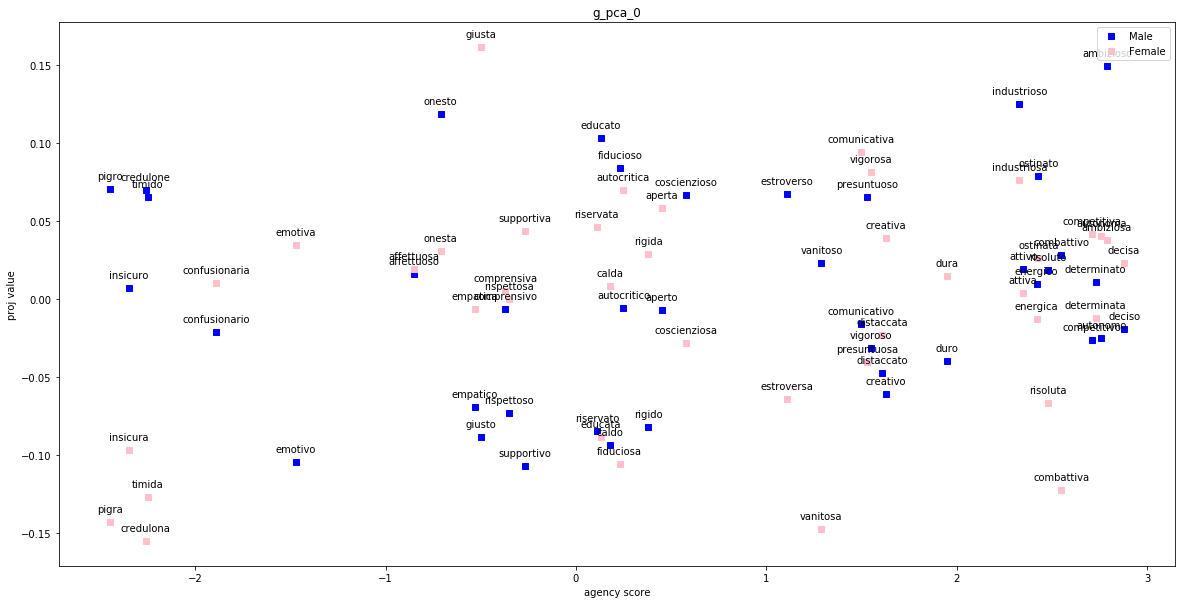

In [177]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col2, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col2, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/ag/ft_deb_g_pca_0')

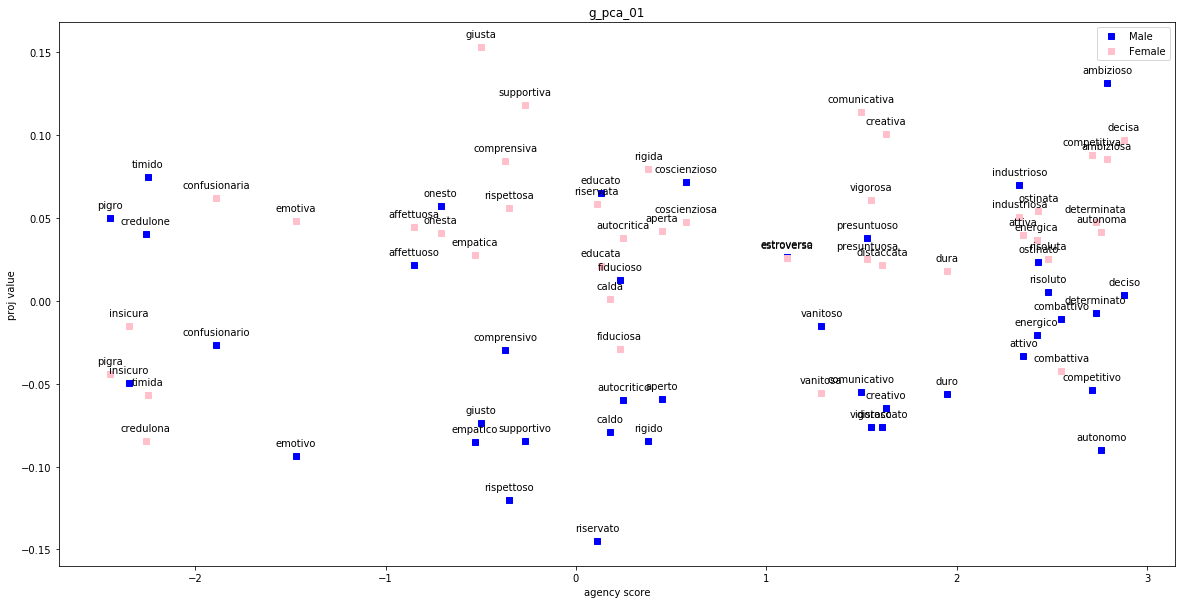

In [178]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col3, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col3, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/ag/ft_deb_g_pca_01')

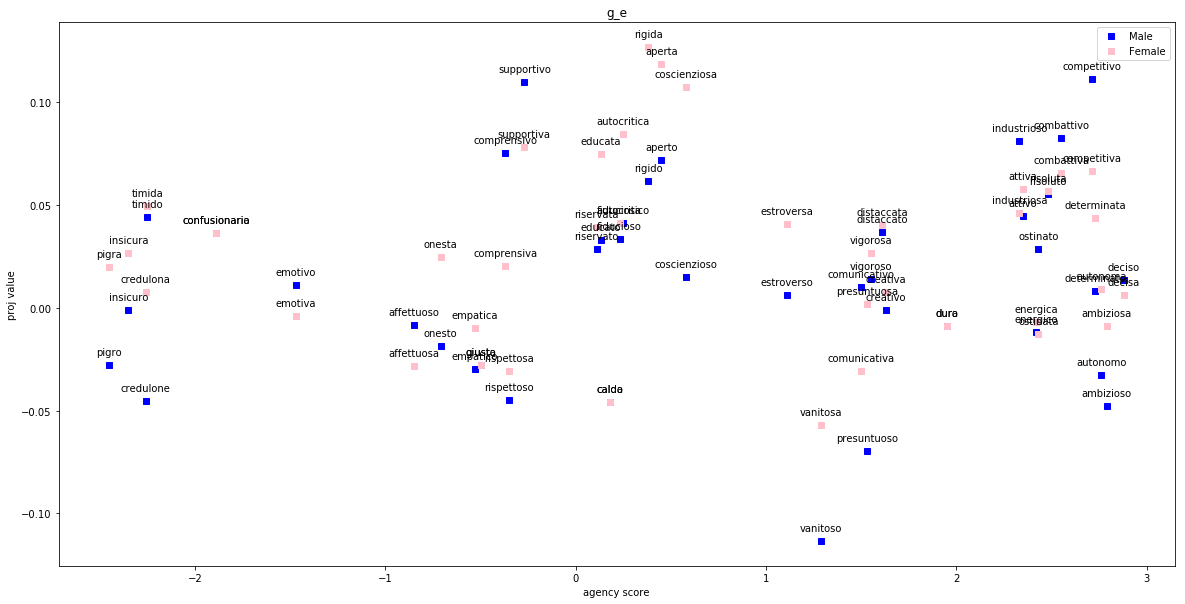

In [179]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col4, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col4, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/ag/ft_deb_g_e')

In [180]:
# both male and female communion plot

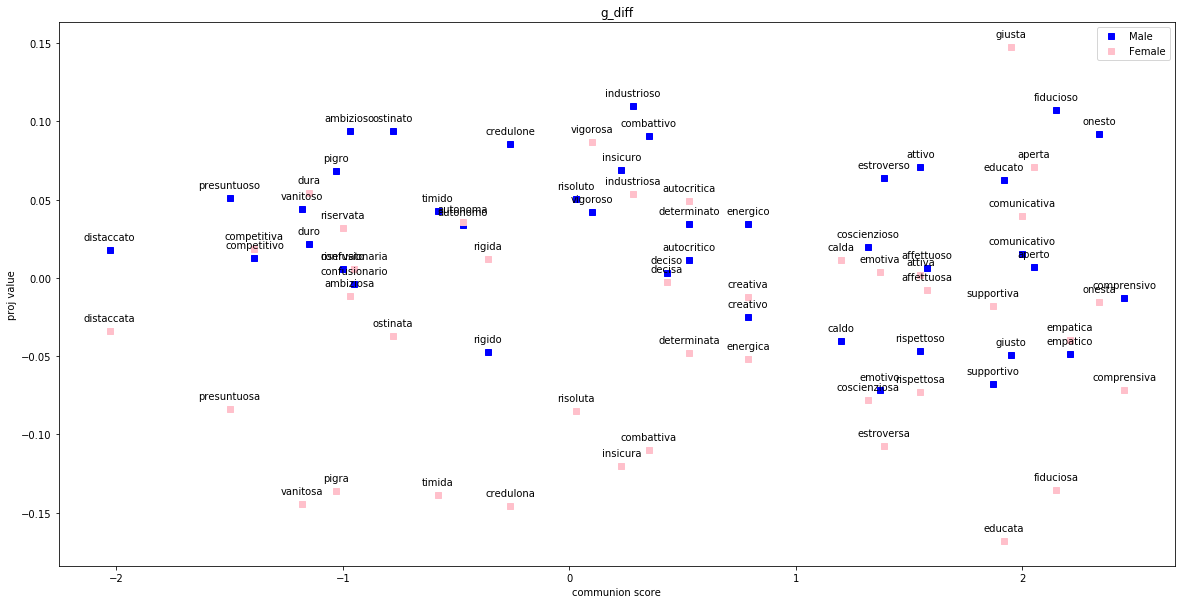

In [181]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col1, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/com/ft_deb_g_diff')

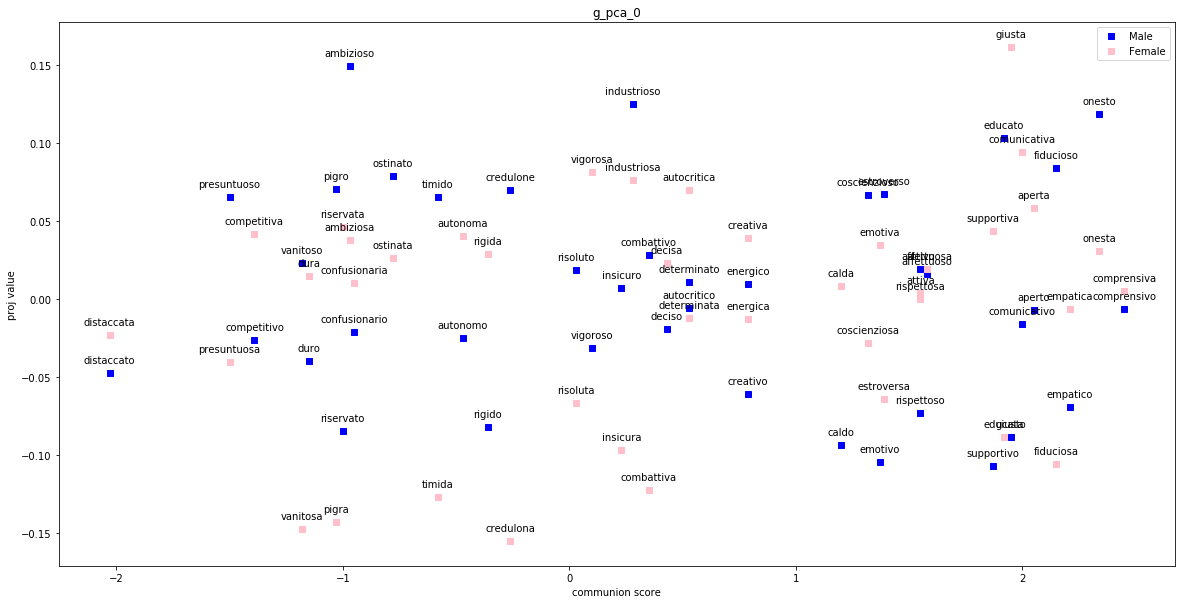

In [182]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col2, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col2, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/com/ft_deb_g_pca_0')

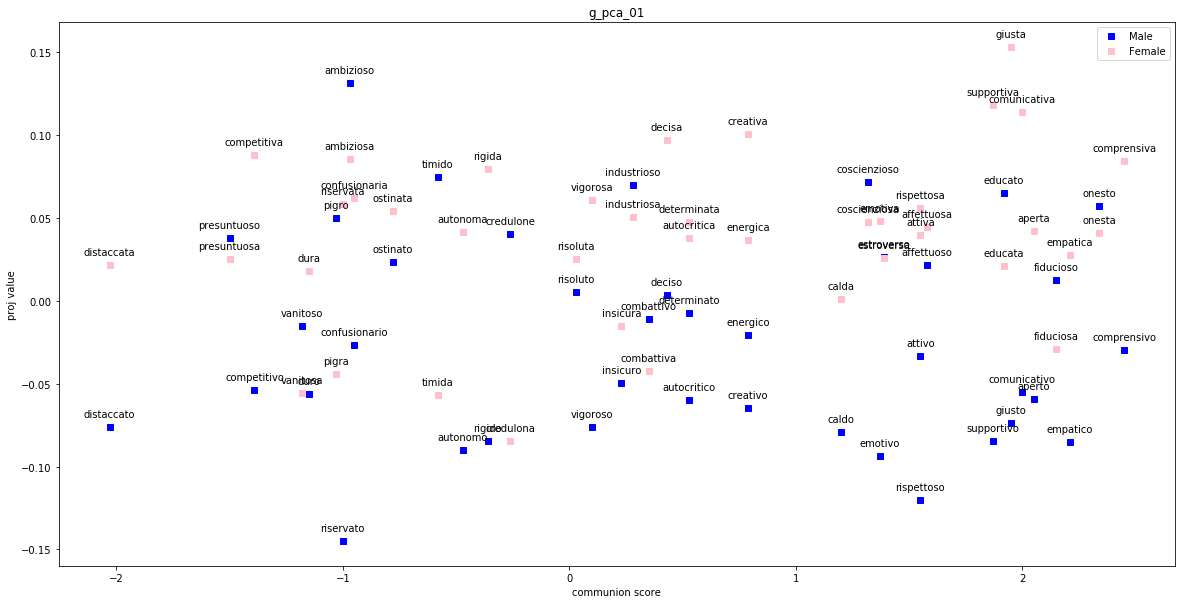

In [183]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col3, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col3, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/com/ft_deb_g_pca_01')

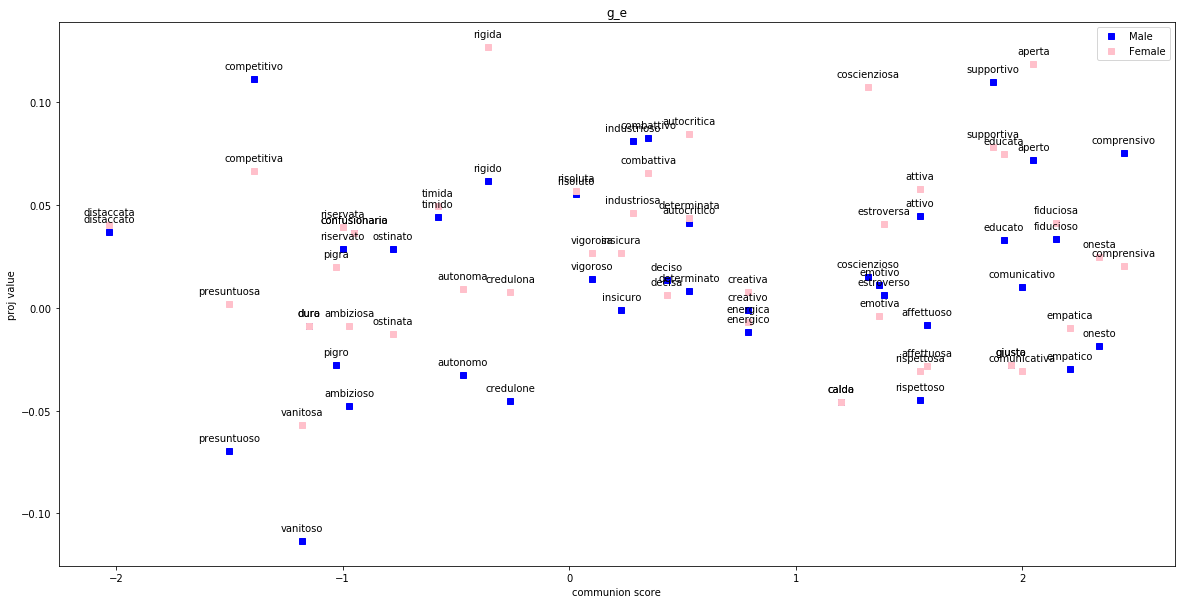

In [184]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col4, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col4, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/com/ft_deb_g_e')

##### Ungendered + mean gendered words

In [71]:
# print ag_com_mean results
ag_com_mean_col0 = [] # pandas columns
ag_com_mean_col1 = []
ag_com_mean_col2 = []
ag_com_mean_col3 = []
ag_com_mean_col4 = []
ag_com_mean_col5 = []
ag_com_mean_col6 = []

for i in range(len(proj_ag_com_ung_g_diff)):
    ag_com_mean_col0.append(proj_ag_com_ung_g_diff[i][0]) # word
    ag_com_mean_col1.append(proj_ag_com_ung_g_diff[i][1]) # projection on g_diff
    ag_com_mean_col2.append(proj_ag_com_ung_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_mean_col3.append(proj_ag_com_ung_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_mean_col4.append(np.real(proj_ag_com_ung_g_e[i][1])) # projection on g_e
    ag_com_mean_col5.append(proj_ag_com_ung_g_diff[i][2])
    ag_com_mean_col6.append(proj_ag_com_ung_g_diff[i][3])
    
for i in range(len(proj_ag_com_gen_m_g_diff)):
    ag_com_mean_col0.append(proj_ag_com_gen_m_g_diff[i][0]) # word
    ag_com_mean_col1.append((proj_ag_com_gen_m_g_diff[i][1]+proj_ag_com_gen_f_g_diff[i][1])/2) # projection on g_diff
    ag_com_mean_col2.append((proj_ag_com_gen_m_g_pca_0[i][1]+proj_ag_com_gen_f_g_pca_0[i][1])/2) # projection on g_pca_0
    ag_com_mean_col3.append((proj_ag_com_gen_m_g_pca_01[i][1]+proj_ag_com_gen_f_g_pca_01[i][1])/2) # projection on g_pca_01
    ag_com_mean_col4.append((np.real(proj_ag_com_gen_m_g_e[i][1])+np.real(proj_ag_com_gen_f_g_e[i][1]))/2) # projection on g_e
    ag_com_mean_col5.append(proj_ag_com_gen_m_g_diff[i][2])
    ag_com_mean_col6.append(proj_ag_com_gen_m_g_diff[i][3])   

ag_com_mean_data = {'Word':ag_com_mean_col0, 
               'Proj g_diff':ag_com_mean_col1,
               'Proj g_pca_0':ag_com_mean_col2, 
               'Proj g_pca_01':ag_com_mean_col3,
               'Proj g_e':ag_com_mean_col4,
               'Agency':ag_com_mean_col5,
               'Communion':ag_com_mean_col6}

ag_com_mean_table = pd.DataFrame(ag_com_mean_data)
ag_com_mean_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0           abile     0.067950      0.095182       0.054223 -0.026474    2.32   
1       altruista    -0.009973      0.014702       0.020507  0.009811   -1.18   
2          capace     0.060599      0.029318      -0.024584 -0.026633    2.45   
3      competente     0.003687     -0.000513       0.007158 -0.049972    2.21   
4        coerente     0.007508      0.024642       0.021850 -0.008620    0.74   
5       dominante     0.011981      0.008073       0.015497  0.084365    2.76   
6      amichevole     0.126366      0.082296      -0.011115  0.083360    0.15   
7     disponibile    -0.034073     -0.068511      -0.080057  0.000437   -0.42   
8         egoista     0.012170      0.052224       0.047923 -0.057813    1.53   
9    indipendente     0.043086     -0.003854      -0.025846  0.077823    2.65   
10   intelligente     0.025574      0.046485       0.028568 -0.030374    2.21   
11          leale     0.028486      0.062726       0.043906  0.082790   -0.88   
12         morale     0.039513      0.059331       0.057283  0.044066   -0.78   
13  perfezionista     0.024179     -0.017358       0.009684 -0.004887    2.15   
14    persistente    -0.004684     -0.024211      -0.004162  0.029215    1.78   
15      razionale     0.050231      0.106848       0.082840  0.022986    1.73   
16     affidabile     0.037939      0.030380       0.020902 -0.024565    0.45   
17      sensibile    -0.041643     -0.034576      -0.019307 -0.016982   -1.03   
18      socievole    -0.003621      0.000814       0.006876 -0.004512    0.66   
19     tollerante    -0.015721      0.013727       0.039538  0.032780   -0.34   
20    vulnerabile    -0.062092     -0.102184      -0.090994  0.011961   -2.29   
21         attivo     0.036595      0.011318       0.003421  0.051200    2.35   
22     affettuoso    -0.000922      0.017637       0.033184 -0.018423   -0.85   
23      ambizioso     0.041069      0.093279       0.108394 -0.028305    2.79   
24         deciso     0.000261      0.002112       0.050414  0.009694    2.88   
25       vanitoso    -0.050211     -0.062362      -0.035471 -0.085282    1.29   
26  confusionario     0.000757     -0.005609       0.017897  0.036297   -1.89   
27   comunicativo     0.027286      0.038995       0.029633 -0.010354    1.50   
28    competitivo     0.015536      0.007592       0.017303  0.088851    2.71   
29    presuntuoso    -0.016389      0.012354       0.031863 -0.033877    1.53   
..            ...          ...           ...            ...       ...     ...   
31     rispettoso    -0.060043     -0.036781      -0.031961 -0.037808   -0.35   
32       creativo    -0.018536     -0.010684       0.018153  0.003314    1.63   
33     distaccato    -0.008187     -0.035167      -0.027191  0.038483    1.61   
34    determinato    -0.006996     -0.000586       0.020093  0.025938    2.73   
35         rigido    -0.017890     -0.026543      -0.002452  0.094347    0.38   
36        emotivo    -0.033817     -0.034931      -0.022622  0.003449   -1.47   
37       energico    -0.008772     -0.001835       0.008106 -0.009444    2.42   
38         giusto     0.049272      0.036520       0.039830 -0.027702   -0.50   
39      credulone    -0.030310     -0.042761      -0.021986 -0.018869   -2.26   
40           duro     0.037680     -0.012637      -0.018967 -0.008927    1.95   
41         onesto     0.038175      0.074494       0.049052  0.003031   -0.71   
42    industrioso     0.081827      0.100316       0.060424  0.063657    2.33   
43       insicuro    -0.025448     -0.044999      -0.032200  0.012581   -2.35   
44          pigro    -0.033972     -0.036133       0.003105 -0.004141   -2.45   
45       ostinato     0.028539      0.052415       0.038944  0.007879    2.43   
46         aperto     0.038929      0.025556      -0.008510  0.095258    0.45   
47     estroverso    -0.021872      0.001630       0.026193  0.023563    1.11   
48        educato    -0.052701      0.007276

In [72]:
# ag_com_mean pearson correlation
# agency correlation
r_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col1)[0]
r_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col2)[0]
r_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col3)[0]
r_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col4)[0]
p_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col1)[1]
p_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col2)[1]
p_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col3)[1]
p_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col4)[1]

In [73]:
pearson_data = {'g_diff':[r_ag_com_mean_g_diff,p_ag_com_mean_g_diff],
                'g_pca_0':[r_ag_com_mean_g_pca_0,p_ag_com_mean_g_pca_0],
                'g_pca_01':[r_ag_com_mean_g_pca_01,p_ag_com_mean_g_pca_01],
                'g_e':[r_ag_com_mean_g_e,p_ag_com_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency mean correlation")
pearson_table

Agency mean correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.437294  0.337622  0.261258 -0.000130
p  0.000425  0.007791  0.041977  0.999206

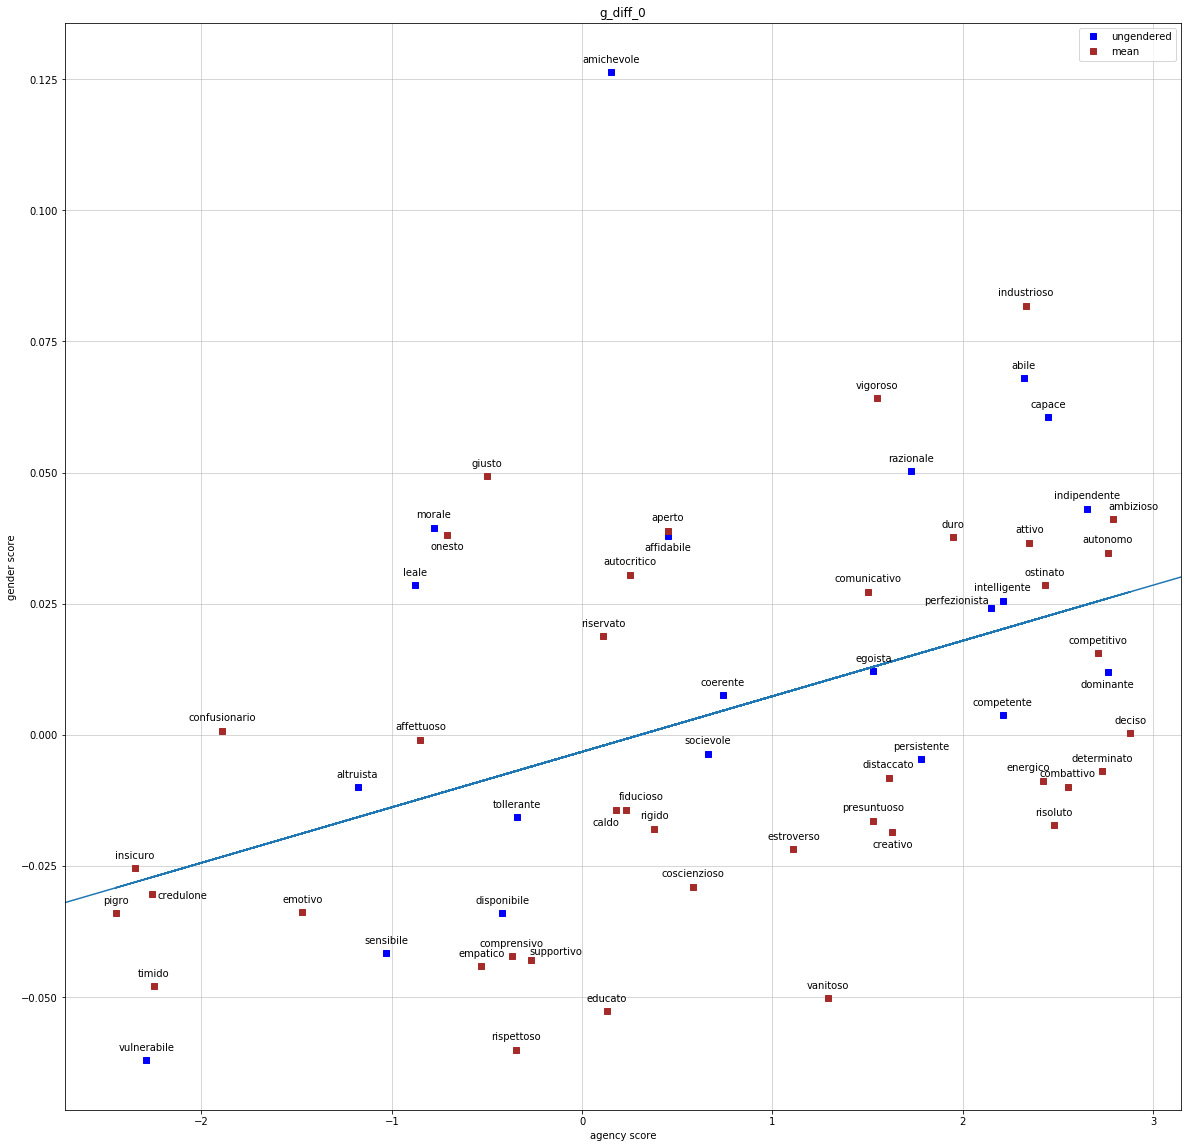

In [74]:
# correlation plot g_diff

'''
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(ag_com_ung_col5, ag_com_ung_col1, linewidth=0, marker='s', color='blue', label='ungendered')
#ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
xlims = plt.xlim()
x = [i for i in ag_com_ung_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x), label=line)
plt.xlim(xlims)
ax.set_xlabel('agency score')
ax.set_ylabel('gender score')
ax.set_title("g_diff_0")
ax.legend()

for i, label in enumerate(ag_com_ung_col0):
    if label=='vulnerabile':
        plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue

    if label=='dominante':
        plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
'''

slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(ag_com_mean_col5[:21], ag_com_mean_col1[:21], linewidth=0, marker='s', color='blue', label='ungendered')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col1[21:], linewidth=0, marker='s', color='brown', label='mean')
#ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
xlims = plt.xlim()
x = [i for i in ag_com_mean_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_xlabel('agency score')
ax.set_ylabel('gender score')
ax.set_title("g_diff_0")
ax.legend()

for i, label in enumerate(ag_com_mean_col0):
    if label=='affidabile':
        plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='supportivo':
        plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(25,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue   
        
    if label=='credulone':
        plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,-5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='onesto':
        plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
        
    if label=='caldo':
        plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
        
    if label=='fiducioso':
        plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(15,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
    if label=='perfezionista':
        plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-35,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
    if label=='creativo':
        plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue       
    if label=='energico':
        plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-15,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
    if label=='ambizioso':
        plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
    if label=='dominante':
        plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/ag/ft_deb_g_diff.pdf', bbox_inches='tight', format='pdf')

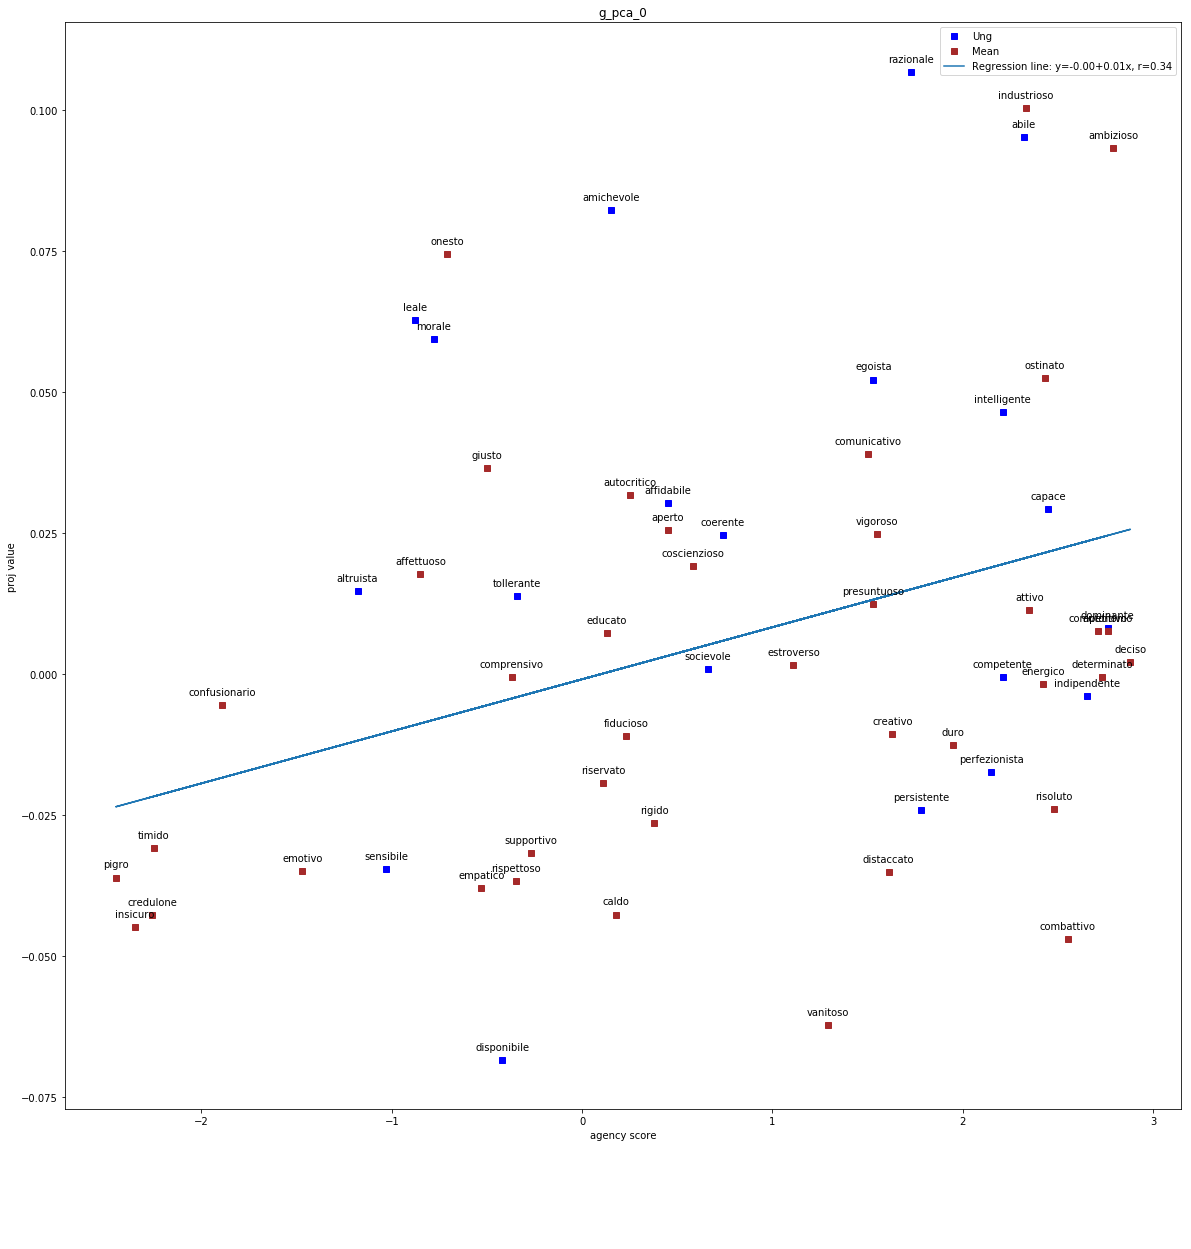

In [189]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col2[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col2[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/ag/ft_deb_g_pca_0')

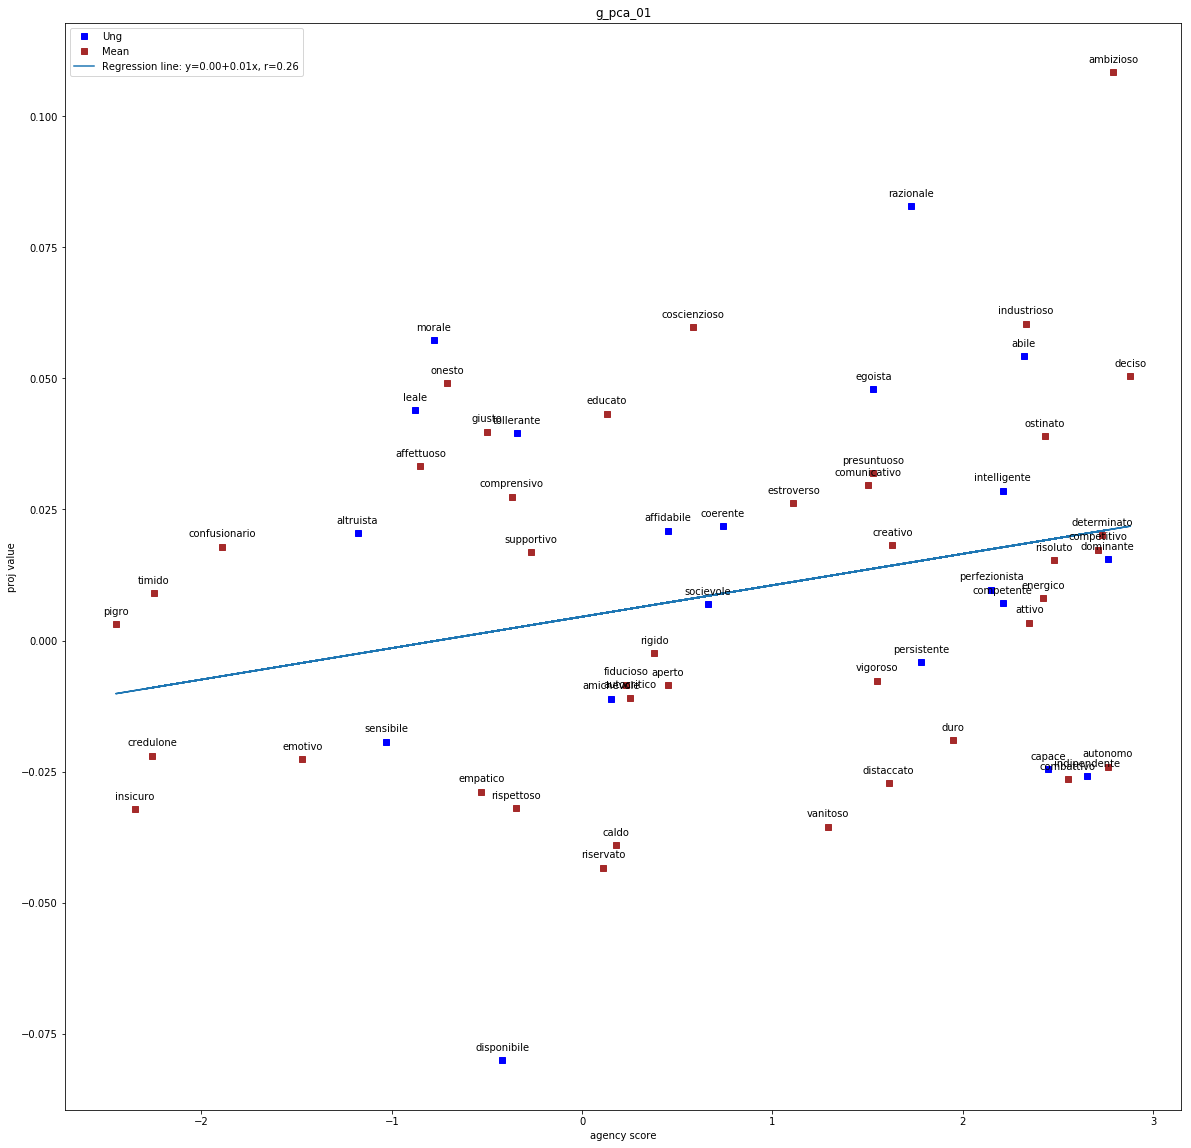

In [190]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col3[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col3[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/ag/ft_deb_g_pca_01')

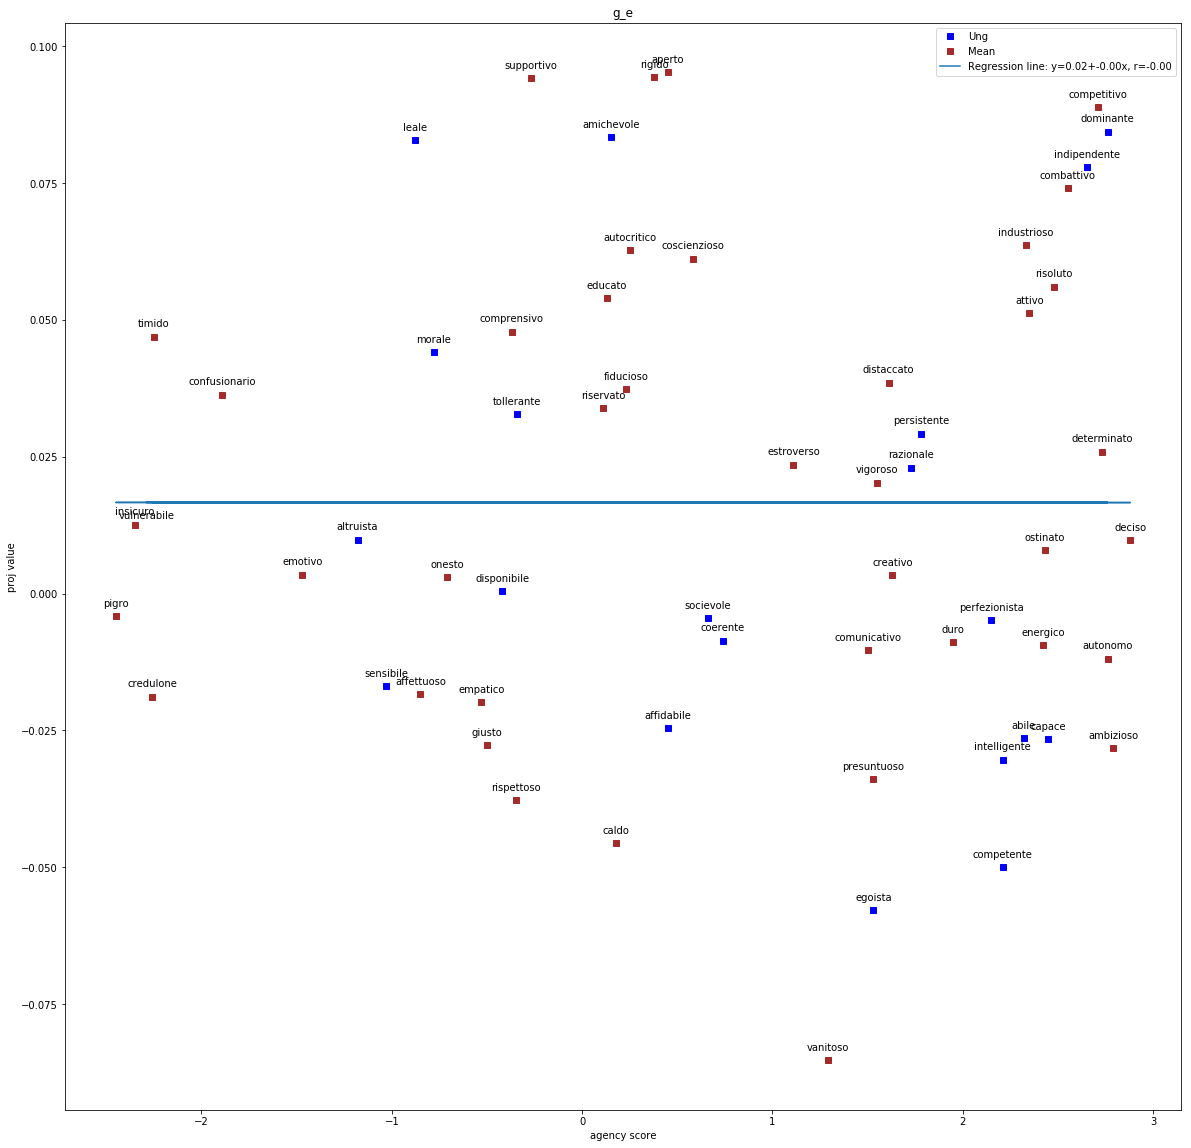

In [191]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col4[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col4[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/ag/ft_deb_g_e')

In [193]:
# communion correlation
r_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col1)[0]
r_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col2)[0]
r_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col3)[0]
r_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col4)[0]
p_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col1)[1]
p_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col2)[1]
p_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col3)[1]
p_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col4)[1]

In [194]:
pearson_data = {'g_diff':[r_ag_com_mean_g_diff,p_ag_com_mean_g_diff],
                'g_pca_0':[r_ag_com_mean_g_pca_0,p_ag_com_mean_g_pca_0],
                'g_pca_01':[r_ag_com_mean_g_pca_01,p_ag_com_mean_g_pca_01],
                'g_e':[r_ag_com_mean_g_e,p_ag_com_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion mean correlation")
pearson_table

Communion mean correlation


g_diff   g_pca_0  g_pca_01       g_e
r -0.018579  0.124956  0.054488  0.050177
p  0.886988  0.337301  0.676625  0.700956

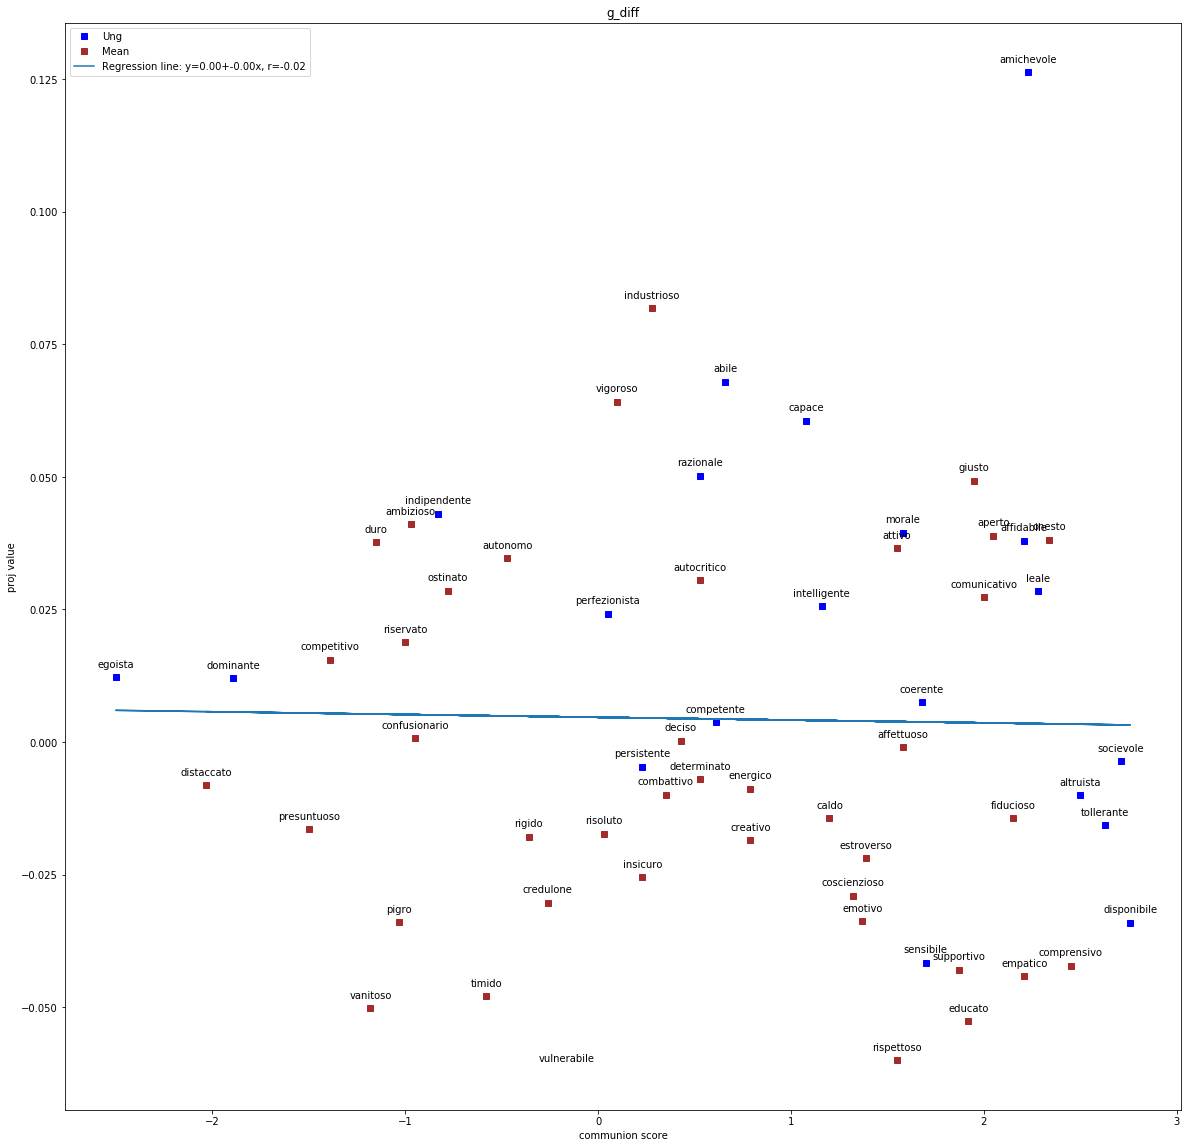

In [195]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col1[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col1[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/com/ft_deb_g_diff')

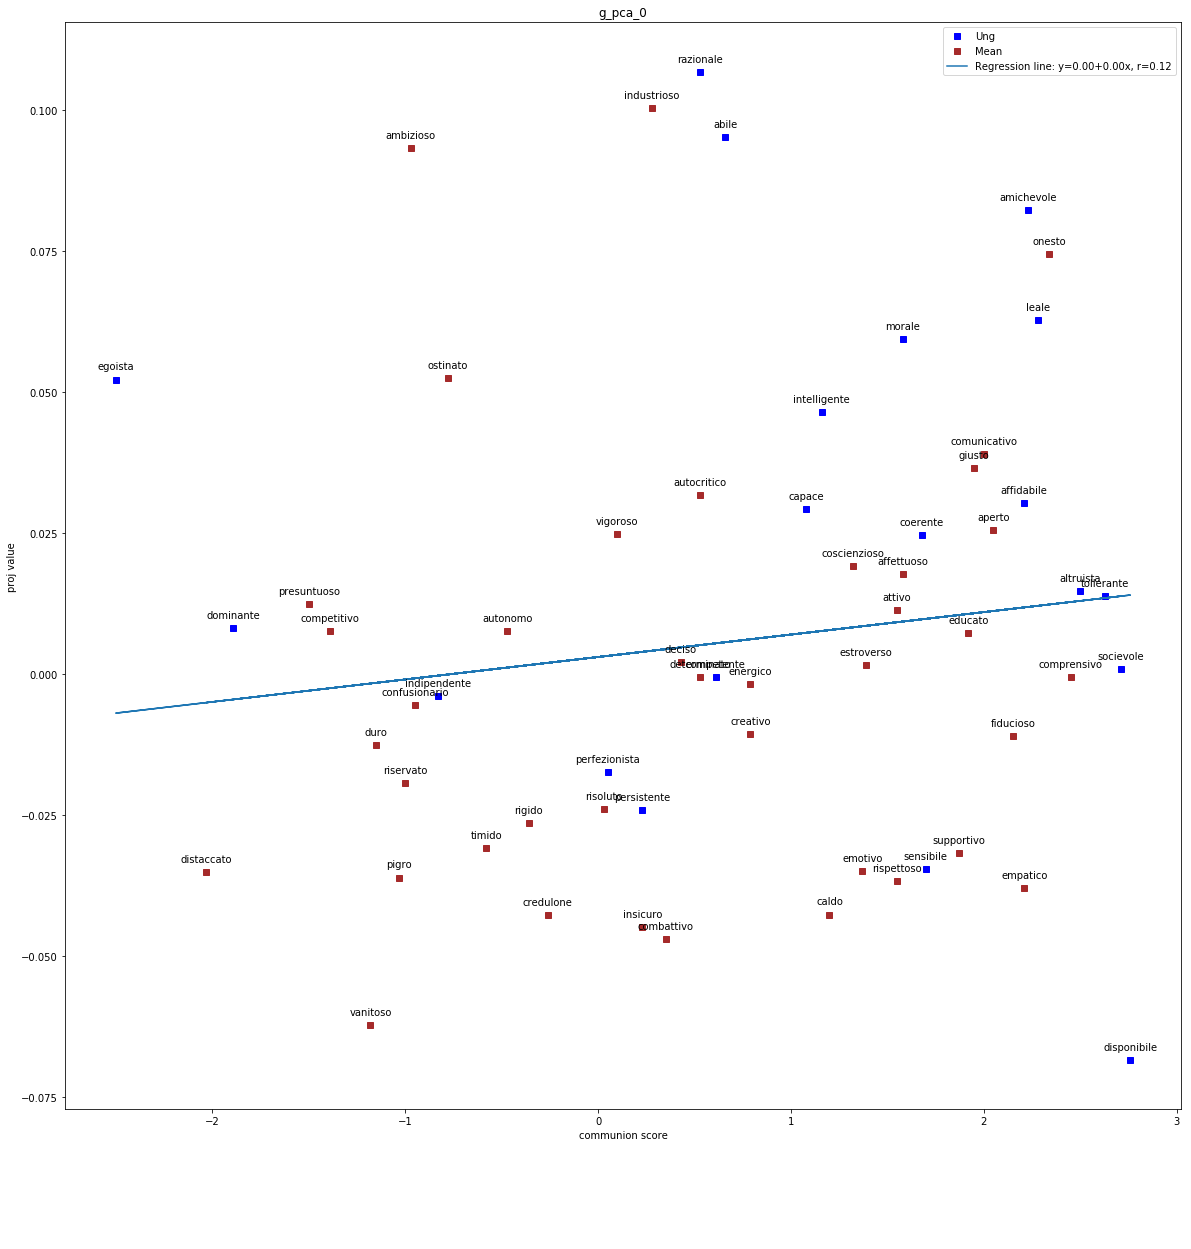

In [196]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col2[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col2[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/com/ft_deb_g_pca_0')

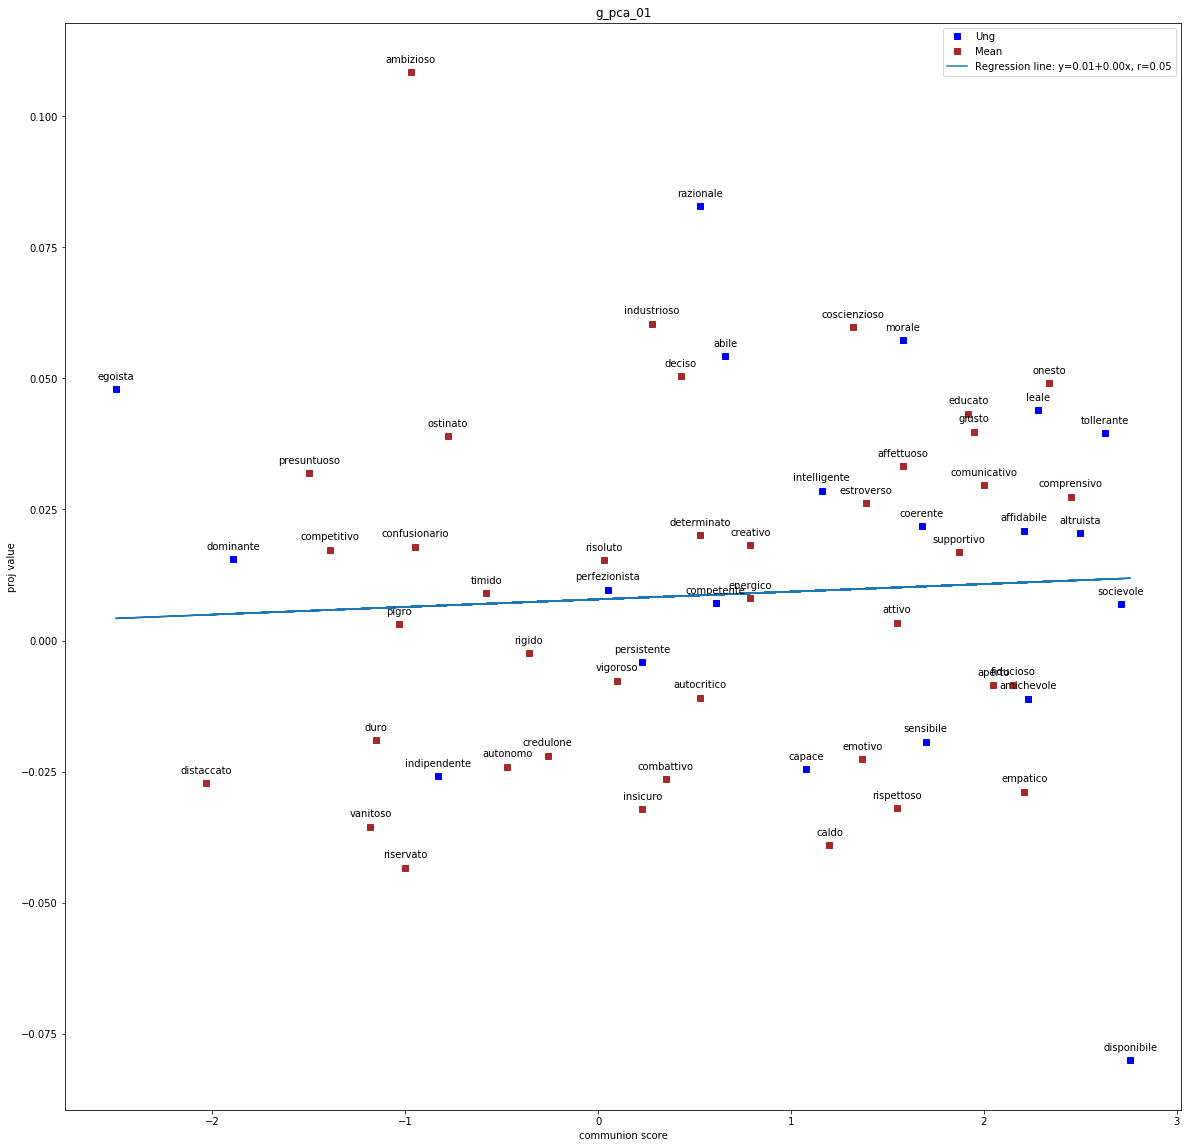

In [197]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col3[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col3[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/com/ft_deb_g_pca_01')

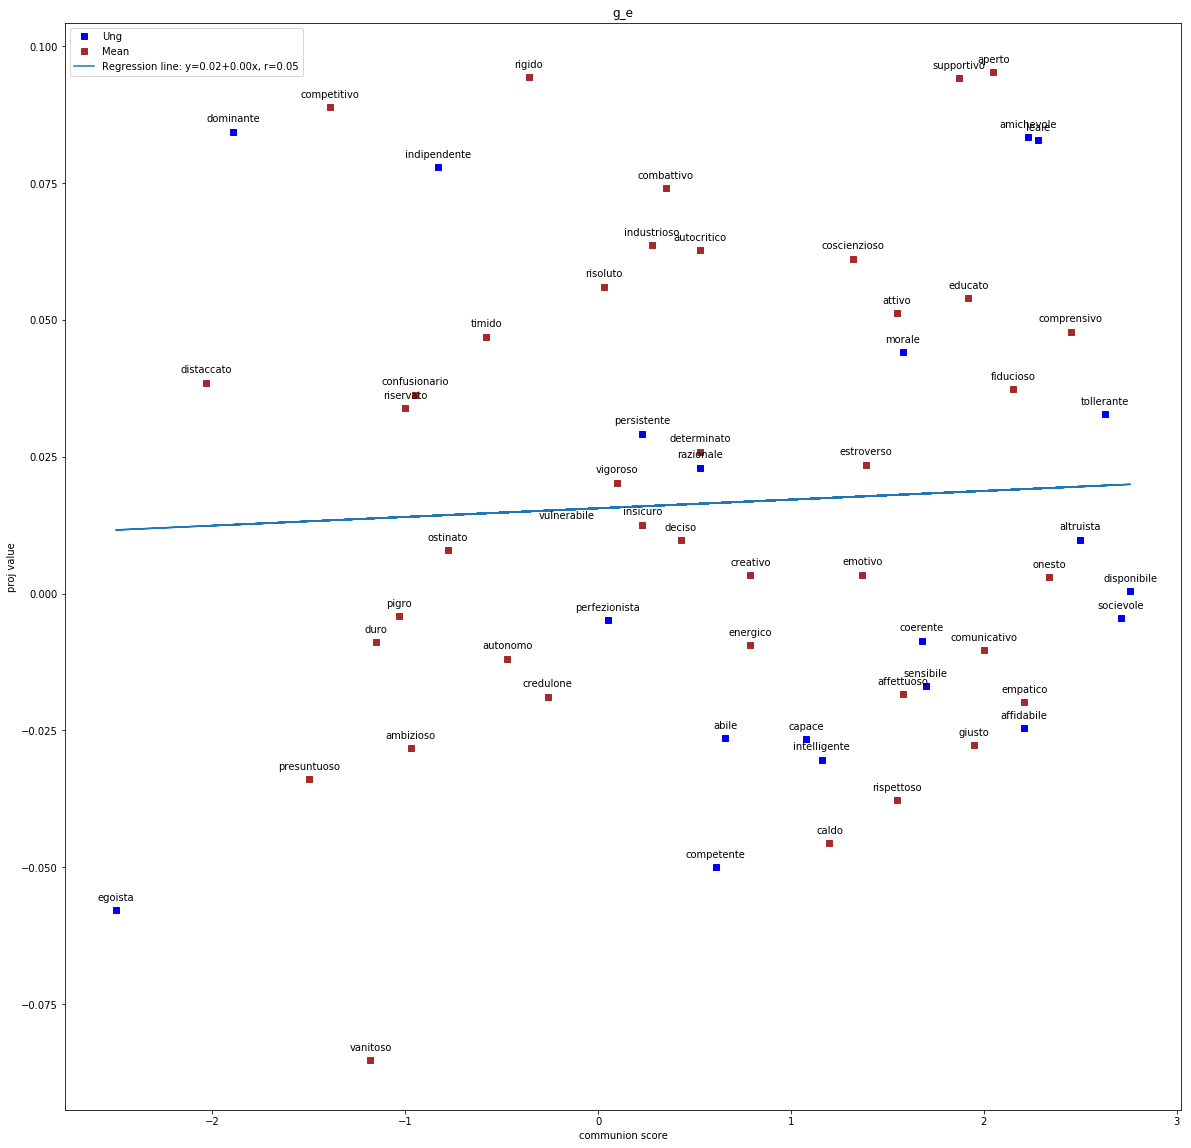

In [198]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col4[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col4[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/com/ft_deb_g_e')

In [199]:
# agency-communion correlation
r_ag_com_mean_g_diff = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col1)[0]
r_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col2)[0]
r_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col3)[0]
r_ag_com_mean_g_e = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col4)[0]
p_ag_com_mean_g_diff = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col1)[1]
p_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col2)[1]
p_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col3)[1]
p_ag_com_mean_g_e = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col4)[1]

In [200]:
pearson_data = {'g_diff':[r_ag_com_mean_g_diff,p_ag_com_mean_g_diff],
                'g_pca_0':[r_ag_com_mean_g_pca_0,p_ag_com_mean_g_pca_0],
                'g_pca_01':[r_ag_com_mean_g_pca_01,p_ag_com_mean_g_pca_01],
                'g_e':[r_ag_com_mean_g_e,p_ag_com_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion mean correlation")
pearson_table

Agency-Communion mean correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.301238  0.153121  0.142561 -0.028707
p  0.018317  0.238744  0.273073  0.826168

### Step 3: working with Gonen's embeddings

#### Step 3.1: repeating steps 2.1-2.5

In [201]:
# gender direction
g_diff = E_g.diff('lui', 'lei')

In [202]:
# list of pairs to define gender
gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [203]:
# PCA
pca = we.doPCA(gender_pairs, E_g)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [204]:
print("Singular values:")
print(sv)

Singular values:
[6.73165823e-01 4.74985087e-01 4.38029897e-01 3.35332203e-01
 2.90767211e-01 2.36732569e-01 1.27794811e-16 1.13799029e-16
 9.10948385e-17 8.73430101e-17]


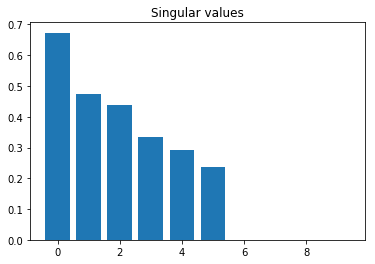

In [205]:
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()

In [206]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])
g_pca_01 = (sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1])/LA.norm((sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1]))

In [207]:
S_word = [['lui','lei'],
          ['uomo','donna'], 
          ['padre','madre'],
          ['marito','moglie'],
          ['fratello','sorella'],
          ['maschio','femmina']]

G_word = db.read('gram_def_mf.txt', 'mf')

In [208]:
S_m_v = []
for w in S_word:
    S_m_v.append(E_g.v(w[1]))
    
S_f_v = []
for w in S_word:
    S_f_v.append(E_g.v(w[0]))
    
G_m_v = []
for w in G_word:
    G_m_v.append(E_g.v(w[0]))
    
G_f_v = []
for w in G_word:
    G_f_v.append(E_g.v(w[1]))

S_m = np.array(S_m_v).T
S_f = np.array(S_f_v).T
G_m = np.array(G_m_v).T
G_f = np.array(G_f_v).T

In [209]:
# delta semantic
Delta_S = np.dot(np.subtract(S_m, S_f), np.subtract(S_m, S_f).T)

# delta grammatical
Delta_G = np.dot(np.subtract(G_m, G_f), np.subtract(G_m, G_f).T)

# A
A = np.dot(np.linalg.inv(Delta_G), Delta_S)

In [210]:
# eigenvalues and eigenvectors
w, v = np.linalg.eig(A)

# gender direction: pick the eigenvector associated to the largest eigenvalue
g_e = v[:,np.argmax(w)] # already normalized

In [211]:
# words
ag_com_ung = db.read('ag_com_ung_ita.txt', 'ag-com-mf')

In [212]:
# compute projections
# all words ungendered
proj_ag_com_ung_g_diff =  db.prof_proj(E_g, ag_com_ung, g_diff, 'ag-com-m')
proj_ag_com_ung_g_pca_0 =  db.prof_proj(E_g, ag_com_ung, g_pca_0, 'ag-com-m')
proj_ag_com_ung_g_pca_01 =  db.prof_proj(E_g, ag_com_ung, g_pca_01, 'ag-com-m')
proj_ag_com_ung_g_e =  db.prof_proj(E_g, ag_com_ung, g_e, 'ag-com-m')

In [213]:
# print ag_com_ung results
ag_com_ung_col0 = [] # pandas columns
ag_com_ung_col1 = []
ag_com_ung_col2 = []
ag_com_ung_col3 = []
ag_com_ung_col4 = []
ag_com_ung_col5 = []
ag_com_ung_col6 = []

for i in range(len(proj_ag_com_ung_g_diff)):
    ag_com_ung_col0.append(proj_ag_com_ung_g_diff[i][0]) # word
    ag_com_ung_col1.append(proj_ag_com_ung_g_diff[i][1]) # projection on g_diff
    ag_com_ung_col2.append(proj_ag_com_ung_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_ung_col3.append(proj_ag_com_ung_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_ung_col4.append(np.real(proj_ag_com_ung_g_e[i][1])) # projection on g_e
    ag_com_ung_col5.append(proj_ag_com_ung_g_diff[i][2])
    ag_com_ung_col6.append(proj_ag_com_ung_g_diff[i][3])

ag_com_ung_data = {'Word':ag_com_ung_col0, 
               'Proj g_diff':ag_com_ung_col1,
               'Proj g_pca_0':ag_com_ung_col2, 
               'Proj g_pca_01':ag_com_ung_col3,
               'Proj g_e':ag_com_ung_col4,
               'Agency':ag_com_ung_col5,
               'Communion':ag_com_ung_col6}

ag_com_ung_table = pd.DataFrame(ag_com_ung_data)
ag_com_ung_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0           abile     0.059056     -0.113135      -0.023355  0.112070    2.32   
1       altruista    -0.115441     -0.013627       0.008819  0.065061   -1.18   
2          capace     0.026271     -0.020479      -0.026877  0.053098    2.45   
3      competente     0.059333     -0.066472      -0.013275  0.059932    2.21   
4        coerente     0.021684     -0.035207      -0.037364 -0.014060    0.74   
5       dominante    -0.032145     -0.024013       0.036617 -0.024821    2.76   
6      amichevole    -0.011846      0.081167       0.099525  0.031213    0.15   
7     disponibile    -0.116799      0.034990       0.024886  0.017821   -0.42   
8         egoista    -0.161264     -0.018887      -0.032528  0.085321    1.53   
9    indipendente    -0.001864      0.028230       0.034211 -0.044919    2.65   
10   intelligente    -0.046631     -0.002014       0.018938  0.003886    2.21   
11          leale     0.001660     -0.058370       0.015543  0.021318   -0.88   
12         morale     0.081215     -0.060236      -0.029617  0.071533   -0.78   
13  perfezionista    -0.088548      0.000455       0.027781 -0.041557    2.15   
14    persistente    -0.074985      0.047052       0.031250  0.072091    1.78   
15      razionale     0.034658     -0.078759      -0.104205 -0.023670    1.73   
16     affidabile     0.093735     -0.040602      -0.006190 -0.017933    0.45   
17      sensibile    -0.106242     -0.019653      -0.027386  0.021225   -1.03   
18      socievole    -0.142771      0.010607      -0.006720 -0.002590    0.66   
19     tollerante     0.000960     -0.094010      -0.039732  0.069157   -0.34   
20    vulnerabile    -0.113564      0.015015       0.034551 -0.004593   -2.29   

    Communion  
0        0.66  
1        2.50  
2        1.08  
3        0.61  
4        1.68  
5       -1.89  
6        2.23  
7        2.76  
8       -2.50  
9       -0.83  
10       1.16  
11       2.28  
12       1.58  
13       0.05  
14       0.23  
15       0.53  
16       2.21  
17       1.70  
18       2.71  
19       2.63  
20      -0.16

In [214]:
# ag_com_ung pearson correlation
# agency correlation
r_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col1)[0]
r_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col2)[0]
r_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col3)[0]
r_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col4)[0]
p_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col1)[1]
p_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col2)[1]
p_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col3)[1]
p_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col4)[1]

In [215]:
pearson_data = {'g_diff':[r_ag_com_ung_g_diff,p_ag_com_ung_g_diff],
                'g_pca_0':[r_ag_com_ung_g_pca_0,p_ag_com_ung_g_pca_0],
                'g_pca_01':[r_ag_com_ung_g_pca_01,p_ag_com_ung_g_pca_01],
                'g_e':[r_ag_com_ung_g_e,p_ag_com_ung_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency ungendered correlation")
pearson_table

Agency ungendered correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.249540 -0.068168 -0.068997 -0.106788
p  0.275323  0.769063  0.766331  0.644998

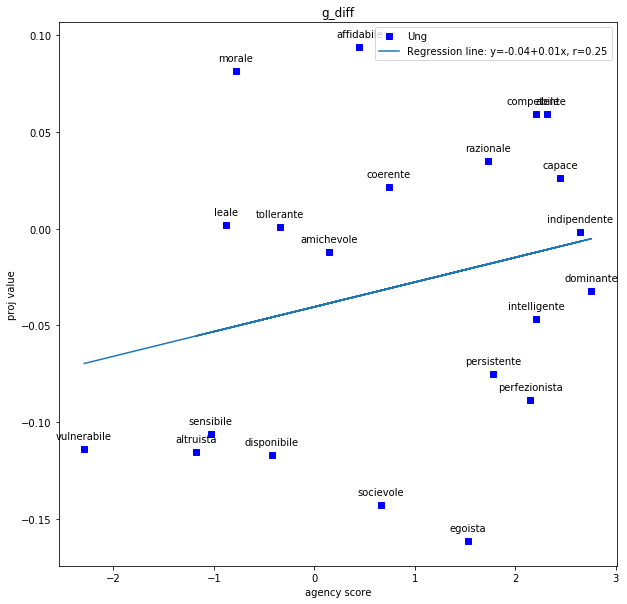

In [216]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col5, ag_com_ung_col1, linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/ag/g_g_diff')

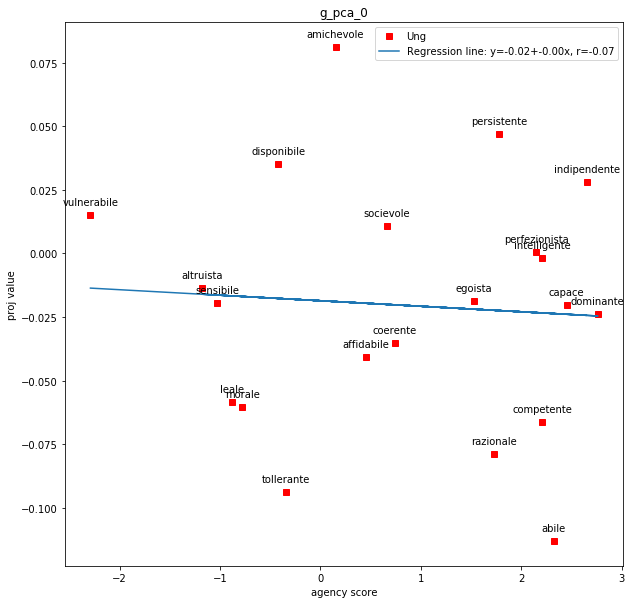

In [217]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col5, ag_com_ung_col2, linewidth=0, marker='s', color='red', label='Ung')
ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/ag/g_g_pca_0')

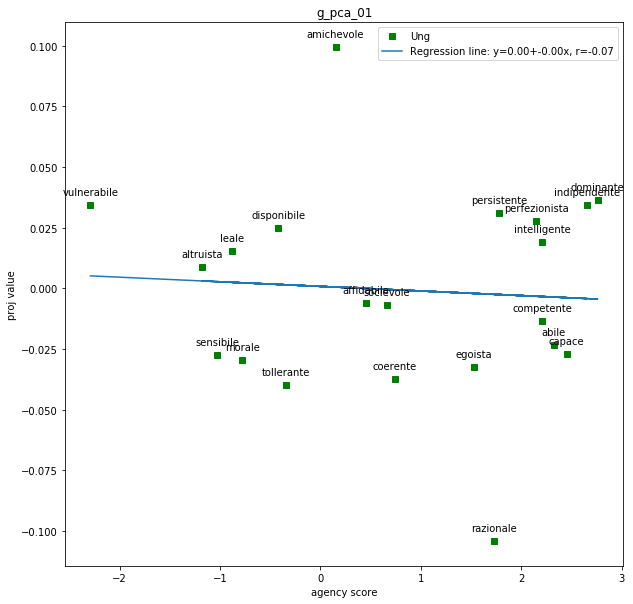

In [218]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col5, ag_com_ung_col3, linewidth=0, marker='s', color='green', label='Ung')
ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/ag/g_g_pca_01')

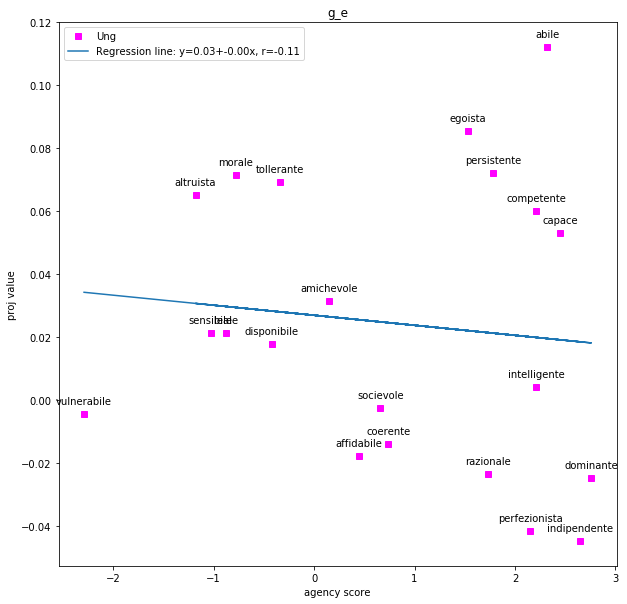

In [219]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col5, ag_com_ung_col4, linewidth=0, marker='s', color='magenta', label='Ung')
ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/ag/g_g_e')

In [220]:
# communion correlation
r_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col1)[0]
r_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col2)[0]
r_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col3)[0]
r_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col4)[0]
p_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col1)[1]
p_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col2)[1]
p_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col3)[1]
p_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col4)[1]

In [221]:
pearson_data = {'g_diff':[r_ag_com_ung_g_diff,p_ag_com_ung_g_diff],
                'g_pca_0':[r_ag_com_ung_g_pca_0,p_ag_com_ung_g_pca_0],
                'g_pca_01':[r_ag_com_ung_g_pca_01,p_ag_com_ung_g_pca_01],
                'g_e':[r_ag_com_ung_g_e,p_ag_com_ung_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion ungendered correlation")
pearson_table

Communion ungendered correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.149139 -0.039698 -0.022745  0.090656
p  0.518789  0.864344  0.922043  0.695941

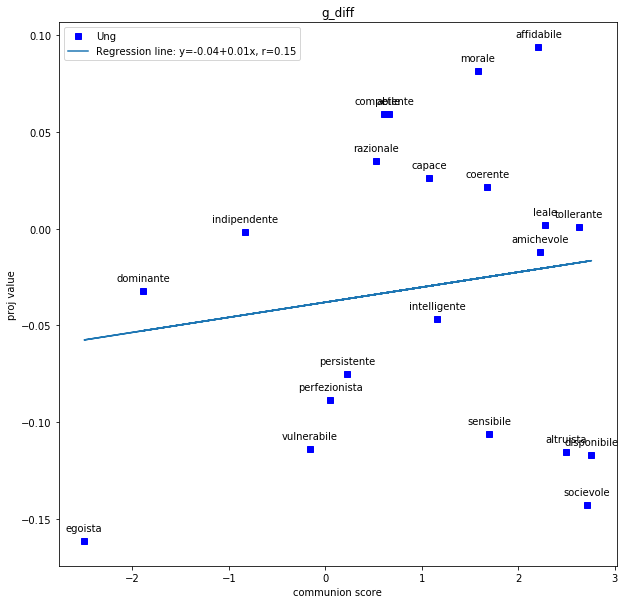

In [222]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col1, linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/com/g_g_diff')

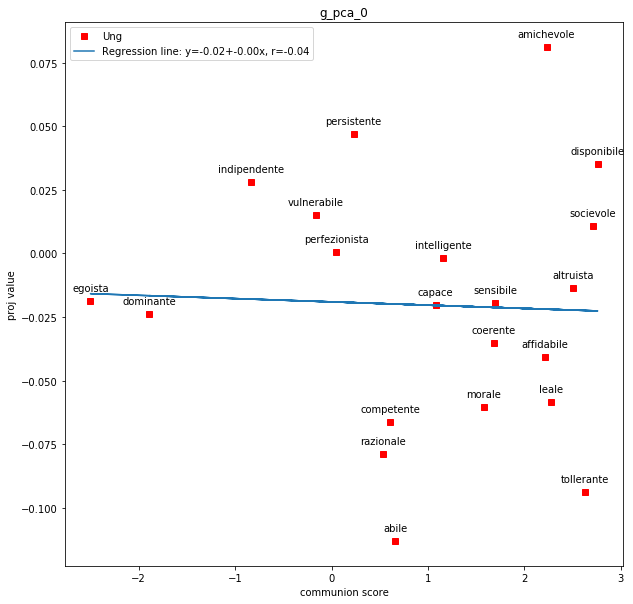

In [223]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col2, linewidth=0, marker='s', color='red', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/com/g_g_pca_0')

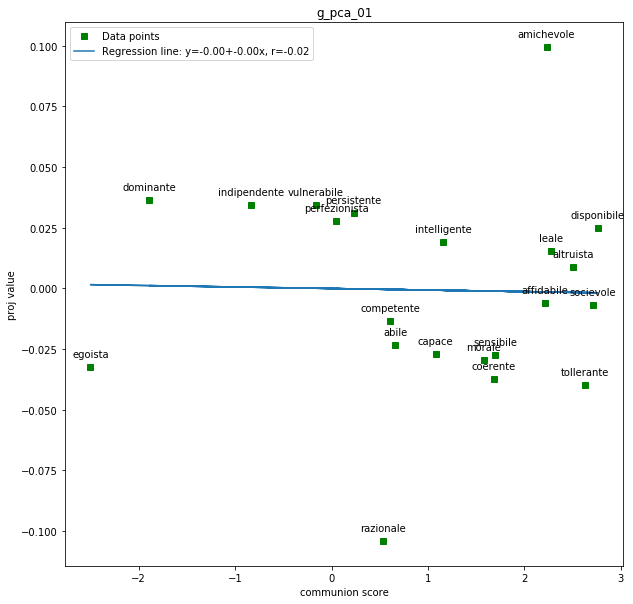

In [224]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col3, linewidth=0, marker='s', color='green', label='Data points')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/com/g_g_pca_01')

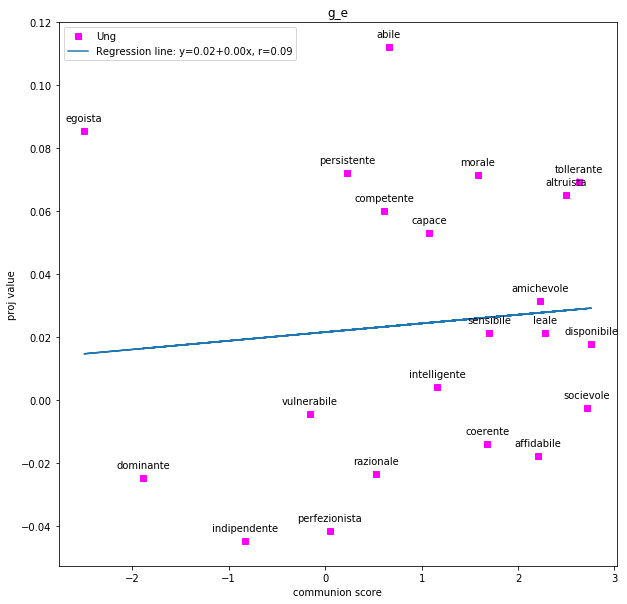

In [225]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col4, linewidth=0, marker='s', color='magenta', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/ung/com/g_g_e')

In [226]:
# agency-communion correlation
r_ag_com_ung_g_diff = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col1)[0]
r_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col2)[0]
r_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col3)[0]
r_ag_com_ung_g_e = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col4)[0]
p_ag_com_ung_g_diff = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col1)[1]
p_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col2)[1]
p_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col3)[1]
p_ag_com_ung_g_e = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col4)[1]

In [227]:
pearson_data = {'g_diff':[r_ag_com_ung_g_diff,p_ag_com_ung_g_diff],
                'g_pca_0':[r_ag_com_ung_g_pca_0,p_ag_com_ung_g_pca_0],
                'g_pca_01':[r_ag_com_ung_g_pca_01,p_ag_com_ung_g_pca_01],
                'g_e':[r_ag_com_ung_g_e,p_ag_com_ung_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion ungendered correlation")
pearson_table

Agency-Communion ungendered correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.059605 -0.016872 -0.026933 -0.112829
p  0.797450  0.942133  0.907742  0.626295

##### Gendered words

In [228]:
# words
ag_com_gen = db.read('ag_com_gen_ita.txt', 'ag-com-mf')

In [229]:
# compute projections
# male
proj_ag_com_gen_m_g_diff =  db.prof_proj(E_g, ag_com_gen, g_diff, 'ag-com-m')
proj_ag_com_gen_m_g_pca_0 =  db.prof_proj(E_g, ag_com_gen, g_pca_0, 'ag-com-m')
proj_ag_com_gen_m_g_pca_01 =  db.prof_proj(E_g, ag_com_gen, g_pca_01, 'ag-com-m')
proj_ag_com_gen_m_g_e =  db.prof_proj(E_g, ag_com_gen, g_e, 'ag-com-m')

# female
proj_ag_com_gen_f_g_diff =  db.prof_proj(E_g, ag_com_gen, g_diff, 'ag-com-f')
proj_ag_com_gen_f_g_pca_0 =  db.prof_proj(E_g, ag_com_gen, g_pca_0, 'ag-com-f')
proj_ag_com_gen_f_g_pca_01 =  db.prof_proj(E_g, ag_com_gen, g_pca_01, 'ag-com-f')
proj_ag_com_gen_f_g_e =  db.prof_proj(E_g, ag_com_gen, g_e, 'ag-com-f')

In [230]:
# print ag_com_gen_m results
ag_com_gen_m_col0 = [] # pandas columns
ag_com_gen_m_col1 = []
ag_com_gen_m_col2 = []
ag_com_gen_m_col3 = []
ag_com_gen_m_col4 = []
ag_com_gen_m_col5 = []
ag_com_gen_m_col6 = []

for i in range(len(proj_ag_com_gen_m_g_diff)):
    ag_com_gen_m_col0.append(proj_ag_com_gen_m_g_diff[i][0]) # word
    ag_com_gen_m_col1.append(proj_ag_com_gen_m_g_diff[i][1]) # projection on g_diff
    ag_com_gen_m_col2.append(proj_ag_com_gen_m_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_gen_m_col3.append(proj_ag_com_gen_m_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_gen_m_col4.append(np.real(proj_ag_com_gen_m_g_e[i][1])) # projection on g_e
    ag_com_gen_m_col5.append(proj_ag_com_gen_m_g_diff[i][2])
    ag_com_gen_m_col6.append(proj_ag_com_gen_m_g_diff[i][3])

ag_com_gen_m_data = {'Word':ag_com_gen_m_col0, 
               'Proj g_diff':ag_com_gen_m_col1,
               'Proj g_pca_0':ag_com_gen_m_col2, 
               'Proj g_pca_01':ag_com_gen_m_col3,
               'Proj g_e':ag_com_gen_m_col4,
               'Agency':ag_com_gen_m_col5,
               'Communion':ag_com_gen_m_col6}

ag_com_gen_m_table = pd.DataFrame(ag_com_gen_m_data)
ag_com_gen_m_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0          attivo     0.017886     -0.094562      -0.052168  0.032997    2.35   
1      affettuoso    -0.127809      0.016065       0.070109  0.013732   -0.85   
2       ambizioso     0.000125     -0.104148      -0.052351 -0.001439    2.79   
3          deciso    -0.119423      0.033008       0.027678  0.012721    2.88   
4        vanitoso    -0.155557      0.034814       0.046701  0.006040    1.29   
5   confusionario    -0.049710     -0.057565      -0.044746  0.009453   -1.89   
6    comunicativo    -0.035811     -0.092983      -0.106942 -0.001147    1.50   
7     competitivo     0.018908     -0.112277      -0.080623 -0.028378    2.71   
8     presuntuoso    -0.083870     -0.013392       0.018782  0.028906    1.53   
9    coscienzioso     0.005012     -0.114055      -0.072775 -0.045004    0.58   
10     rispettoso     0.048962     -0.142337      -0.065556  0.051218   -0.35   
11       creativo     0.007551     -0.084638      -0.067651 -0.020522    1.63   
12     distaccato    -0.011728     -0.021379      -0.002080  0.066966    1.61   
13    determinato    -0.024271     -0.055165      -0.078717  0.003694    2.73   
14         rigido     0.007108      0.017297      -0.020874  0.014374    0.38   
15        emotivo    -0.115930     -0.010283       0.027551  0.020937   -1.47   
16       energico     0.035756     -0.162564      -0.061633  0.021007    2.42   
17         giusto     0.043608     -0.070941      -0.014572  0.021177   -0.50   
18           duro     0.018746     -0.076976      -0.083828  0.055734    1.95   
19         onesto    -0.003152     -0.175895      -0.124121  0.004371   -0.71   
20       insicuro    -0.119928     -0.055831      -0.038183  0.060030   -2.35   
21          pigro    -0.096050     -0.063260      -0.066938  0.039637   -2.45   
22       ostinato    -0.043618     -0.134174      -0.113568  0.015068    2.43   
23         aperto    -0.087276      0.000376       0.018555  0.035076    0.45   
24     estroverso    -0.148047     -0.012511       0.007043  0.042588    1.11   
25        educato     0.004917     -0.013174       0.077647  0.034964    0.13   
26      riservato    -0.003459      0.010825       0.065749  0.058757    0.11   
27       autonomo     0.018244     -0.062765      -0.057968 -0.060740    2.76   
28         timido    -0.119504     -0.011026       0.043422  0.074636   -2.25   
29     combattivo     0.124812     -0.196116      -0.160374  0.010740    2.55   
30       risoluto     0.000838     -0.088410       0.004719  0.035646    2.48   
31       empatico    -0.102928     -0.001705       0.023518 -0.012724   -0.53   
32      fiducioso    -0.124749     -0.002972       0.054062  0.018134    0.23   
33    comprensivo     0.007183     -0.085540      -0.036546 -0.001486   -0.37   
34       vigoroso     0.017999     -0.127094      -0.098248  0.038363    1.55   
35          caldo    -0.090975     -0.005503      -0.038763  0.099045    0.18   

    Communion  
0        1.55  
1        1.58  
2       -0.97  
3        0.43  
4       -1.18  
5       -0.95  
6        2.00  
7       -1.39  
8       -1.50  
9        1.32  
10       1.55  
11       0.79  
12      -2.03  
13       0.53  
14      -0.36  
15       1.37  
16       0.79  
17       1.95  
18      -1.15  
19       2.34  
20       0.23  
21      -1.03  
22      -0.78  
23       2.05  
24       1.39  
25       1.92  
26      -1.00  
27      -0.47  
28      -0.58  
29       0.35  
30       0.03  
31       2.21  
32       2.15  
33       2.45  
34       0.10  
35       1.20

In [231]:
# ag_com_gen_m pearson correlation
# agency correlation
r_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col1)[0]
r_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col2)[0]
r_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col3)[0]
r_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col4)[0]
p_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col1)[1]
p_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col2)[1]
p_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col3)[1]
p_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col4)[1]

In [232]:
pearson_data = {'g_diff':[r_ag_com_gen_m_g_diff,p_ag_com_gen_m_g_diff],
                'g_pca_0':[r_ag_com_gen_m_g_pca_0,p_ag_com_gen_m_g_pca_0],
                'g_pca_01':[r_ag_com_gen_m_g_pca_01,p_ag_com_gen_m_g_pca_01],
                'g_e':[r_ag_com_gen_m_g_e,p_ag_com_gen_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency male correlation")
pearson_table

Agency male correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.412239 -0.271372 -0.313526 -0.323745
p  0.012477  0.109382  0.062599  0.054086

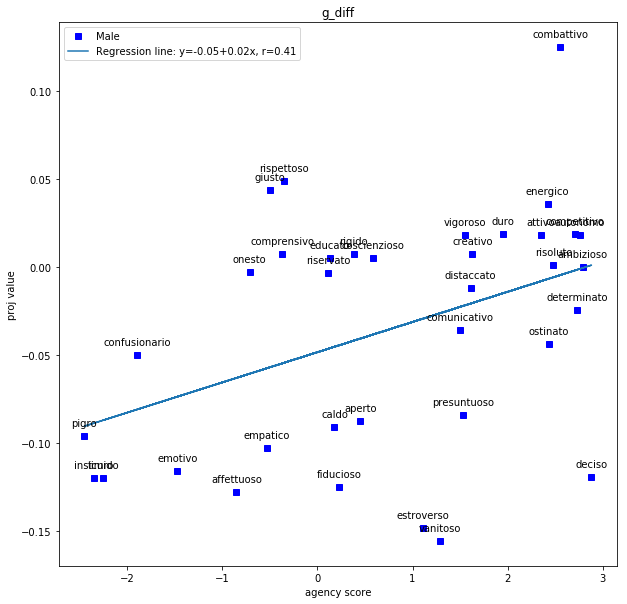

In [233]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/ag/g_g_diff')

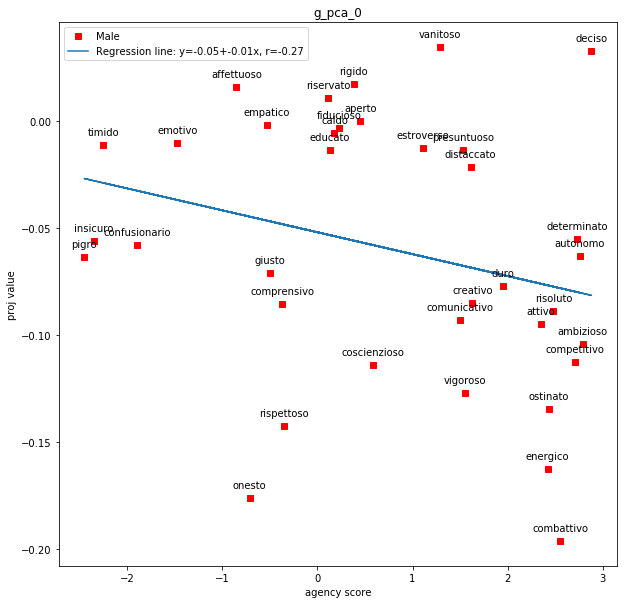

In [234]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col2, linewidth=0, marker='s', color='red', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/ag/g_g_pca_0')

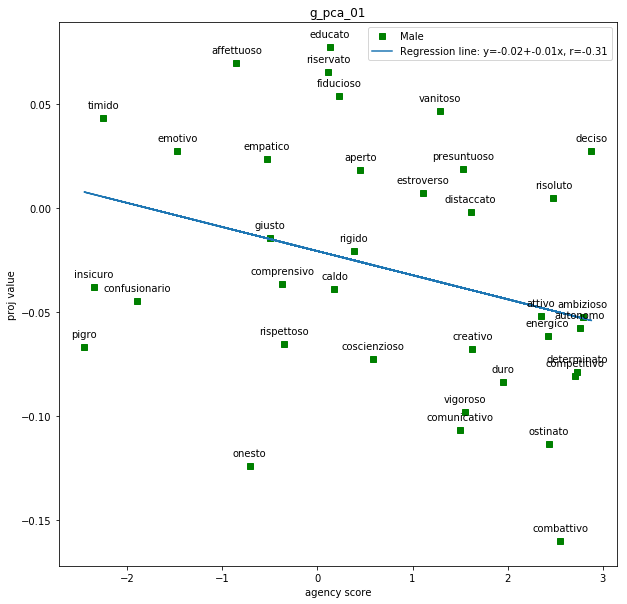

In [235]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col3, linewidth=0, marker='s', color='green', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/ag/g_g_pca_01')

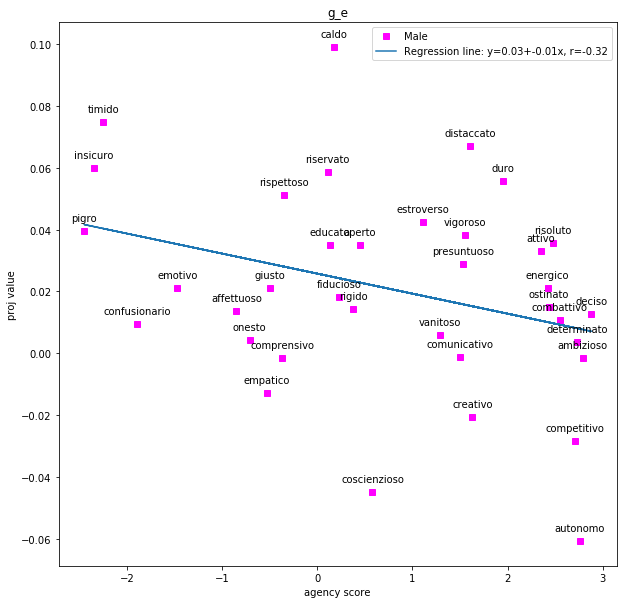

In [236]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col4, linewidth=0, marker='s', color='magenta', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/ag/g_g_e')

In [237]:
# communion correlation
r_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col1)[0]
r_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col2)[0]
r_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col3)[0]
r_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col4)[0]
p_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col1)[1]
p_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col2)[1]
p_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col3)[1]
p_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col4)[1]

In [238]:
pearson_data = {'g_diff':[r_ag_com_gen_m_g_diff,p_ag_com_gen_m_g_diff],
                'g_pca_0':[r_ag_com_gen_m_g_pca_0,p_ag_com_gen_m_g_pca_0],
                'g_pca_01':[r_ag_com_gen_m_g_pca_01,p_ag_com_gen_m_g_pca_01],
                'g_e':[r_ag_com_gen_m_g_e,p_ag_com_gen_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion male correlation")
pearson_table

Communion male correlation


g_diff   g_pca_0  g_pca_01       g_e
r -0.028280 -0.071658  0.063845 -0.118464
p  0.869946  0.677917  0.711435  0.491374

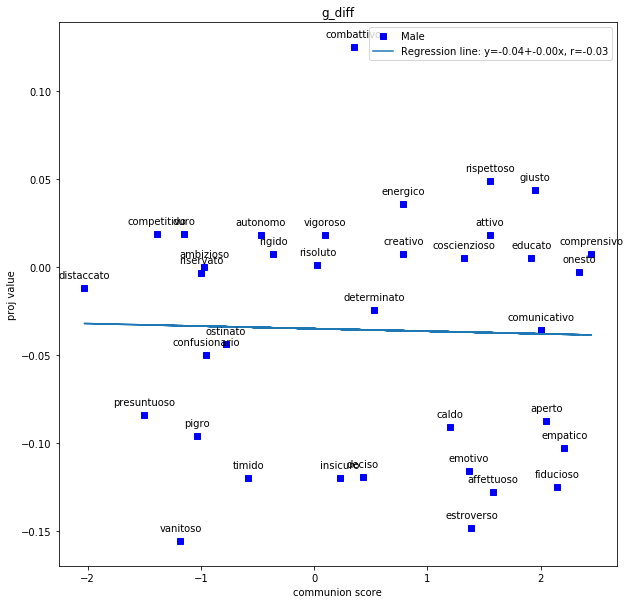

In [239]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/com/g_g_diff')

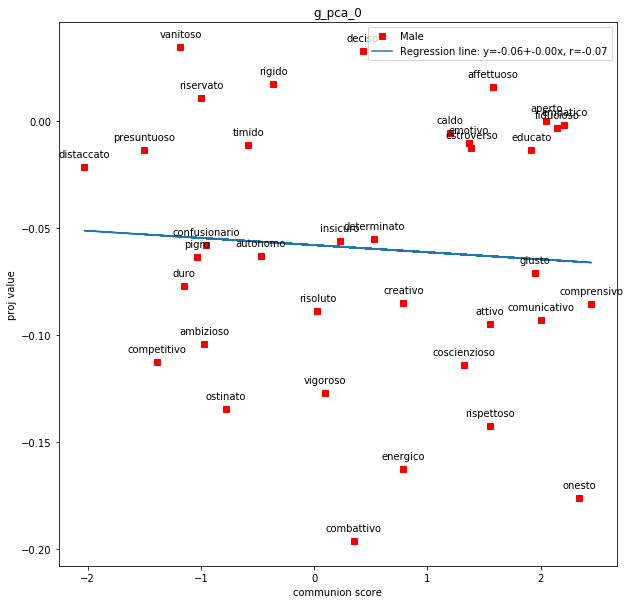

In [240]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col2, linewidth=0, marker='s', color='red', label='Male')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/com/g_g_pca_0')

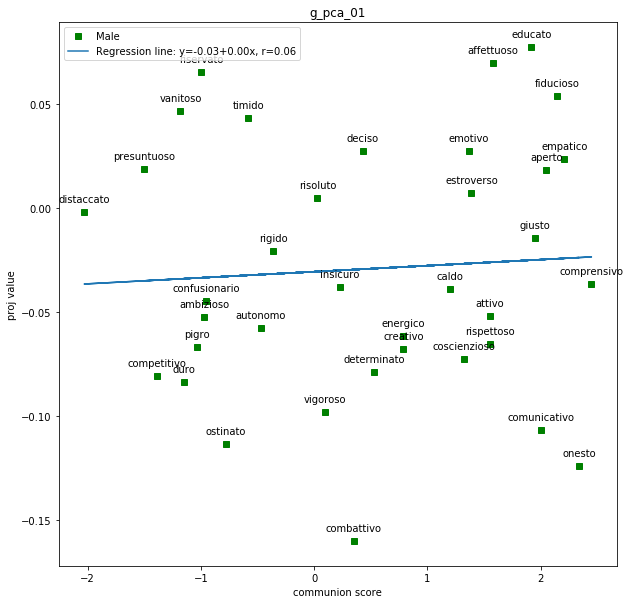

In [241]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col3, linewidth=0, marker='s', color='green', label='Male')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distaance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/com/g_g_pca_01')

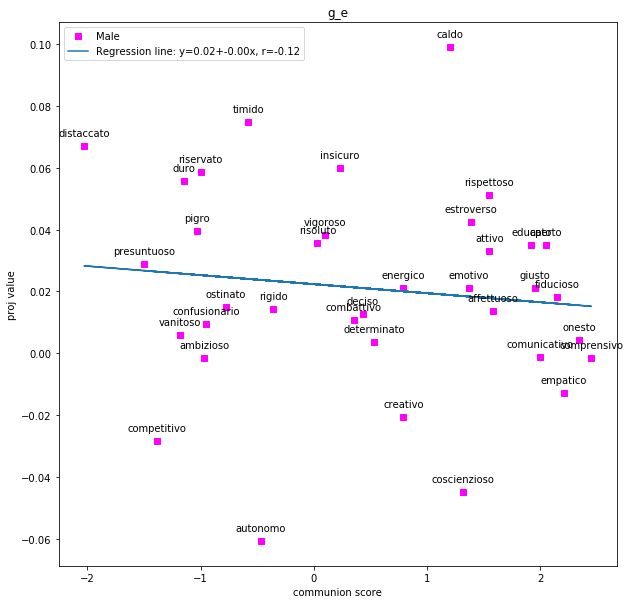

In [242]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col4, linewidth=0, marker='s', color='magenta', label='Male')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-m/com/g_g_e')

In [243]:
# agency-communion correlation
r_ag_com_gen_m_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col1)[0]
r_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col2)[0]
r_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col3)[0]
r_ag_com_gen_m_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col4)[0]
p_ag_com_gen_m_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col1)[1]
p_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col2)[1]
p_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col3)[1]
p_ag_com_gen_m_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col4)[1]

In [244]:
pearson_data = {'g_diff':[r_ag_com_gen_m_g_diff,p_ag_com_gen_m_g_diff],
                'g_pca_0':[r_ag_com_gen_m_g_pca_0,p_ag_com_gen_m_g_pca_0],
                'g_pca_01':[r_ag_com_gen_m_g_pca_01,p_ag_com_gen_m_g_pca_01],
                'g_e':[r_ag_com_gen_m_g_e,p_ag_com_gen_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion male correlation")
pearson_table

Agency-Communion male correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.305146 -0.149497 -0.256172 -0.159581
p  0.070343  0.384175  0.131534  0.352543

In [245]:
# print ag_com_gen_f results
ag_com_gen_f_col0 = [] # pandas columns
ag_com_gen_f_col1 = []
ag_com_gen_f_col2 = []
ag_com_gen_f_col3 = []
ag_com_gen_f_col4 = []
ag_com_gen_f_col5 = []
ag_com_gen_f_col6 = []

for i in range(len(proj_ag_com_gen_f_g_diff)):
    ag_com_gen_f_col0.append(proj_ag_com_gen_f_g_diff[i][0]) # word
    ag_com_gen_f_col1.append(proj_ag_com_gen_f_g_diff[i][1]) # projection on g_diff
    ag_com_gen_f_col2.append(proj_ag_com_gen_f_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_gen_f_col3.append(proj_ag_com_gen_f_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_gen_f_col4.append(np.real(proj_ag_com_gen_f_g_e[i][1])) # projection on g_e
    ag_com_gen_f_col5.append(proj_ag_com_gen_f_g_diff[i][2])
    ag_com_gen_f_col6.append(proj_ag_com_gen_f_g_diff[i][3])

ag_com_gen_f_data = {'Word':ag_com_gen_f_col0, 
               'Proj g_diff':ag_com_gen_f_col1,
               'Proj g_pca_0':ag_com_gen_f_col2, 
               'Proj g_pca_01':ag_com_gen_f_col3,
               'Proj g_e':ag_com_gen_f_col4,
               'Agency':ag_com_gen_f_col5,
               'Communion':ag_com_gen_f_col6}

ag_com_gen_f_table = pd.DataFrame(ag_com_gen_f_data)
ag_com_gen_f_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0          attiva    -0.091514      0.062616       0.050867 -0.009358    2.35   
1      affettuosa    -0.208138      0.200039       0.210236  0.064931   -0.85   
2       ambiziosa    -0.105657      0.130300       0.099913  0.045116    2.79   
3          decisa    -0.063146      0.062105       0.067235  0.106478    2.88   
4        vanitosa    -0.273848      0.211621       0.191887  0.033542    1.29   
5   confusionaria    -0.051784      0.068063       0.037947 -0.000608   -1.89   
6    comunicativa    -0.072940      0.020775      -0.013059  0.005213    1.50   
7     competitiva    -0.032508      0.039127       0.019015 -0.059104    2.71   
8     presuntuosa    -0.163381      0.087191       0.079845  0.031777    1.53   
9      rispettosa    -0.012484      0.021559       0.036902  0.062257   -0.35   
10       creativa    -0.018471     -0.000474      -0.011255  0.044723    1.63   
11     distaccata     0.013459      0.108404       0.062313  0.114839    1.61   
12    determinata    -0.065169      0.029969      -0.016128  0.057776    2.73   
13         rigida    -0.029452      0.121874       0.103474  0.045591    0.38   
14        emotiva    -0.158850      0.086388       0.060597  0.053157   -1.47   
15       energica    -0.087341      0.076108       0.057284  0.004678    2.42   
16         giusta    -0.016713      0.054207       0.015698  0.021177   -0.50   
17           dura    -0.063994      0.024940      -0.012615  0.055734    1.95   
18         onesta    -0.091995      0.082374       0.060531 -0.021629   -0.71   
19       insicura    -0.227629      0.145953       0.124385  0.033774   -2.35   
20          pigra    -0.135407      0.086843       0.057485 -0.017081   -2.45   
21       ostinata    -0.064993      0.046606       0.042406  0.070987    2.43   
22         aperta    -0.082394      0.040156       0.045039  0.075416    0.45   
23     estroversa    -0.188360      0.122093       0.116887  0.088823    1.11   
24        educata    -0.142045      0.173629       0.180060  0.031117    0.13   
25      riservata     0.010133     -0.000657       0.052471  0.077614    0.11   
26    autocritica    -0.037783     -0.020755      -0.044701 -0.001845    0.25   
27       autonoma     0.004829      0.050194       0.041416 -0.000641    2.76   
28         timida    -0.261992      0.246790       0.207899  0.074082   -2.25   
29     combattiva    -0.103453      0.106923       0.063714  0.007692    2.55   
30       risoluta    -0.116068      0.093729       0.088972  0.023118    2.48   
31       empatica    -0.116064      0.044420       0.005972  0.036345   -0.53   
32      fiduciosa    -0.166479      0.108609       0.093127  0.026204    0.23   
33    comprensiva    -0.069527      0.105768       0.135227  0.022083   -0.37   
34       vigorosa     0.006097      0.010154      -0.004501  0.016299    1.55   
35          calda    -0.144505      0.068716       0.007468  0.099045    0.18   

    Communion  
0        1.55  
1        1.58  
2       -0.97  
3        0.43  
4       -1.18  
5       -0.95  
6        2.00  
7       -1.39  
8       -1.50  
9        1.55  
10       0.79  
11      -2.03  
12       0.53  
13      -0.36  
14       1.37  
15       0.79  
16       1.95  
17      -1.15  
18       2.34  
19       0.23  
20      -1.03  
21      -0.78  
22       2.05  
23       1.39  
24       1.92  
25      -1.00  
26       0.53  
27      -0.47  
28      -0.58  
29       0.35  
30       0.03  
31       2.21  
32       2.15  
33       2.45  
34       0.10  
35       1.20

In [246]:
# ag_com_gen_f pearson correlation
# agency correlation
r_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col1)[0]
r_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col2)[0]
r_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col3)[0]
r_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col4)[0]
p_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col1)[1]
p_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col2)[1]
p_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col3)[1]
p_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col4)[1]

In [247]:
pearson_data = {'g_diff':[r_ag_com_gen_f_g_diff,p_ag_com_gen_f_g_diff],
                'g_pca_0':[r_ag_com_gen_f_g_pca_0,p_ag_com_gen_f_g_pca_0],
                'g_pca_01':[r_ag_com_gen_f_g_pca_01,p_ag_com_gen_f_g_pca_01],
                'g_e':[r_ag_com_gen_f_g_e,p_ag_com_gen_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency female correlation")
pearson_table

Agency female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.366534 -0.307723 -0.295890  0.000188
p  0.027896  0.067886  0.079746  0.999133

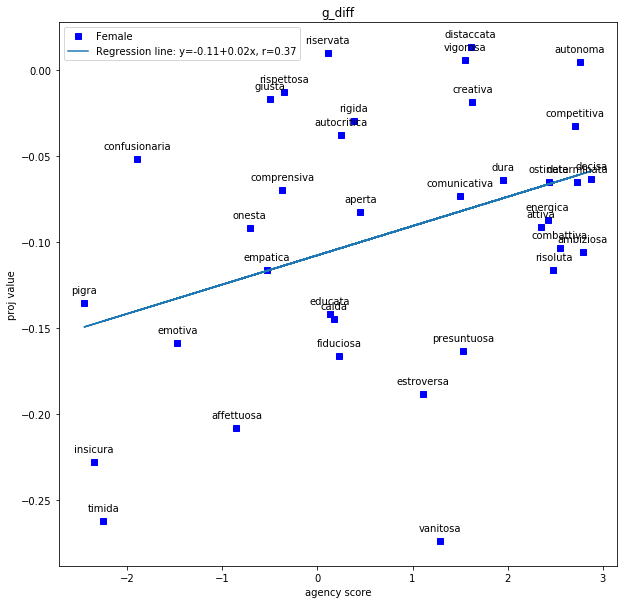

In [248]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col1, linewidth=0, marker='s', color='blue', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/ag/g_g_diff')

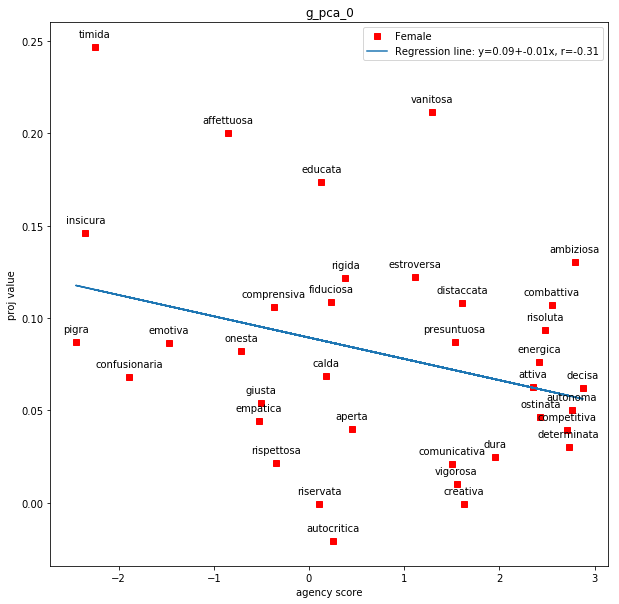

In [249]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col2, linewidth=0, marker='s', color='red', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/ag/g_g_pca_0')

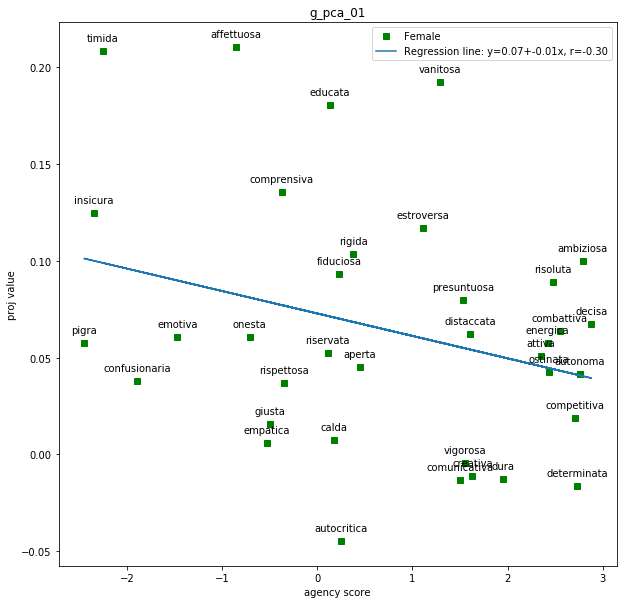

In [250]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col3, linewidth=0, marker='s', color='green', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/ag/g_g_pca_01')

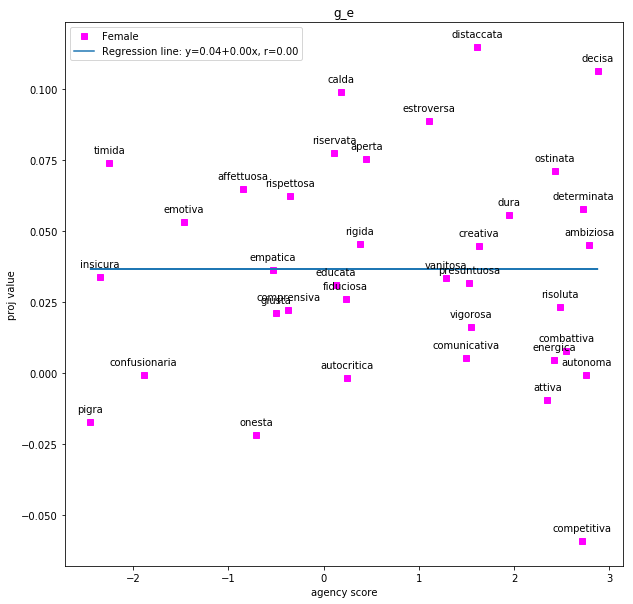

In [251]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col4, linewidth=0, marker='s', color='magenta', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/ag/g_g_e')

In [252]:
# communion correlation
r_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col1)[0]
r_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col2)[0]
r_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col3)[0]
r_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col4)[0]
p_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col1)[1]
p_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col2)[1]
p_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col3)[1]
p_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col4)[1]

In [253]:
pearson_data = {'g_diff':[r_ag_com_gen_f_g_diff,p_ag_com_gen_f_g_diff],
                'g_pca_0':[r_ag_com_gen_f_g_pca_0,p_ag_com_gen_f_g_pca_0],
                'g_pca_01':[r_ag_com_gen_f_g_pca_01,p_ag_com_gen_f_g_pca_01],
                'g_e':[r_ag_com_gen_f_g_e,p_ag_com_gen_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion female correlation")
pearson_table

Communion female correlation


g_diff   g_pca_0  g_pca_01       g_e
r -0.096060 -0.065842 -0.012532 -0.043315
p  0.577316  0.702813  0.942169  0.801942

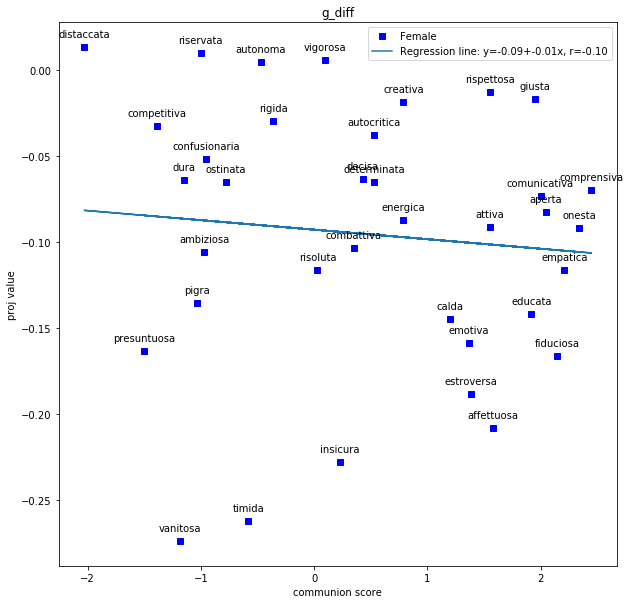

In [254]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col1, linewidth=0, marker='s', color='blue', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/com/g_g_diff')

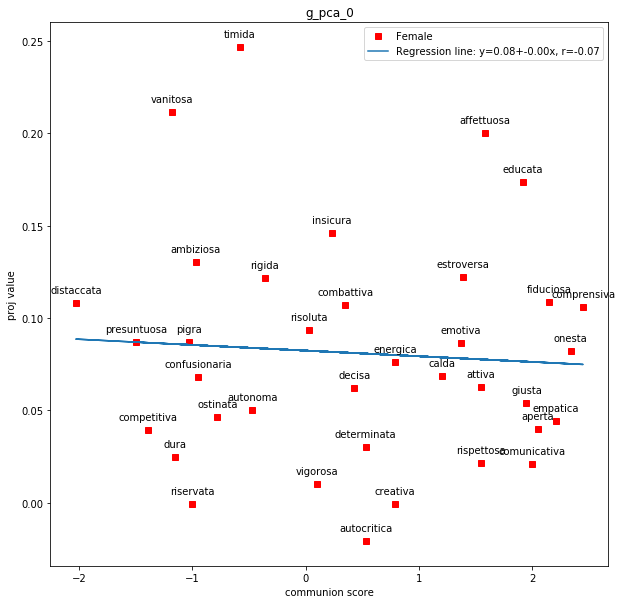

In [255]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col2, linewidth=0, marker='s', color='red', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/com/g_g_pca_0')

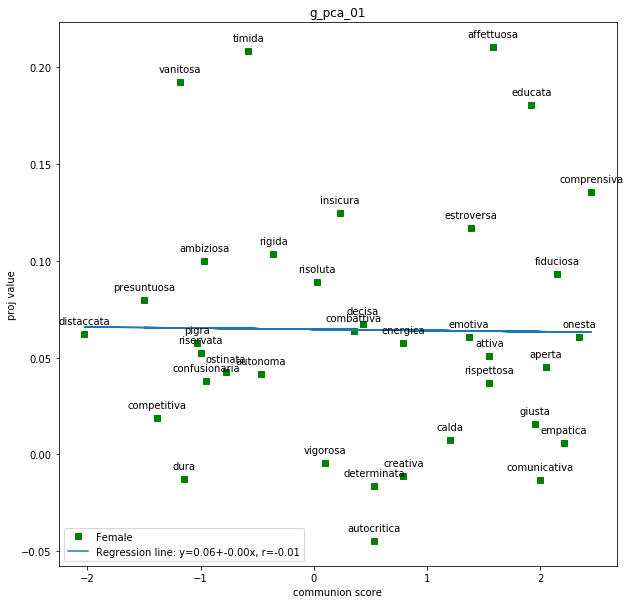

In [256]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col3, linewidth=0, marker='s', color='green', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/com/g_g_pca_01')

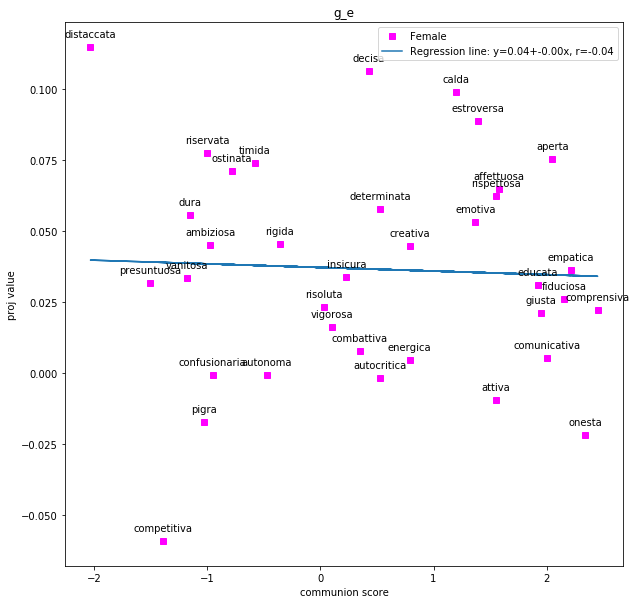

In [257]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col4, linewidth=0, marker='s', color='magenta', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/gen-f/com/g_g_e')

In [258]:
# agency-communion correlation
r_ag_com_gen_f_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col1)[0]
r_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col2)[0]
r_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col3)[0]
r_ag_com_gen_f_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col4)[0]
p_ag_com_gen_f_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col1)[1]
p_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col2)[1]
p_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col3)[1]
p_ag_com_gen_f_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col4)[1]

In [259]:
pearson_data = {'g_diff':[r_ag_com_gen_f_g_diff,p_ag_com_gen_f_g_diff],
                'g_pca_0':[r_ag_com_gen_f_g_pca_0,p_ag_com_gen_f_g_pca_0],
                'g_pca_01':[r_ag_com_gen_f_g_pca_01,p_ag_com_gen_f_g_pca_01],
                'g_e':[r_ag_com_gen_f_g_e,p_ag_com_gen_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion female correlation")
pearson_table

Agency-Communion female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.312234 -0.179110 -0.201002  0.024681
p  0.063747  0.295924  0.239797  0.886382

In [260]:
# both male and female agency plot

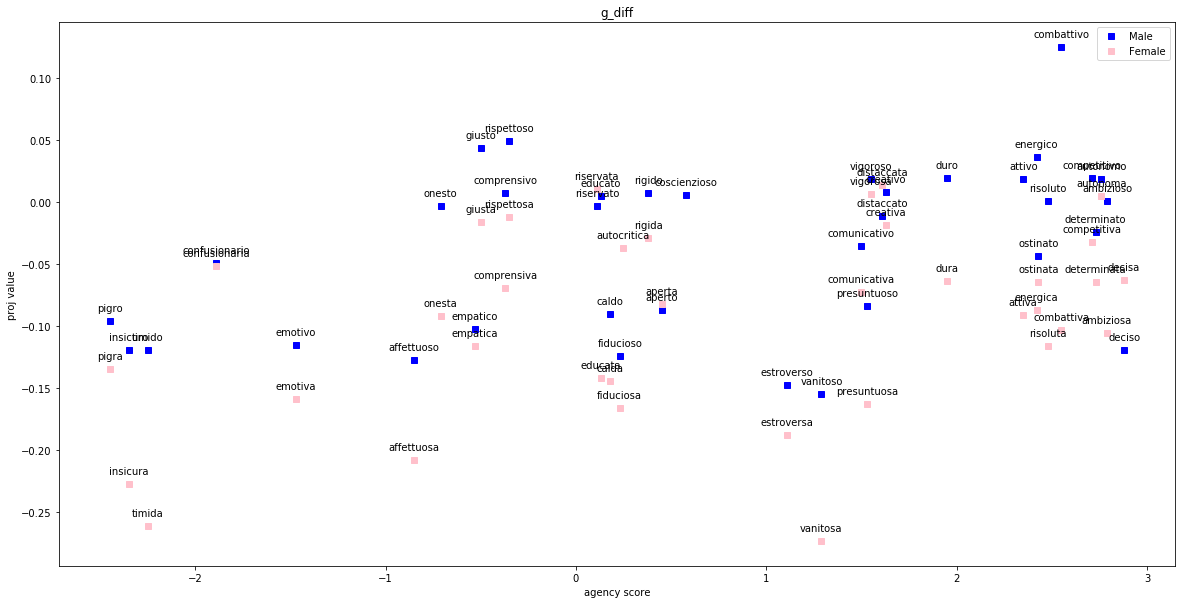

In [261]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col1, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/ag/g_g_diff')

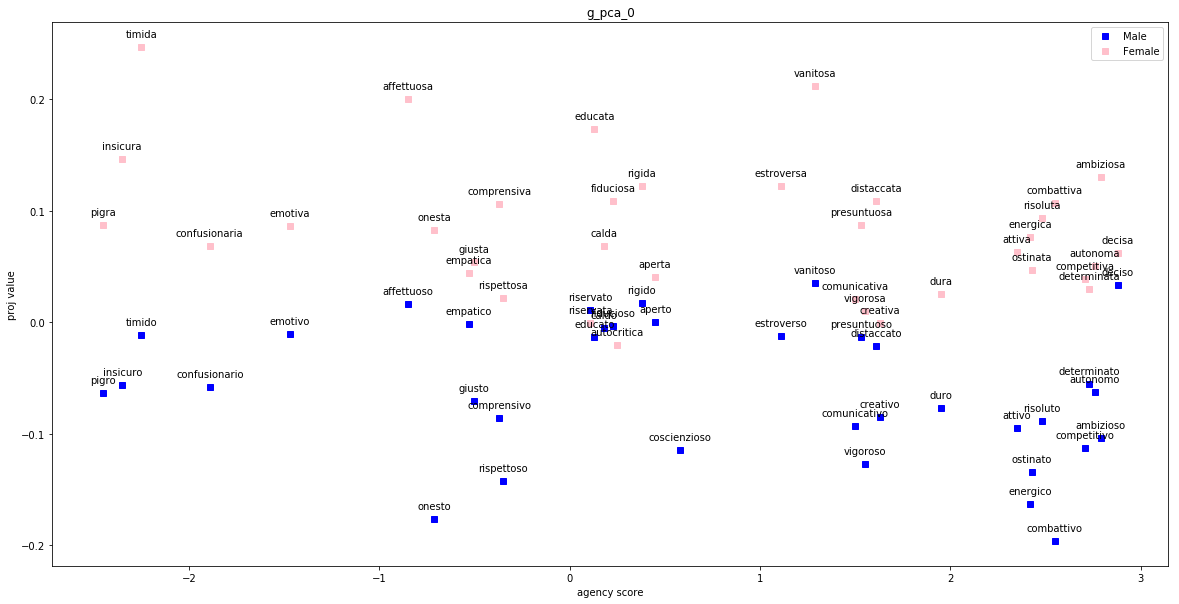

In [262]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col2, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col2, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/ag/g_g_pca_0')

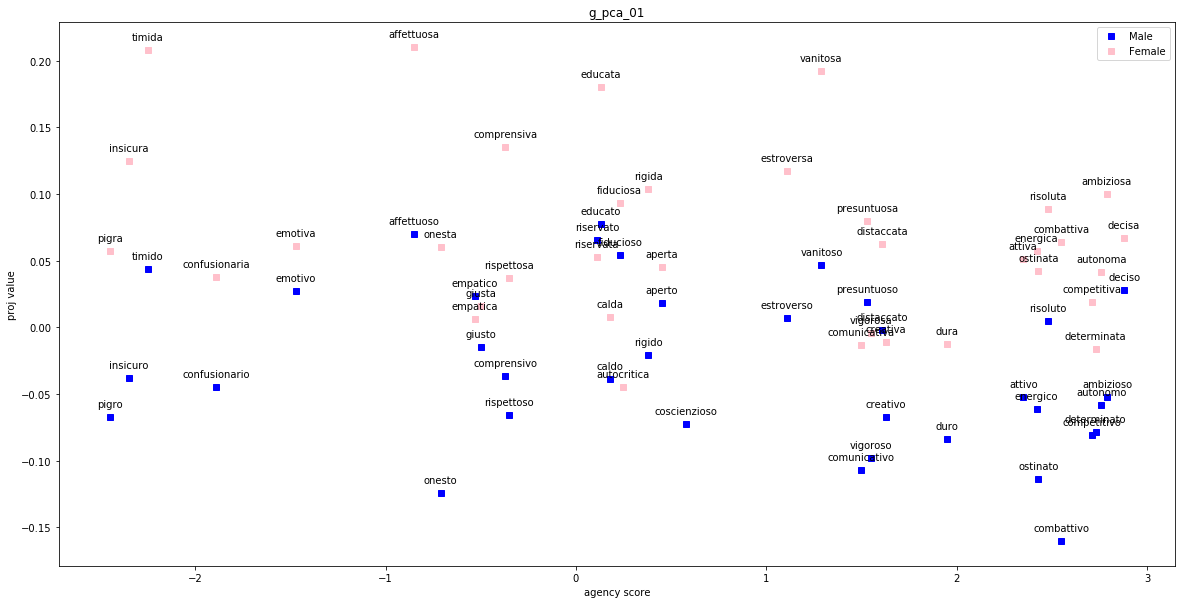

In [263]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col3, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col3, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/ag/g_g_pca_01')

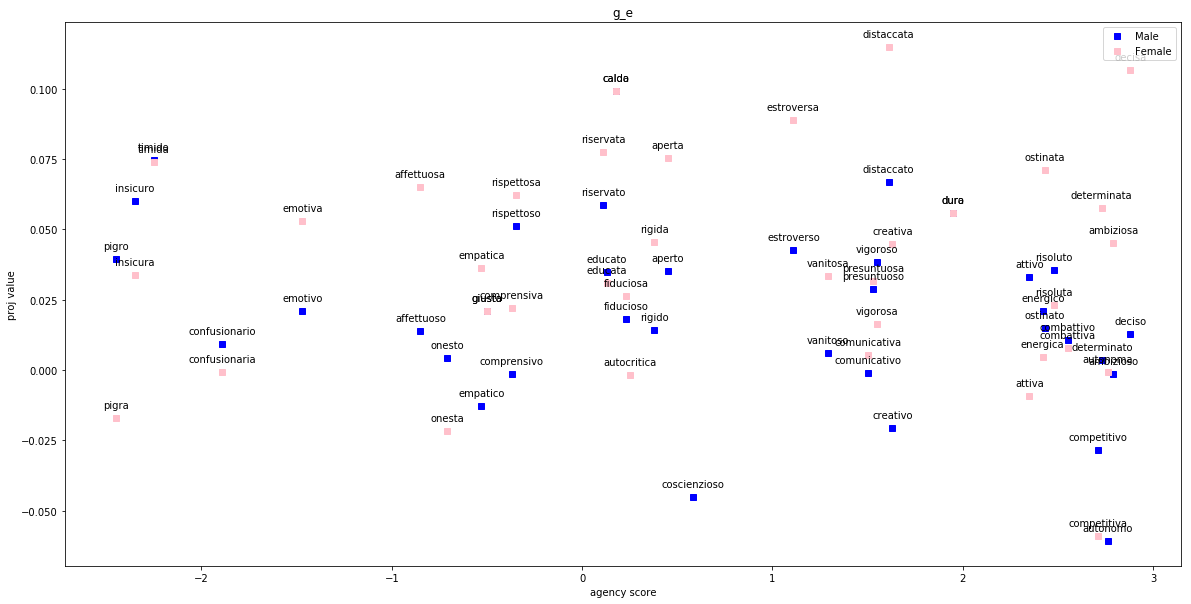

In [264]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col4, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col4, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/ag/g_g_e')

In [265]:
# both male and female communion plot

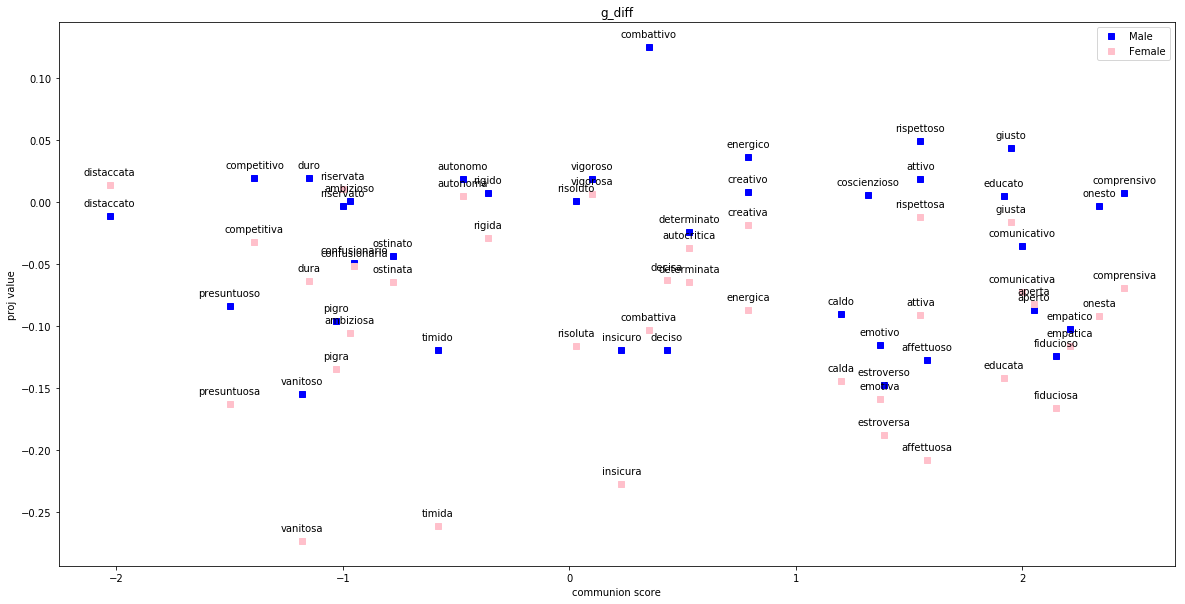

In [266]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col1, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/com/g_g_diff')

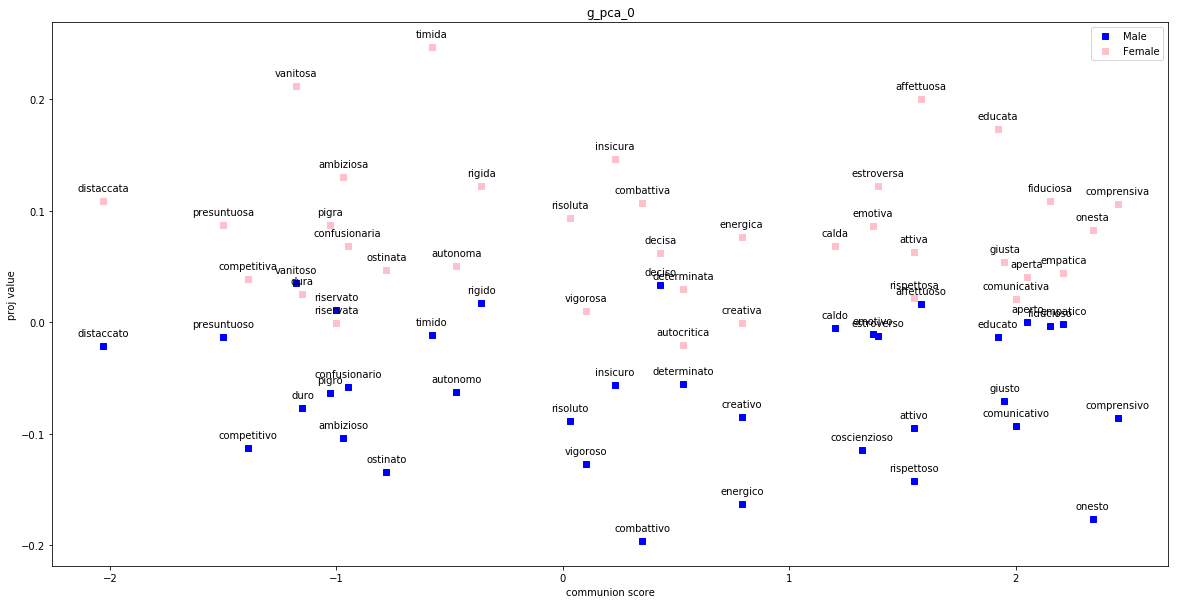

In [267]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col2, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col2, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/com/g_g_pca_0')

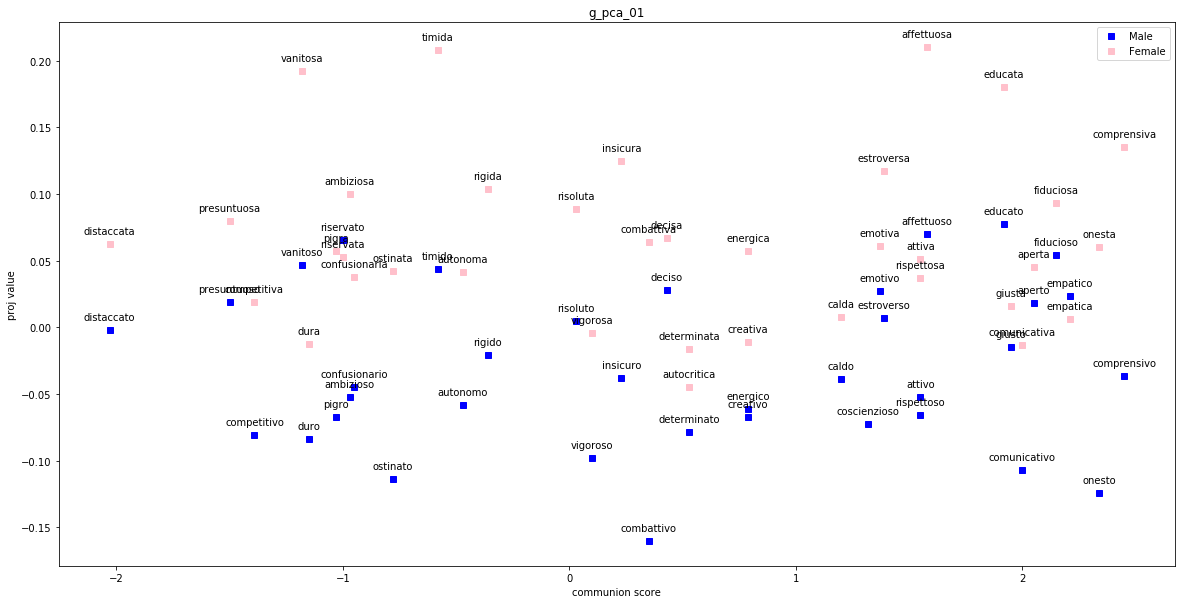

In [268]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col3, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col3, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/com/g_g_pca_01')

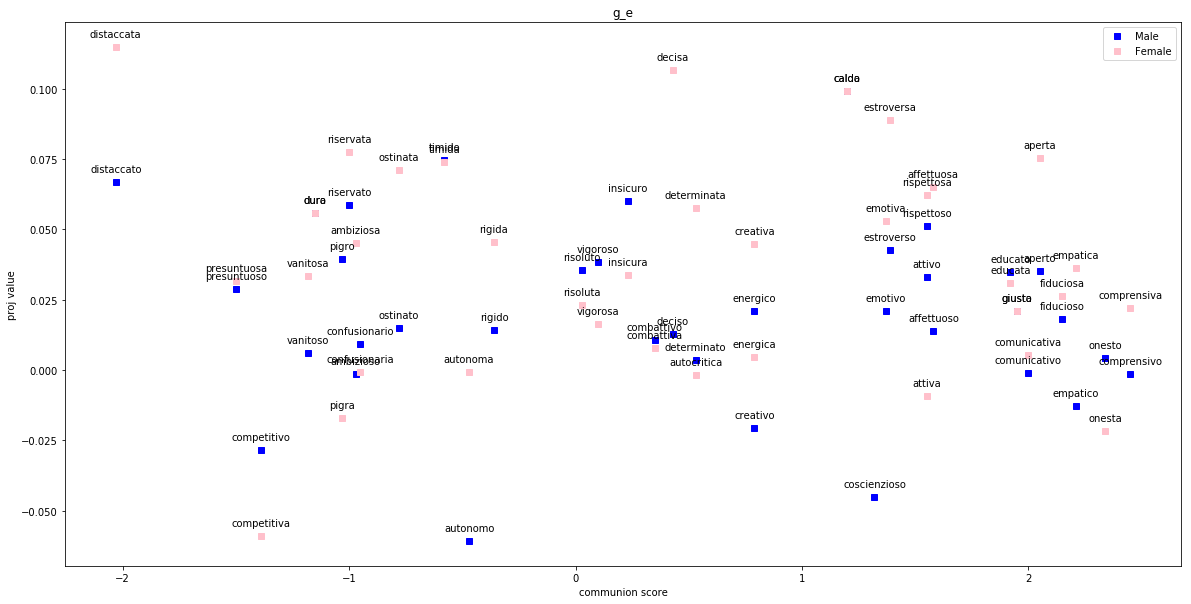

In [269]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col4, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col4, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
fig.savefig('corr-plot/gen-mf/com/g_g_e')

##### Ungendered + mean gendered words

In [270]:
# print ag_com_mean results
ag_com_mean_col0 = [] # pandas columns
ag_com_mean_col1 = []
ag_com_mean_col2 = []
ag_com_mean_col3 = []
ag_com_mean_col4 = []
ag_com_mean_col5 = []
ag_com_mean_col6 = []

for i in range(len(proj_ag_com_ung_g_diff)):
    ag_com_mean_col0.append(proj_ag_com_ung_g_diff[i][0]) # word
    ag_com_mean_col1.append(proj_ag_com_ung_g_diff[i][1]) # projection on g_diff
    ag_com_mean_col2.append(proj_ag_com_ung_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_mean_col3.append(proj_ag_com_ung_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_mean_col4.append(np.real(proj_ag_com_ung_g_e[i][1])) # projection on g_e
    ag_com_mean_col5.append(proj_ag_com_ung_g_diff[i][2])
    ag_com_mean_col6.append(proj_ag_com_ung_g_diff[i][3])
    
for i in range(len(proj_ag_com_gen_m_g_diff)):
    ag_com_mean_col0.append(proj_ag_com_gen_m_g_diff[i][0]) # word
    ag_com_mean_col1.append((proj_ag_com_gen_m_g_diff[i][1]+proj_ag_com_gen_f_g_diff[i][1])/2) # projection on g_diff
    ag_com_mean_col2.append((proj_ag_com_gen_m_g_pca_0[i][1]+proj_ag_com_gen_f_g_pca_0[i][1])/2) # projection on g_pca_0
    ag_com_mean_col3.append((proj_ag_com_gen_m_g_pca_01[i][1]+proj_ag_com_gen_f_g_pca_01[i][1])/2) # projection on g_pca_01
    ag_com_mean_col4.append((np.real(proj_ag_com_gen_m_g_e[i][1])+np.real(proj_ag_com_gen_f_g_e[i][1]))/2) # projection on g_e
    ag_com_mean_col5.append(proj_ag_com_gen_m_g_diff[i][2])
    ag_com_mean_col6.append(proj_ag_com_gen_m_g_diff[i][3])   

ag_com_mean_data = {'Word':ag_com_mean_col0, 
               'Proj g_diff':ag_com_mean_col1,
               'Proj g_pca_0':ag_com_mean_col2, 
               'Proj g_pca_01':ag_com_mean_col3,
               'Proj g_e':ag_com_mean_col4,
               'Agency':ag_com_mean_col5,
               'Communion':ag_com_mean_col6}

ag_com_mean_table = pd.DataFrame(ag_com_mean_data)
ag_com_mean_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0           abile     0.059056     -0.113135      -0.023355  0.112070    2.32   
1       altruista    -0.115441     -0.013627       0.008819  0.065061   -1.18   
2          capace     0.026271     -0.020479      -0.026877  0.053098    2.45   
3      competente     0.059333     -0.066472      -0.013275  0.059932    2.21   
4        coerente     0.021684     -0.035207      -0.037364 -0.014060    0.74   
5       dominante    -0.032145     -0.024013       0.036617 -0.024821    2.76   
6      amichevole    -0.011846      0.081167       0.099525  0.031213    0.15   
7     disponibile    -0.116799      0.034990       0.024886  0.017821   -0.42   
8         egoista    -0.161264     -0.018887      -0.032528  0.085321    1.53   
9    indipendente    -0.001864      0.028230       0.034211 -0.044919    2.65   
10   intelligente    -0.046631     -0.002014       0.018938  0.003886    2.21   
11          leale     0.001660     -0.058370       0.015543  0.021318   -0.88   
12         morale     0.081215     -0.060236      -0.029617  0.071533   -0.78   
13  perfezionista    -0.088548      0.000455       0.027781 -0.041557    2.15   
14    persistente    -0.074985      0.047052       0.031250  0.072091    1.78   
15      razionale     0.034658     -0.078759      -0.104205 -0.023670    1.73   
16     affidabile     0.093735     -0.040602      -0.006190 -0.017933    0.45   
17      sensibile    -0.106242     -0.019653      -0.027386  0.021225   -1.03   
18      socievole    -0.142771      0.010607      -0.006720 -0.002590    0.66   
19     tollerante     0.000960     -0.094010      -0.039732  0.069157   -0.34   
20    vulnerabile    -0.113564      0.015015       0.034551 -0.004593   -2.29   
21         attivo    -0.036814     -0.015973      -0.000651  0.011820    2.35   
22     affettuoso    -0.167974      0.108052       0.140172  0.039331   -0.85   
23      ambizioso    -0.052766      0.013076       0.023781  0.021838    2.79   
24         deciso    -0.091284      0.047557       0.047456  0.059599    2.88   
25       vanitoso    -0.214703      0.123217       0.119294  0.019791    1.29   
26  confusionario    -0.050747      0.005249      -0.003399  0.004422   -1.89   
27   comunicativo    -0.054376     -0.036104      -0.060000  0.002033    1.50   
28    competitivo    -0.006800     -0.036575      -0.030804 -0.043741    2.71   
29    presuntuoso    -0.123626      0.036900       0.049313  0.030341    1.53   
30   coscienzioso    -0.003736     -0.046248      -0.017936  0.008626    0.58   
31     rispettoso     0.015246     -0.071405      -0.038405  0.047970   -0.35   
32       creativo     0.010505      0.011883      -0.002669  0.047158    1.63   
33     distaccato    -0.038449      0.004295      -0.009104  0.062371    1.61   
34    determinato    -0.026861      0.033355       0.012378  0.024642    2.73   
35         rigido    -0.075871      0.051843       0.019862  0.033766    0.38   
36        emotivo    -0.101636      0.032912       0.042417  0.012807   -1.47   
37       energico     0.009521     -0.054178      -0.022968  0.021092    2.42   
38         giusto    -0.010193     -0.023001      -0.013593  0.038455   -0.50   
39           duro    -0.036625      0.002699      -0.011648  0.017053    1.95   
40         onesto    -0.115390     -0.014971       0.000132  0.019072   -0.71   
41       insicuro    -0.127667      0.015506       0.009651  0.021474   -2.35   
42          pigro    -0.080521     -0.008327      -0.012266  0.055312   -2.45   
43       ostinato    -0.063006     -0.047009      -0.034265  0.045242    2.43   
44         aperto    -0.137818      0.061235       0.067721  0.061949    0.45   
45     estroverso    -0.145046      0.080559       0.093551  0.036852    1.11   
46        educato     0.007525     -0.006915       0.065059  0.056289    0.13   
47      riservato    -0.020621     -0.004965       0.010524  0.028456    0.11   
48       autonomo     0.011537     -0.006286

In [271]:
# ag_com_mean pearson correlation
# agency correlation
r_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col1)[0]
r_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col2)[0]
r_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col3)[0]
r_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col4)[0]
p_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col1)[1]
p_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col2)[1]
p_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col3)[1]
p_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col4)[1]

In [272]:
pearson_data = {'g_diff':[r_ag_com_mean_g_diff,p_ag_com_mean_g_diff],
                'g_pca_0':[r_ag_com_mean_g_pca_0,p_ag_com_mean_g_pca_0],
                'g_pca_01':[r_ag_com_mean_g_pca_01,p_ag_com_mean_g_pca_01],
                'g_e':[r_ag_com_mean_g_e,p_ag_com_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency mean correlation")
pearson_table

Agency mean correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.332355 -0.186755 -0.206617 -0.184231
p  0.011541  0.164224  0.123059  0.170104

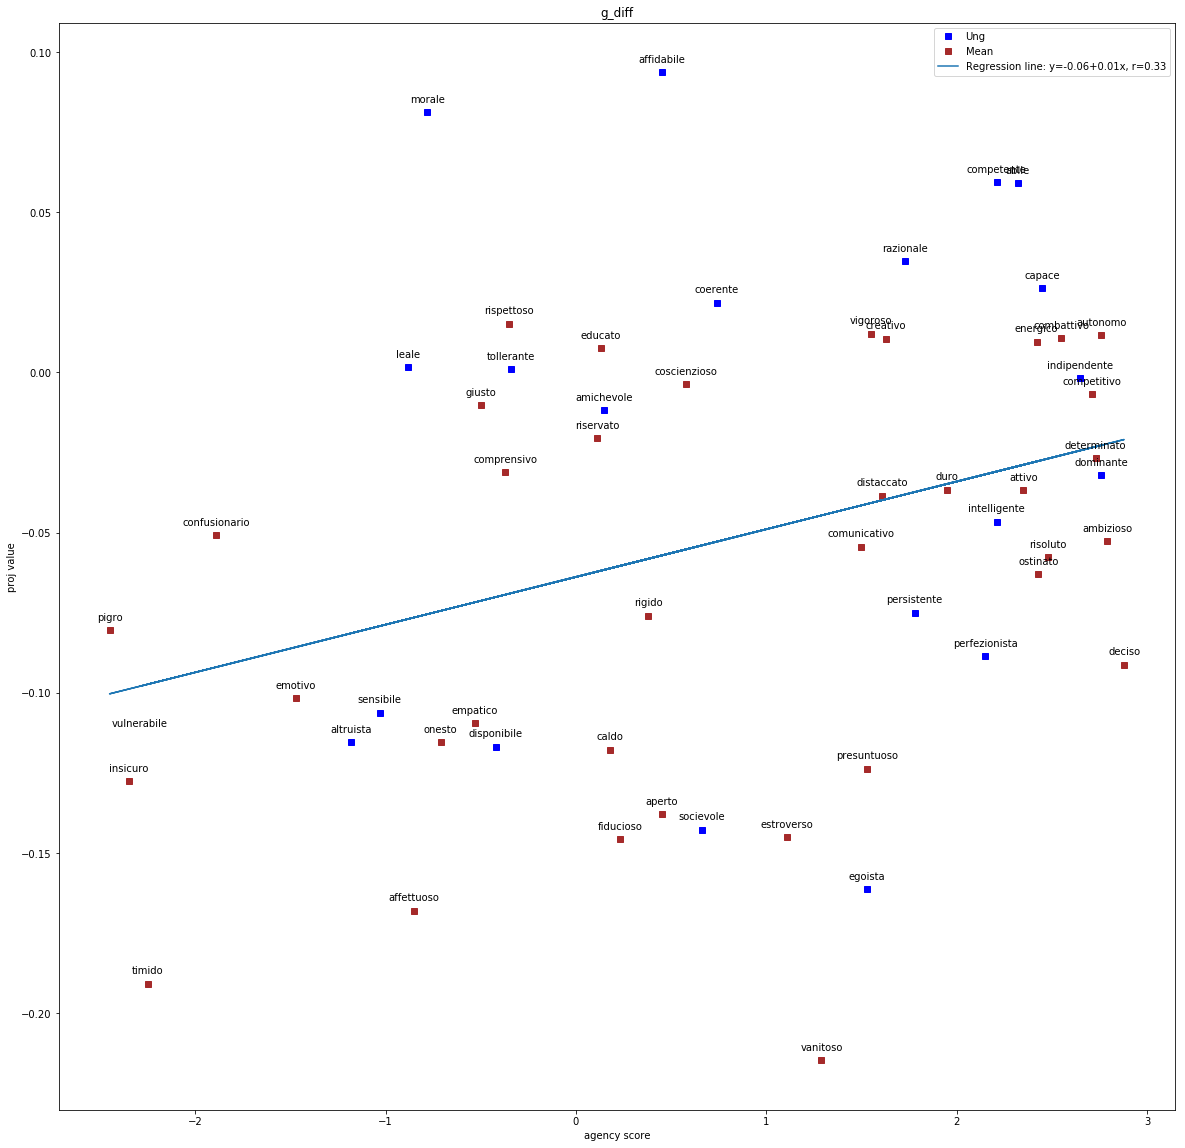

In [273]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col1[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col1[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/ag/g_g_diff')

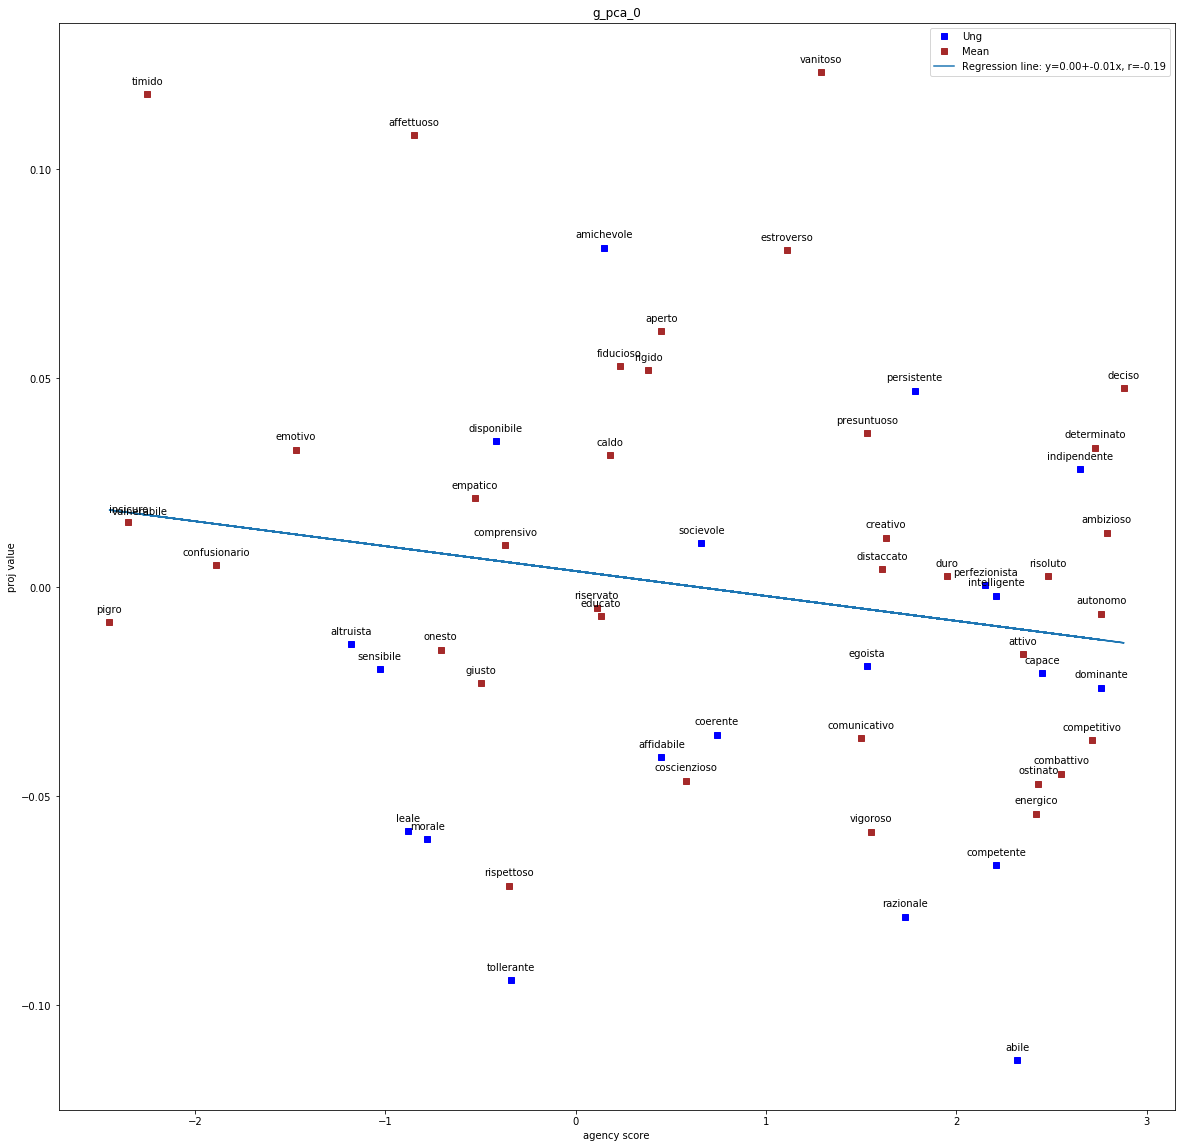

In [274]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col2[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col2[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/ag/g_g_pca_0')

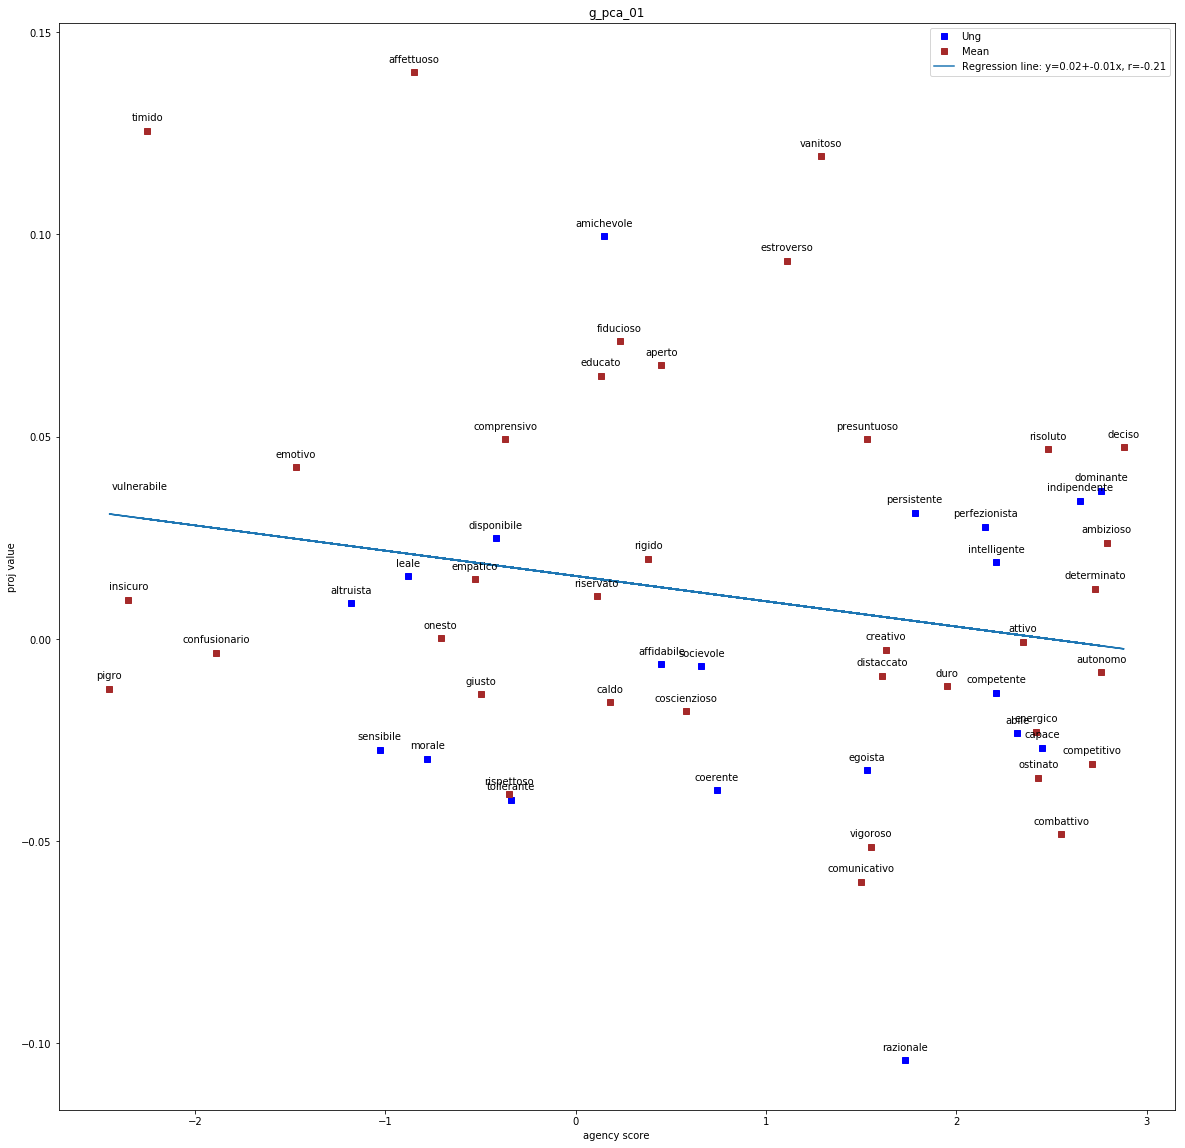

In [275]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col3[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col3[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/ag/g_g_pca_01')

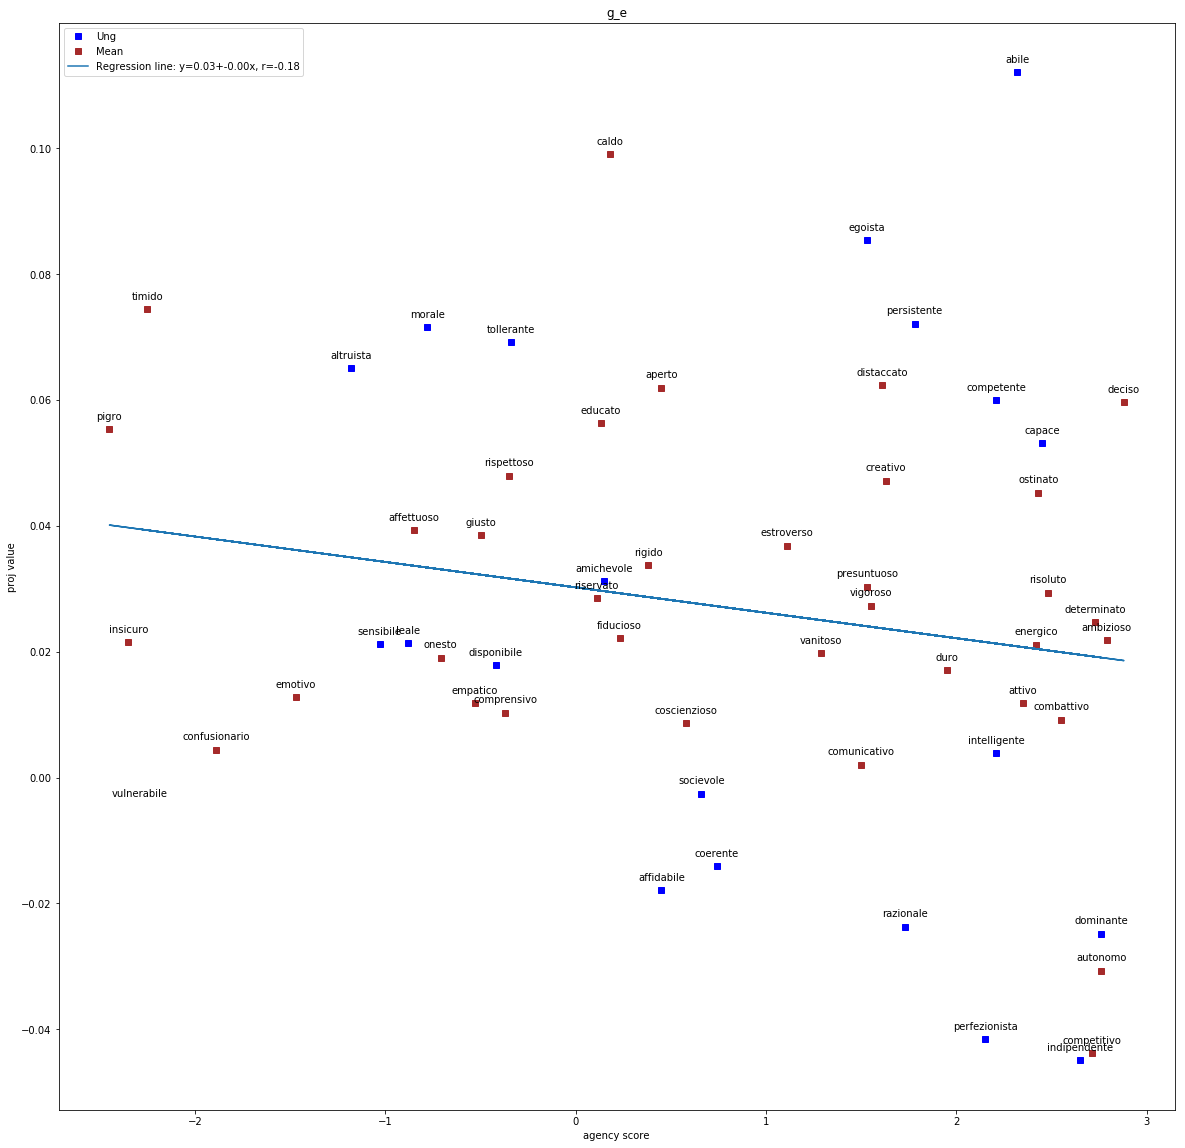

In [276]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col4[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col4[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/ag/g_g_e')

In [277]:
# communion correlation
r_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col1)[0]
r_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col2)[0]
r_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col3)[0]
r_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col4)[0]
p_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col1)[1]
p_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col2)[1]
p_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col3)[1]
p_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col4)[1]

In [278]:
pearson_data = {'g_diff':[r_ag_com_mean_g_diff,p_ag_com_mean_g_diff],
                'g_pca_0':[r_ag_com_mean_g_pca_0,p_ag_com_mean_g_pca_0],
                'g_pca_01':[r_ag_com_mean_g_pca_01,p_ag_com_mean_g_pca_01],
                'g_e':[r_ag_com_mean_g_e,p_ag_com_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion mean correlation")
pearson_table

Communion mean correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.092145 -0.095519  0.016718  0.065750
p  0.495417  0.479694  0.901764  0.627016

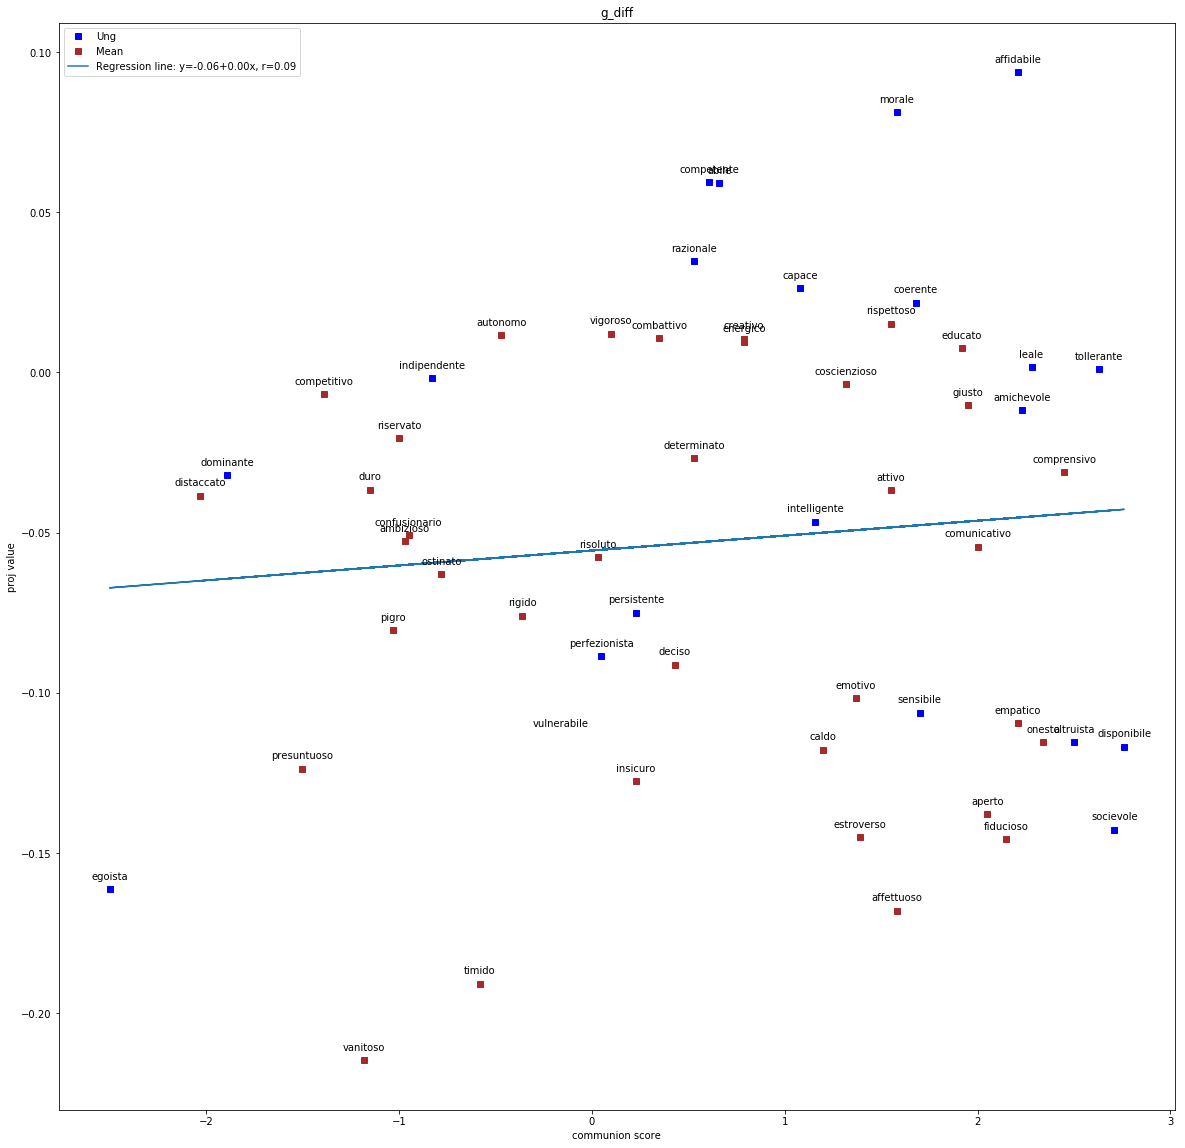

In [279]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col1[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col1[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/com/g_g_diff')

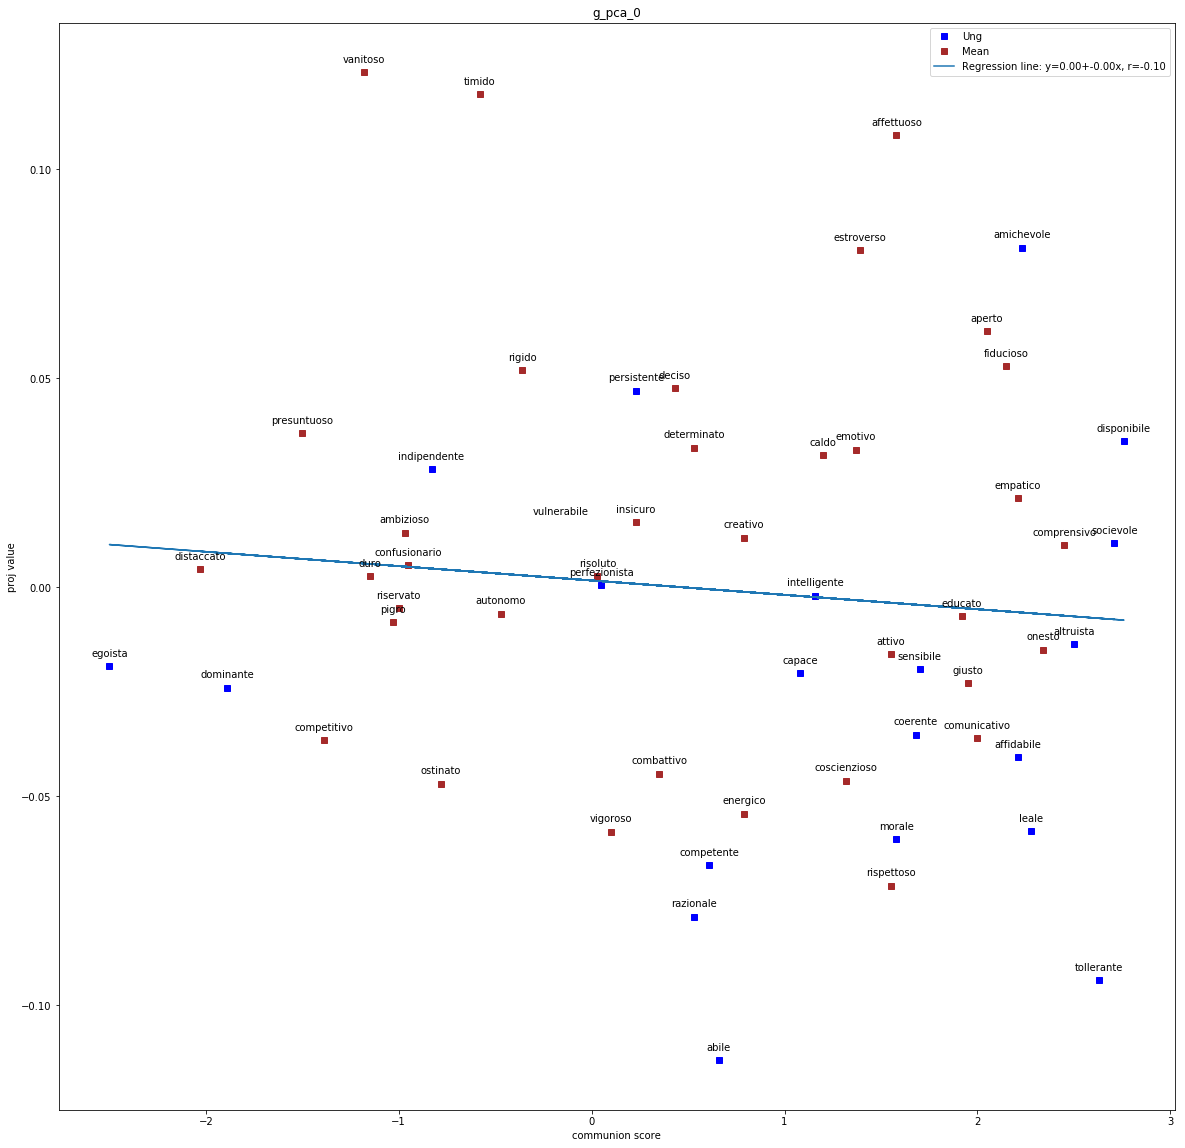

In [280]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col2[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col2[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/com/g_g_pca_0')

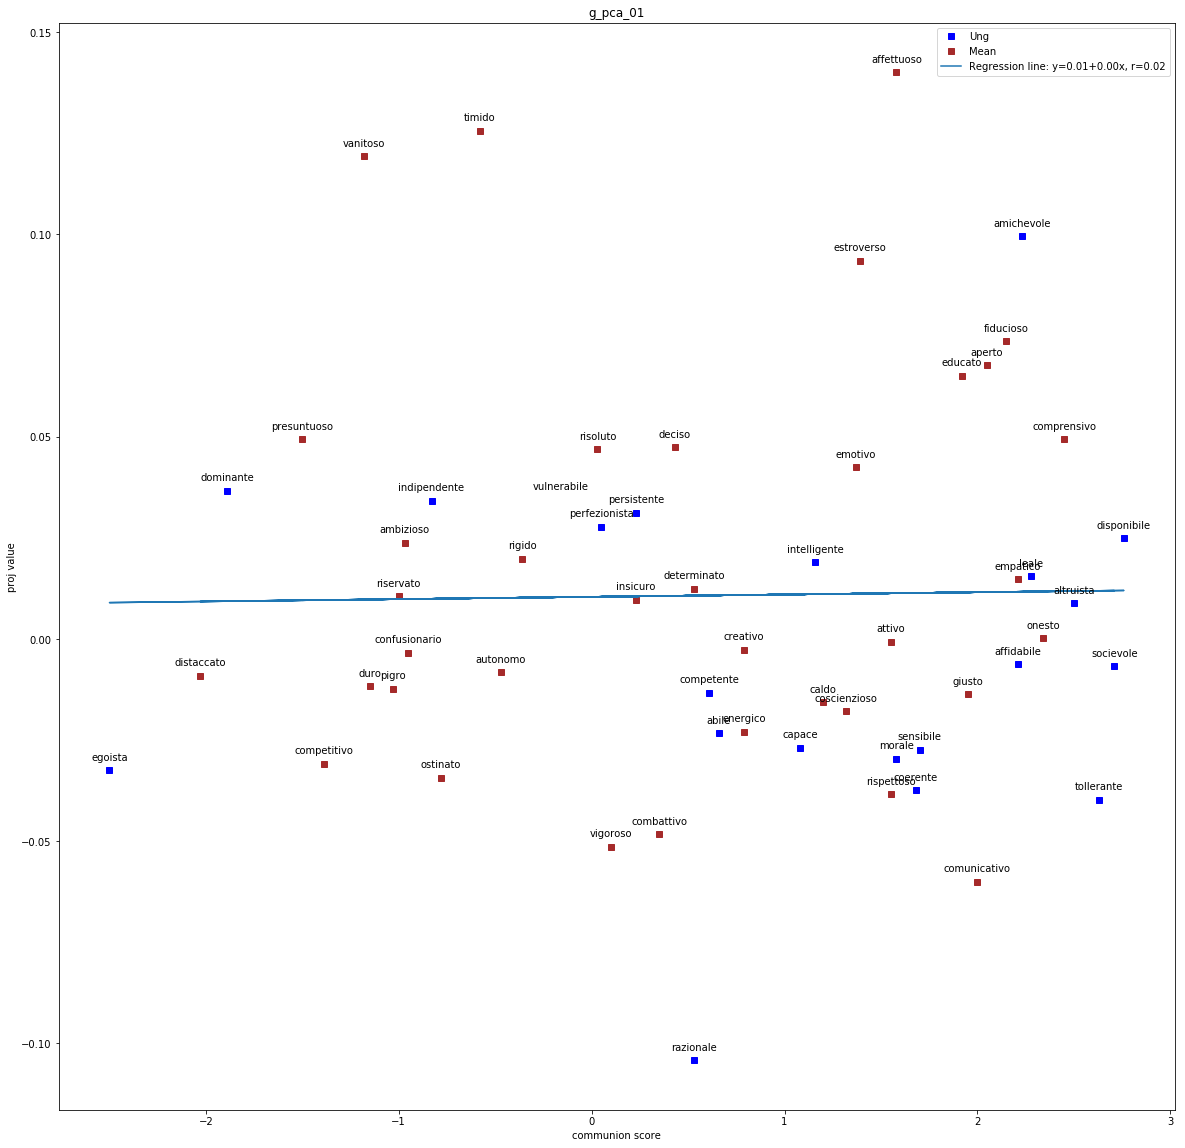

In [281]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col3[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col3[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/com/g_g_pca_01')

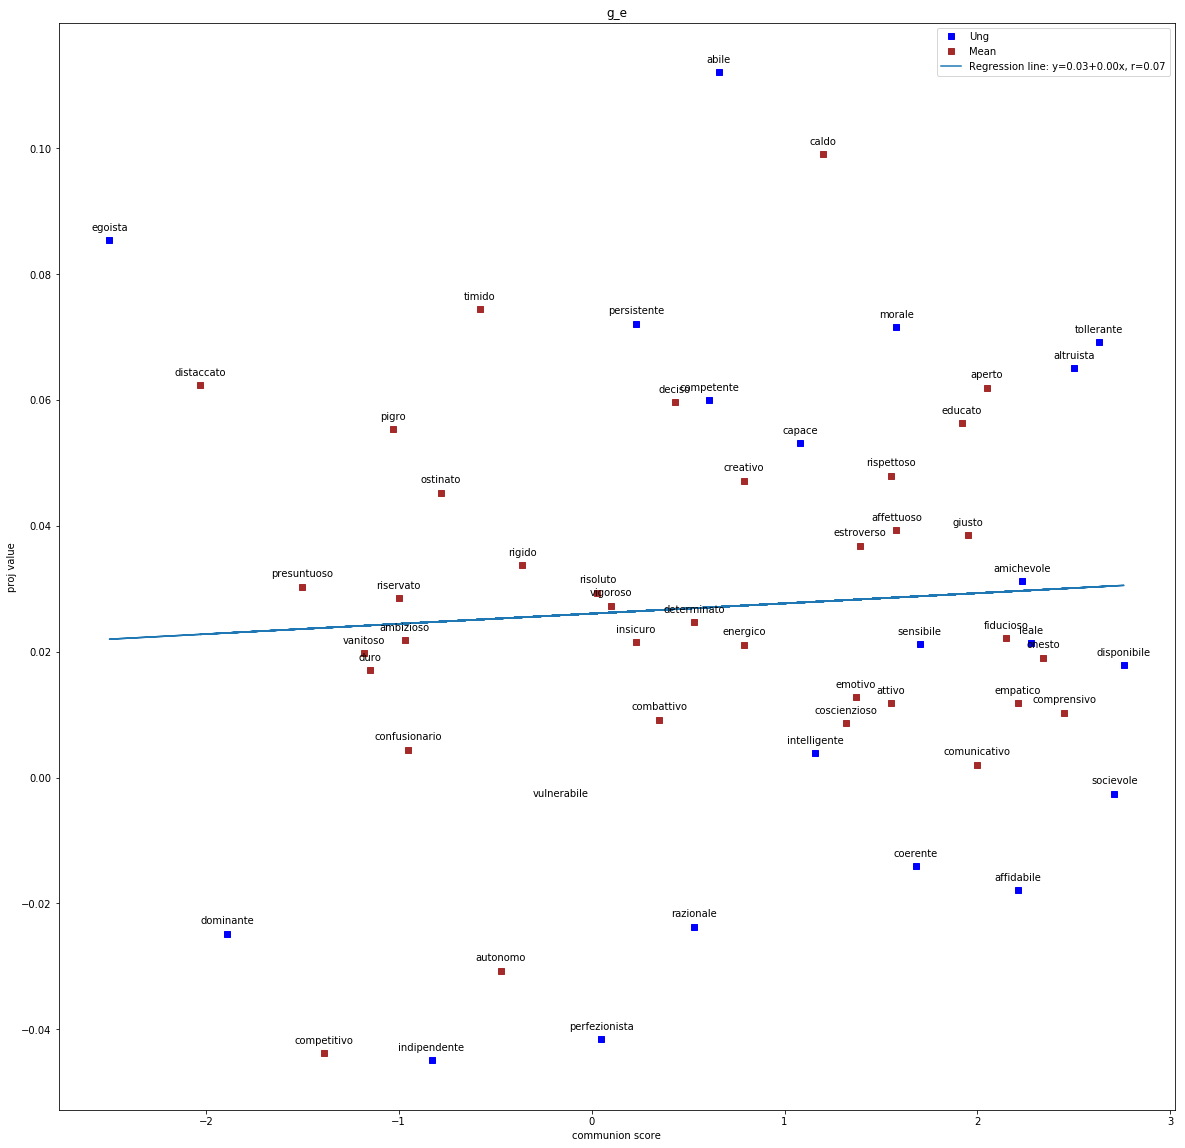

In [282]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col4[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col4[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/com/g_g_e')

In [283]:
# agency-communion correlation
r_ag_com_mean_g_diff = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col1)[0]
r_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col2)[0]
r_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col3)[0]
r_ag_com_mean_g_e = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col4)[0]
p_ag_com_mean_g_diff = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col1)[1]
p_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col2)[1]
p_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col3)[1]
p_ag_com_mean_g_e = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col4)[1]

In [284]:
pearson_data = {'g_diff':[r_ag_com_mean_g_diff,p_ag_com_mean_g_diff],
                'g_pca_0':[r_ag_com_mean_g_pca_0,p_ag_com_mean_g_pca_0],
                'g_pca_01':[r_ag_com_mean_g_pca_01,p_ag_com_mean_g_pca_01],
                'g_e':[r_ag_com_mean_g_e,p_ag_com_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion mean correlation")
pearson_table

Agency-Communion mean correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.162571 -0.066190 -0.143635 -0.157318
p  0.226951  0.624708  0.286454  0.242521